<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Abstract**

This study conducts a comparative evaluation of multiple recommender system models using the MovieLens dataset, with a focus on predictive accuracy and bias diagnostics. The models assessed include collaborative filtering techniques (User-User and Item-Item using Cosine and Pearson similarity), enhanced item-based models (Shrinkage-Aware and IUF-Aware), content-based approaches (TF-IDF, Cosine, Jaccard, and TF-only), and hybrid systems. Additionally, baseline models using genre-only and uncentered genre vectors were analyzed for benchmarking.

Performance was evaluated using RMSE and MAE metrics, supported by diagnostic plots analyzing residual distribution, rating bias, and prediction stability. The Shrinkage-Aware Item-Item Collaborative Filtering model emerged as the most robust and accurate, demonstrating minimal prediction bias and strong generalization across rating bins. While the IUF-Aware model performed comparably in error metrics, it showed more systematic bias in certain rating ranges. User-based models were generally stable, whereas content-based and genre-only models suffered from central tendency bias and reduced accuracy.

The findings highlight the importance of bias-aware enhancements in similarity computation and the limitations of content-based methods when used in isolation. The results provide a strong case for adopting Shrinkage-Aware Item-Item CF in domains where collaborative data is sufficiently dense and prediction precision is critical.


## Data Description

The dataset is a subset of the **MovieLens** dataset, a benchmark dataset provided by GroupLens for building and evaluating recommender systems.

It consists of two main components:

1. **`movies` DataFrame**
   This contains metadata about each movie. Each row includes a unique `movieId`, the `title` (e.g., *Toy Story (1995)*), and a pipe-separated list of `genres` (e.g., *Adventure|Animation|Children|Comedy|Fantasy*).

2. **`ratings` DataFrame**
   This captures user interactions. Each entry includes a `userId`, a `movieId` (referring to a movie from the `movies` DataFrame), a numeric `rating` (from 0.5 to 5.0), and a `timestamp` representing when the rating was recorded.

Together, these datasets support both **collaborative filtering** (via user ratings) and **content-based filtering** (via genre metadata).


### Import Required Libraries

In [1]:
# This section imports all necessary libraries for data processing, similarity computation, evaluation, and visualization.
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


### Exploratory Data Analysis and Implications for Recommender System Design


Unique Users        : 200,948
Unique Movies       : 84,432
Actual Ratings      : 32,000,204
Density of Ratings  : 0.1886%


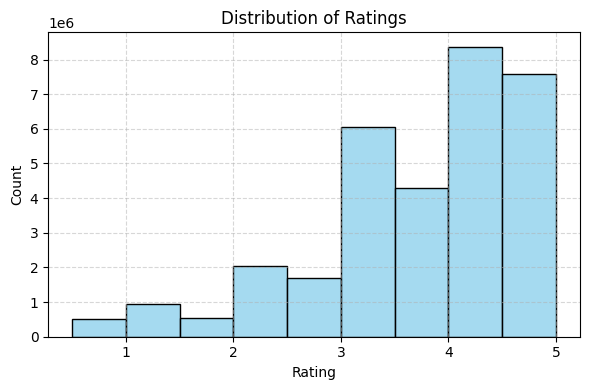

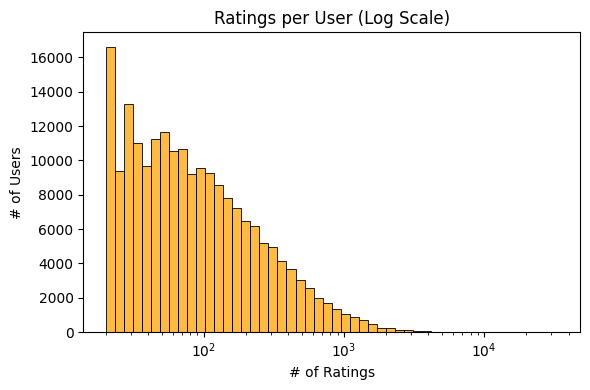

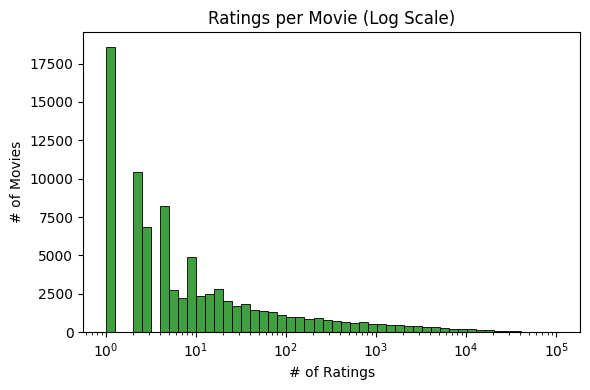

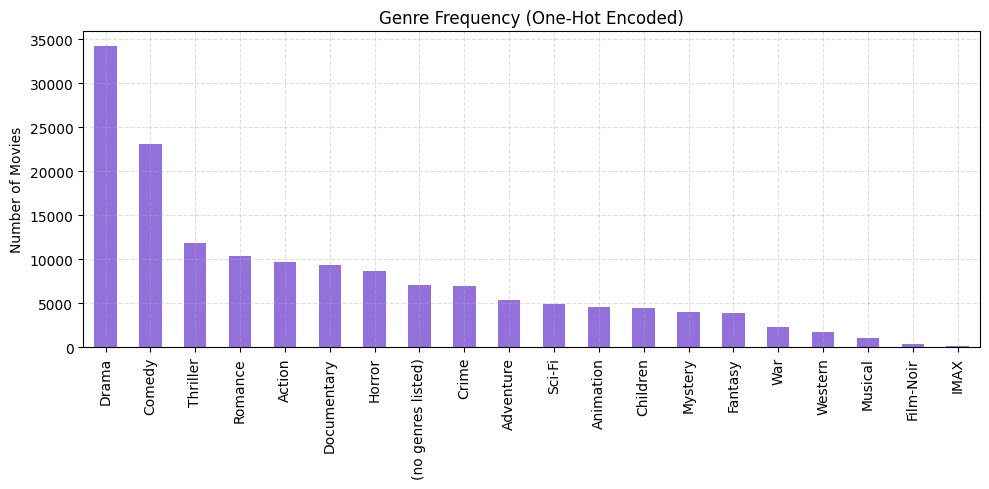

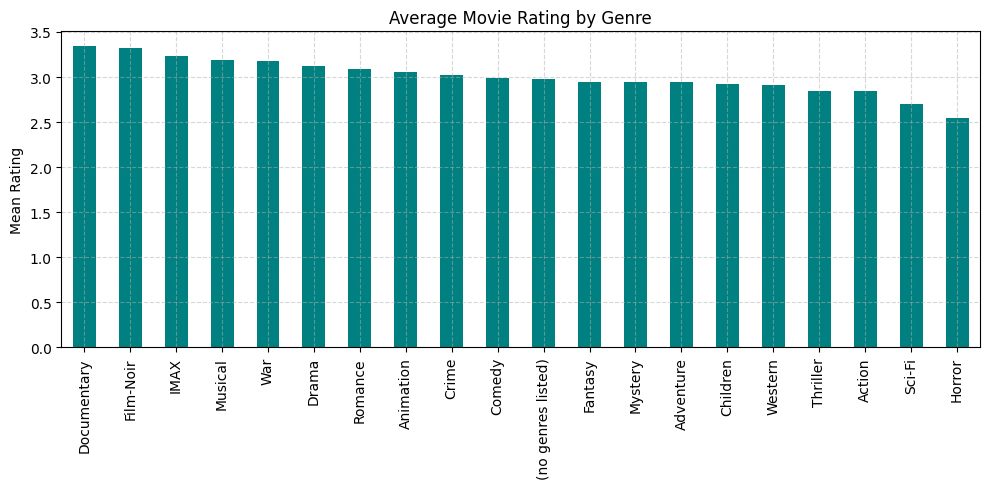

In [2]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv("movies.csv")

# --- Step 2: Explode Genres ---
movies['genres'] = movies['genres'].fillna('(no genres listed)').str.split('|')

# Step 1: Explode the genres into individual rows
movies_with_genres = movies.explode('genres').reset_index(drop=True)

# Step 2: One-hot encode the exploded genres
genre_dummies = pd.get_dummies(movies_with_genres['genres'])

# Step 3: Combine with movieId and group to get multi-hot encoding
movies_with_genres = movies_with_genres[['movieId']].join(genre_dummies)
movies_with_genres = movies_with_genres.groupby('movieId').max().reset_index()

# movies_with_genres = pd.read_csv('/content/movies_with_genres_onehot.csv')

# --- Step 2: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 3: Ratings Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Step 4: Ratings per User ---
user_counts = ratings['userId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(user_counts, bins=50, log_scale=True, color='orange')
plt.title("Ratings per User (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Users")
plt.tight_layout()
plt.show()

# --- Step 5: Ratings per Movie ---
movie_counts = ratings['movieId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(movie_counts, bins=50, log_scale=True, color='green')
plt.title("Ratings per Movie (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Movies")
plt.tight_layout()
plt.show()

# --- Step 6: Genre Frequency from One-Hot ---
genre_cols = [col for col in movies_with_genres.columns if col not in ['movieId', 'title']]
genre_freq = movies_with_genres[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
genre_freq.plot(kind='bar', color='mediumpurple')
plt.title("Genre Frequency (One-Hot Encoded)")
plt.ylabel("Number of Movies")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Step 7: Ratings Diversity per Genre ---
# Strategy: Merge genre flags with mean rating per movie
movie_means = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_stats = pd.merge(movie_means, movies_with_genres, on='movieId', how='inner')

# Compute average rating per genre
genre_rating_avg = {}
for genre in genre_cols:
    genre_rating_avg[genre] = movie_stats[movie_stats[genre] == 1]['rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
pd.Series(genre_rating_avg).sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Average Movie Rating by Genre")
plt.ylabel("Mean Rating")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Dataset Overview**

The MovieLens dataset contains:

* 32,000,204 ratings
* 200,948 unique users
* 84,432 unique movies
* User-Movie Matrix Density: 0.1886%

This confirms the dataset is extremely sparse—fewer than 2 out of every 1,000 user-movie pairs have an actual rating. Sparsity is a key challenge for recommender systems.

**Rating Distribution**

The majority of ratings cluster between 3.0 and 5.0, especially at 4.0, suggesting user positivity bias. Very few 0.5–2.0 ratings were observed.

**2. Genre & Rating Relationships**

Stacked bar plots and heatmaps reveal how ratings are distributed across genres. Drama, Comedy, and Action dominate across all rating levels, especially in the 3.0–4.5 range. These patterns help identify genres with enough data to support collaborative filtering.

**Rating Coverage per Movie**

A long-tail distribution is observed: most movies receive few ratings, while a small group are extremely well-rated (e.g., *Shawshank Redemption*, *Forrest Gump*).

**Rating Coverage per User**

Most users have rated fewer than 100 movies. Only a few users contribute large numbers of ratings, showing heavy-tailed user behavior.

**Top Movies**

Popular titles have over 90,000 ratings, offering a strong base for collaborative filtering.



### Recommender System Suitability Analysis from EDA

***Content-Based Filtering***

* Well-suited for this dataset due to extreme sparsity
* Genre metadata is available for every movie
* Limitation: Genre tags may not capture nuanced content (e.g., plot, style, mood)
* Best suited for cold-start scenarios involving new users or items

***User-User Collaborative Filtering***

* Struggles with data sparsity
* Low overlap between users makes similarity scores unreliable
* Performs better for active users with more than 100 ratings
* Suitable for active user communities or filtering power users

***Item-Item Collaborative Filtering***

* More stable than user-based filtering because items remain in the system
* Reusable similarity matrices improve efficiency
* Suffers when co-rating between items is low (as in long-tail items)
* Best for frequently rated or popular items

***Conclusion and Recommendations***

Given the high sparsity, skewed rating distribution, and long-tail item activity:

* A hybrid recommendation system is recommended
* Content-based filtering is essential for handling cold-start problems
* Item-based collaborative filtering should be prioritized over user-based approaches when rating density allows
* Popularity-based or genre-average fallback models should be implemented for sparse edge cases
* Consider extending metadata (e.g., tags, plot descriptions) or adopting matrix factorization models to uncover deeper patterns in sparse user behavior


### ***Dataset Construction: Stratified Sampling Based on Genre Rarity***

This preprocessing script constructs a stratified and balanced subset of the MovieLens dataset by filtering users and sampling movies based on the inverse frequency of their genres. The goal is to create a more representative and informative dataset for evaluating recommender systems.

**Main steps:**

1. **Data Merging and Cleaning**
   * Load and merge the `ratings.csv` and `movies.csv` datasets
   * Fill missing genre values with `(no genres listed)`

2. **User Filtering and Binning**
   * Identify **active users** (those with at least 100 ratings)
   * Bin users into **quartiles** based on average rating to ensure diverse rating behavior
   * Select the **top 10,000 users** based on rating count

3. **Genre-Based Weighting for Sampling**
   * Count genre frequencies across all movies
   * Compute **inverse frequency weights**: rarer genres are given higher sampling weights
   * Normalize the weights to form a probability distribution
   * Assign each movie a sampling weight based on the rarity of its genres

4. **Movie Sampling**
   * Sample **5,000 movies** using the computed genre weights
   * Filter the full dataset to retain only ratings for these sampled movies

5. **Final Stratification**
   * Filter to retain users who rated **at least 10 of the sampled movies**
   * Split the stratified data into **80% training** and **20% test** sets

This method balances user activity and genre diversity while ensuring a manageable dataset size for training and evaluating recommender algorithms. By upweighting rare genres, the sampled set increases genre heterogeneity and enhances learning for underrepresented categories.


In [3]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Load Datasets ---
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Step 1: Filter Active Users and Bin Ratings ---
user_stats = merged_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(10000)

# Filter merged_df to active users only
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Step 2: Genre Weights Based on Rarity ---
all_genres_combined = '|'.join(merged_df['genres'].dropna().values)
genre_counts = Counter(all_genres_combined.split('|'))
genre_weights_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_weights_df['inv_weight'] = genre_weights_df['count'].max() / genre_weights_df['count']
genre_weights_df['norm_weight'] = genre_weights_df['inv_weight'] / genre_weights_df['inv_weight'].sum()
genre_weight_dict = genre_weights_df['norm_weight'].to_dict()

def get_genre_weight(genres, weight_dict):
    for genre in genres.split('|'):
        if genre in weight_dict:
            return weight_dict[genre]
    return 0

# --- Step 3: Sample Movies Based on Genre Weights ---
movie_metadata = merged_df[['movieId', 'title', 'genres']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genres'].apply(lambda x: get_genre_weight(x, genre_weight_dict))
movie_metadata.dropna(subset=['weight'], inplace=True)

sampled_movies = movie_metadata.sample(n=5000, weights='weight', random_state=42)
sampled_movie_ids = sampled_movies['movieId'].unique()

# --- Step 4: Create Stratified Dataset ---
stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

# Keep users with at least 10 ratings in this subset
rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
eligible_users = rating_density[rating_density['num_ratings'] >= 10]['userId']
stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

# --- Step 5: Train-Test Split ---
train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

print(train_ratings.shape, test_ratings.shape)

(106266, 6) (26567, 6)


### **Unified Methodology for Recommender Systems Used**

The following outlines a standardized workflow shared across multiple recommender system models—spanning memory-based collaborative filtering and content-based approaches. Despite differences in similarity measures and enhancements, these models follow a common structure for data preparation, similarity computation, prediction, evaluation, and visualization.

**1. Data Preparation**

* Create a user-item rating matrix.
* Calculate global mean, user means, and item means for bias correction.

**2. Similarity Computation**

* Compute similarity matrix using one of the following:

  * **Cosine similarity** (with or without shrinkage)
  * **Pearson correlation**
  * **Jaccard similarity**
  * **TF**, **TF-IDF**, or **IUF** weighted vectors (for genres)
* Apply enhancements (e.g., shrinkage or frequency correction) as needed.

**3. Rating Prediction (with Bias Correction)**

* For each user-item pair:

  * Identify relevant neighbors (rated items or similar users).
  * Compute weighted residuals:

$$
\hat{r}_{ui} = \mu + b_u + b_i + \frac{\sum_{j \in N(i)} \text{sim}(i,j) \cdot (r_{uj} - \bar{r}_j)}{\sum_{j \in N(i)} |\text{sim}(i,j)|}
$$

* Clip final predictions to $0.5, 5.0$.

**4. Evaluation**

* Assess prediction accuracy using:

  * RMSE
  * MAE
  * R² Score

**5. Visualization**

* Box plot: actual vs predicted ratings.
* KDE plot: smoothed rating distributions.
* Scatter plot: predicted vs actual ratings.
* Residual analysis:

  * Residuals vs actual
  * Residuals vs predicted
  * Histogram of residuals
  * Bias by predicted bin
* Dataset rating distribution histogram.


## Collaborative Filtering

## **Item-Item Collaborative Filtering**

### **Item-Item Collaborative Filtering with Cosine Similarity**

**Methodology**

**Centered Cosine Similarity Computation**

* Centers the user-item rating matrix by subtracting user averages to emphasize deviations rather than absolute ratings.
* Calculates cosine similarity between item vectors based on this centered matrix and saves the similarity matrix for scalable prediction.

**Bias-Adjusted Rating Prediction**

* Combines baseline estimates from global, user, and item means with a similarity-weighted residual correction.
* Applies clipping to restrict predictions within the valid rating range.

**Parallel Batch Prediction**

* Performs test-set predictions efficiently using parallel processing, distributing computation across available cores for scalability.

**Model Evaluation and Visualization**

* Evaluates prediction performance using RMSE, MAE, and R².
* Includes a comprehensive suite of visual diagnostics: box plots, KDE curves, scatter plots for actual vs predicted, histograms of residuals, and bias analysis across predicted bins.

Let me know if you’d like a combined summary that compares all your collaborative filtering methods side by side.


Item-Item CF with Cosine Similarity:
RMSE = 0.9102, MAE = 0.6868, R² = 0.2624


/tmp/ipython-input-4-1936921308.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')
/tmp/ipython-input-4-1936921308.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data_cosine, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-4-1936921308.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


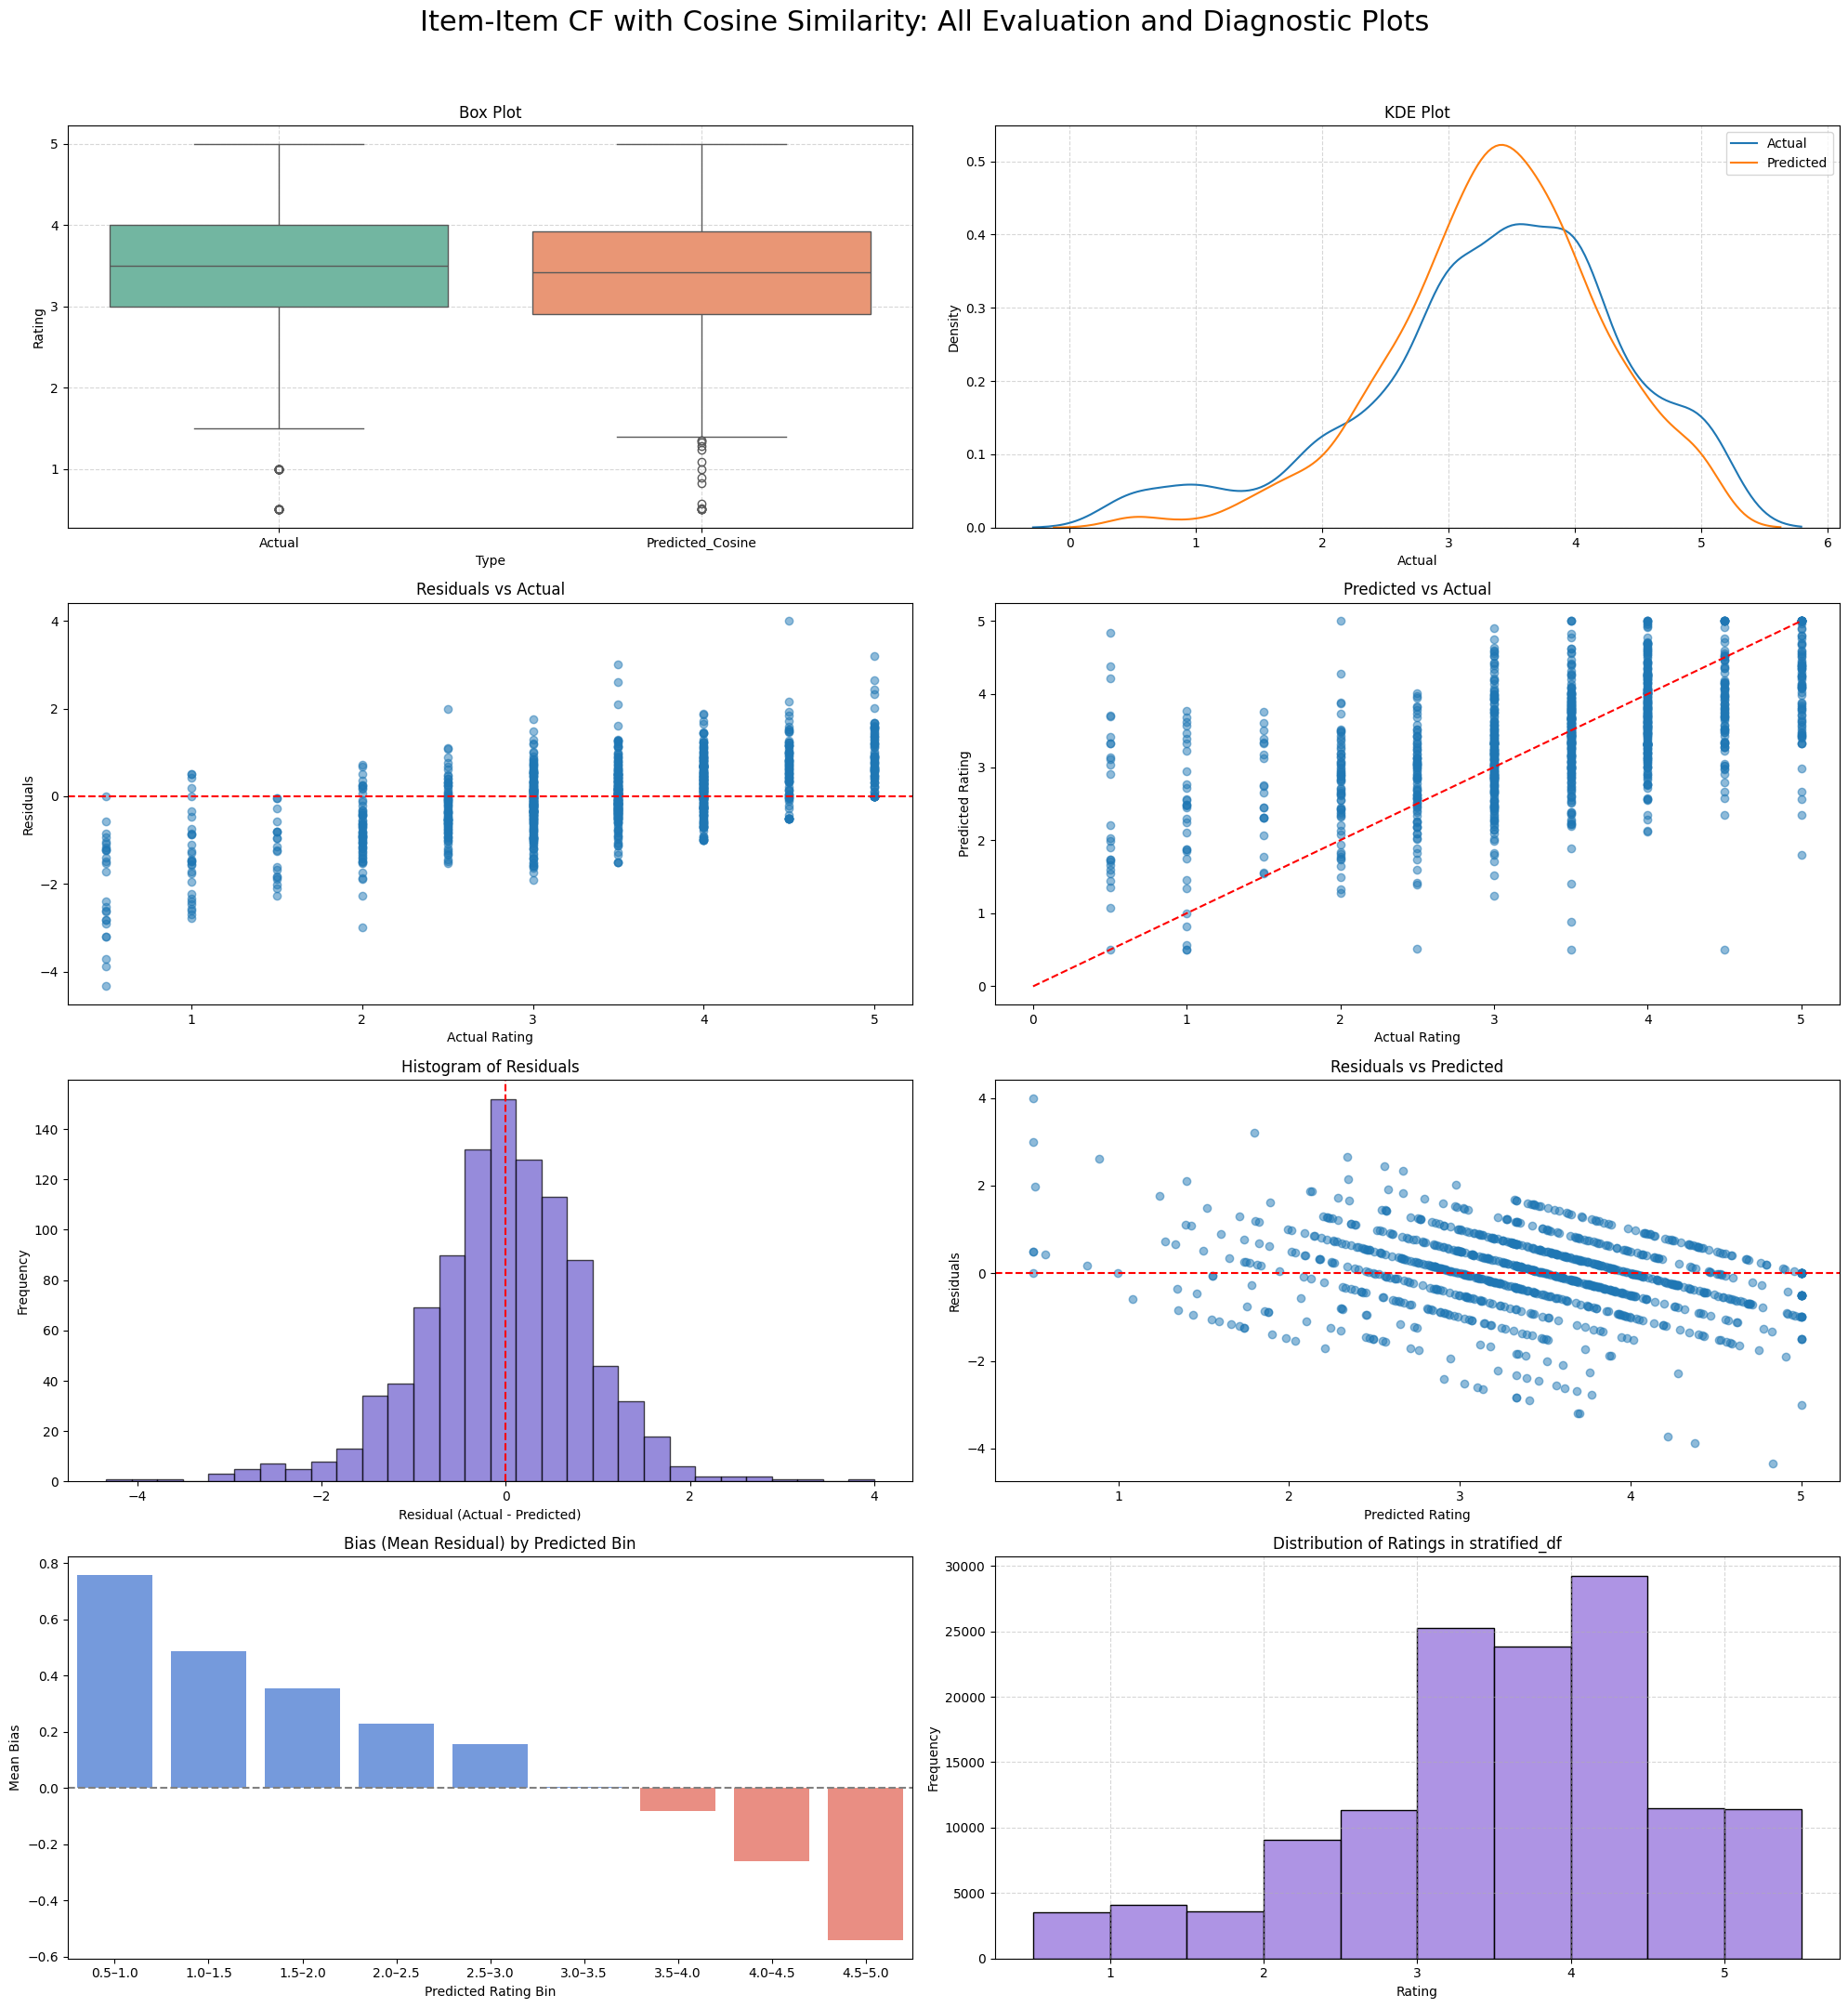

In [4]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix & Common Stats ---
user_item_matrix_common = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean_common = train_ratings['rating'].mean()
item_means_common = train_ratings.groupby('movieId')['rating'].mean()
user_means_common = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Save to Parquet ---
user_item_matrix_common.to_parquet("user_item_matrix_common.parquet")
item_means_common.to_frame("item_mean").to_parquet("item_means_common.parquet")
user_means_common.to_frame("user_mean").to_parquet("user_means_common.parquet")

# --- Step 4: Compute and Save Similarity Matrix ---
user_item_centered_common = user_item_matrix_common.sub(user_item_matrix_common.mean(axis=1), axis=0)
item_item_sim_matrix_cosine = pd.DataFrame(
    cosine_similarity(user_item_centered_common.T.fillna(0)),
    index=user_item_centered_common.columns,
    columns=user_item_centered_common.columns
)
item_item_sim_matrix_cosine.to_parquet("item_item_sim_matrix_cosine.parquet")

# --- Step 5: Load Matrices ---
user_item_matrix_common = pd.read_parquet("user_item_matrix_common.parquet")
item_means_common = pd.read_parquet("item_means_common.parquet")['item_mean']
user_means_common = pd.read_parquet("user_means_common.parquet")['user_mean']
item_item_sim_matrix_cosine = pd.read_parquet("item_item_sim_matrix_cosine.parquet")

# --- Step 6: Prediction Function ---
def predict_rating_item_item_cosine(uid, mid):
    if uid not in user_item_matrix_common.index or mid not in item_item_sim_matrix_cosine.index:
        return global_mean_common

    sims = item_item_sim_matrix_cosine[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_common.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Parallel Predictions Without Progress Bar ---
def parallel_predict_cosine(row):
    uid, mid, actual = row.userId, row.movieId, row.rating
    pred = predict_rating_item_item_cosine(uid, mid)
    return [uid, mid, actual, pred]

results_cosine = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict_cosine)(row) for row in test_ratings.itertuples(index=False)
)

viz_df_cosine = pd.DataFrame(results_cosine, columns=['userId', 'movieId', 'Actual', 'Predicted_Cosine'])

# --- Step 8: Evaluation ---
rmse_cosine = np.sqrt(mean_squared_error(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine']))
mae_cosine = mean_absolute_error(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine'])
r2_cosine = r2_score(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine'])

print(f"Item-Item CF with Cosine Similarity:\nRMSE = {rmse_cosine:.4f}, MAE = {mae_cosine:.4f}, R² = {r2_cosine:.4f}")

# --- Step 9: Plotting All Diagnostics in One Faceted Grid ---
viz_sample_cosine = viz_df_cosine.sample(n=min(len(viz_df_cosine), 1000), random_state=42)
residuals_cosine = viz_sample_cosine['Actual'] - viz_sample_cosine['Predicted_Cosine']
box_data_cosine = viz_sample_cosine[['Actual', 'Predicted_Cosine']].melt(var_name='Type', value_name='Rating')

# Bias Summary
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_cosine['pred_bin'] = pd.cut(viz_df_cosine['Predicted_Cosine'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df_cosine['Residual_Cosine'] = viz_df_cosine['Actual'] - viz_df_cosine['Predicted_Cosine']
bias_summary = (
    viz_df_cosine
    .groupby('pred_bin')
    .agg(Mean_Residual=('Residual_Cosine', 'mean'))
    .reset_index()
)

# Create Faceted Plot Grid
fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Item-Item CF with Cosine Similarity: All Evaluation and Diagnostic Plots", fontsize=22)

# --- Plot 1: Box Plot ---
sns.boxplot(data=box_data_cosine, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: KDE Plot ---
sns.kdeplot(viz_sample_cosine['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_cosine['Predicted_Cosine'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Plot 3: Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_cosine['Actual'], residuals_cosine, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Plot 4: Predicted vs Actual ---
axs[1, 1].scatter(viz_sample_cosine['Actual'], viz_sample_cosine['Predicted_Cosine'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Plot 5: Histogram of Residuals ---
axs[2, 0].hist(residuals_cosine, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Plot 6: Residuals vs Predicted ---
axs[2, 1].scatter(viz_sample_cosine['Predicted_Cosine'], residuals_cosine, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# --- Plot 7: Bias by Predicted Bin ---
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Bias")

# --- Plot 8: Distribution of Ratings ---
sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ***2. IUF-Based Item-Item Collaborative Filtering***

**Methodology**

* **User-Item Matrix**: Built by pivoting training ratings into a matrix where each cell represents a user’s average rating for a movie.

* **Inverse User Frequency (IUF) Weighting**:
  IUF adjusts item vectors to reduce the influence of frequently rated (popular) movies. Items rated by many users are downweighted.

  $$
  \text{IUF}(j) = \log\left(\frac{N}{n_j + \epsilon}\right)
  $$

  where:

  * $N$ = total number of users
  * $n_j$ = number of users who rated item $j$
  * $\epsilon$ = small constant to avoid division by zero

* **Cosine Similarity on IUF-Weighted Matrix**:
  Item-item cosine similarity is computed using IUF-weighted item vectors to better capture meaningful relationships.

* **Prediction Function**:
  For user $u$ and item $i$, prediction is made using:

  $$
  \hat{r}_{ui} = \mu + b_u + b_i + \sum_{j \in N(i)} w_{ij} \cdot (r_{uj} - \bar{r}_j)
  $$

  where:

  * $\mu$ = global mean rating
  * $b_u, b_i$ = user and item biases
  * $w_{ij}$ = normalized similarity between item $i$ and neighbor $j$
  * $\bar{r}_j$ = average rating for item $j$


IUF-Aware Item-Item CF:
RMSE=1.0186, MAE=0.7649, R²=0.0762


/tmp/ipython-input-5-2660350877.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  viz_df_iuf.groupby('pred_bin')
/tmp/ipython-input-5-2660350877.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', palette='Set2', ax=axs[0, 0])
/tmp/ipython-input-5-2660350877.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='Predicted Bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


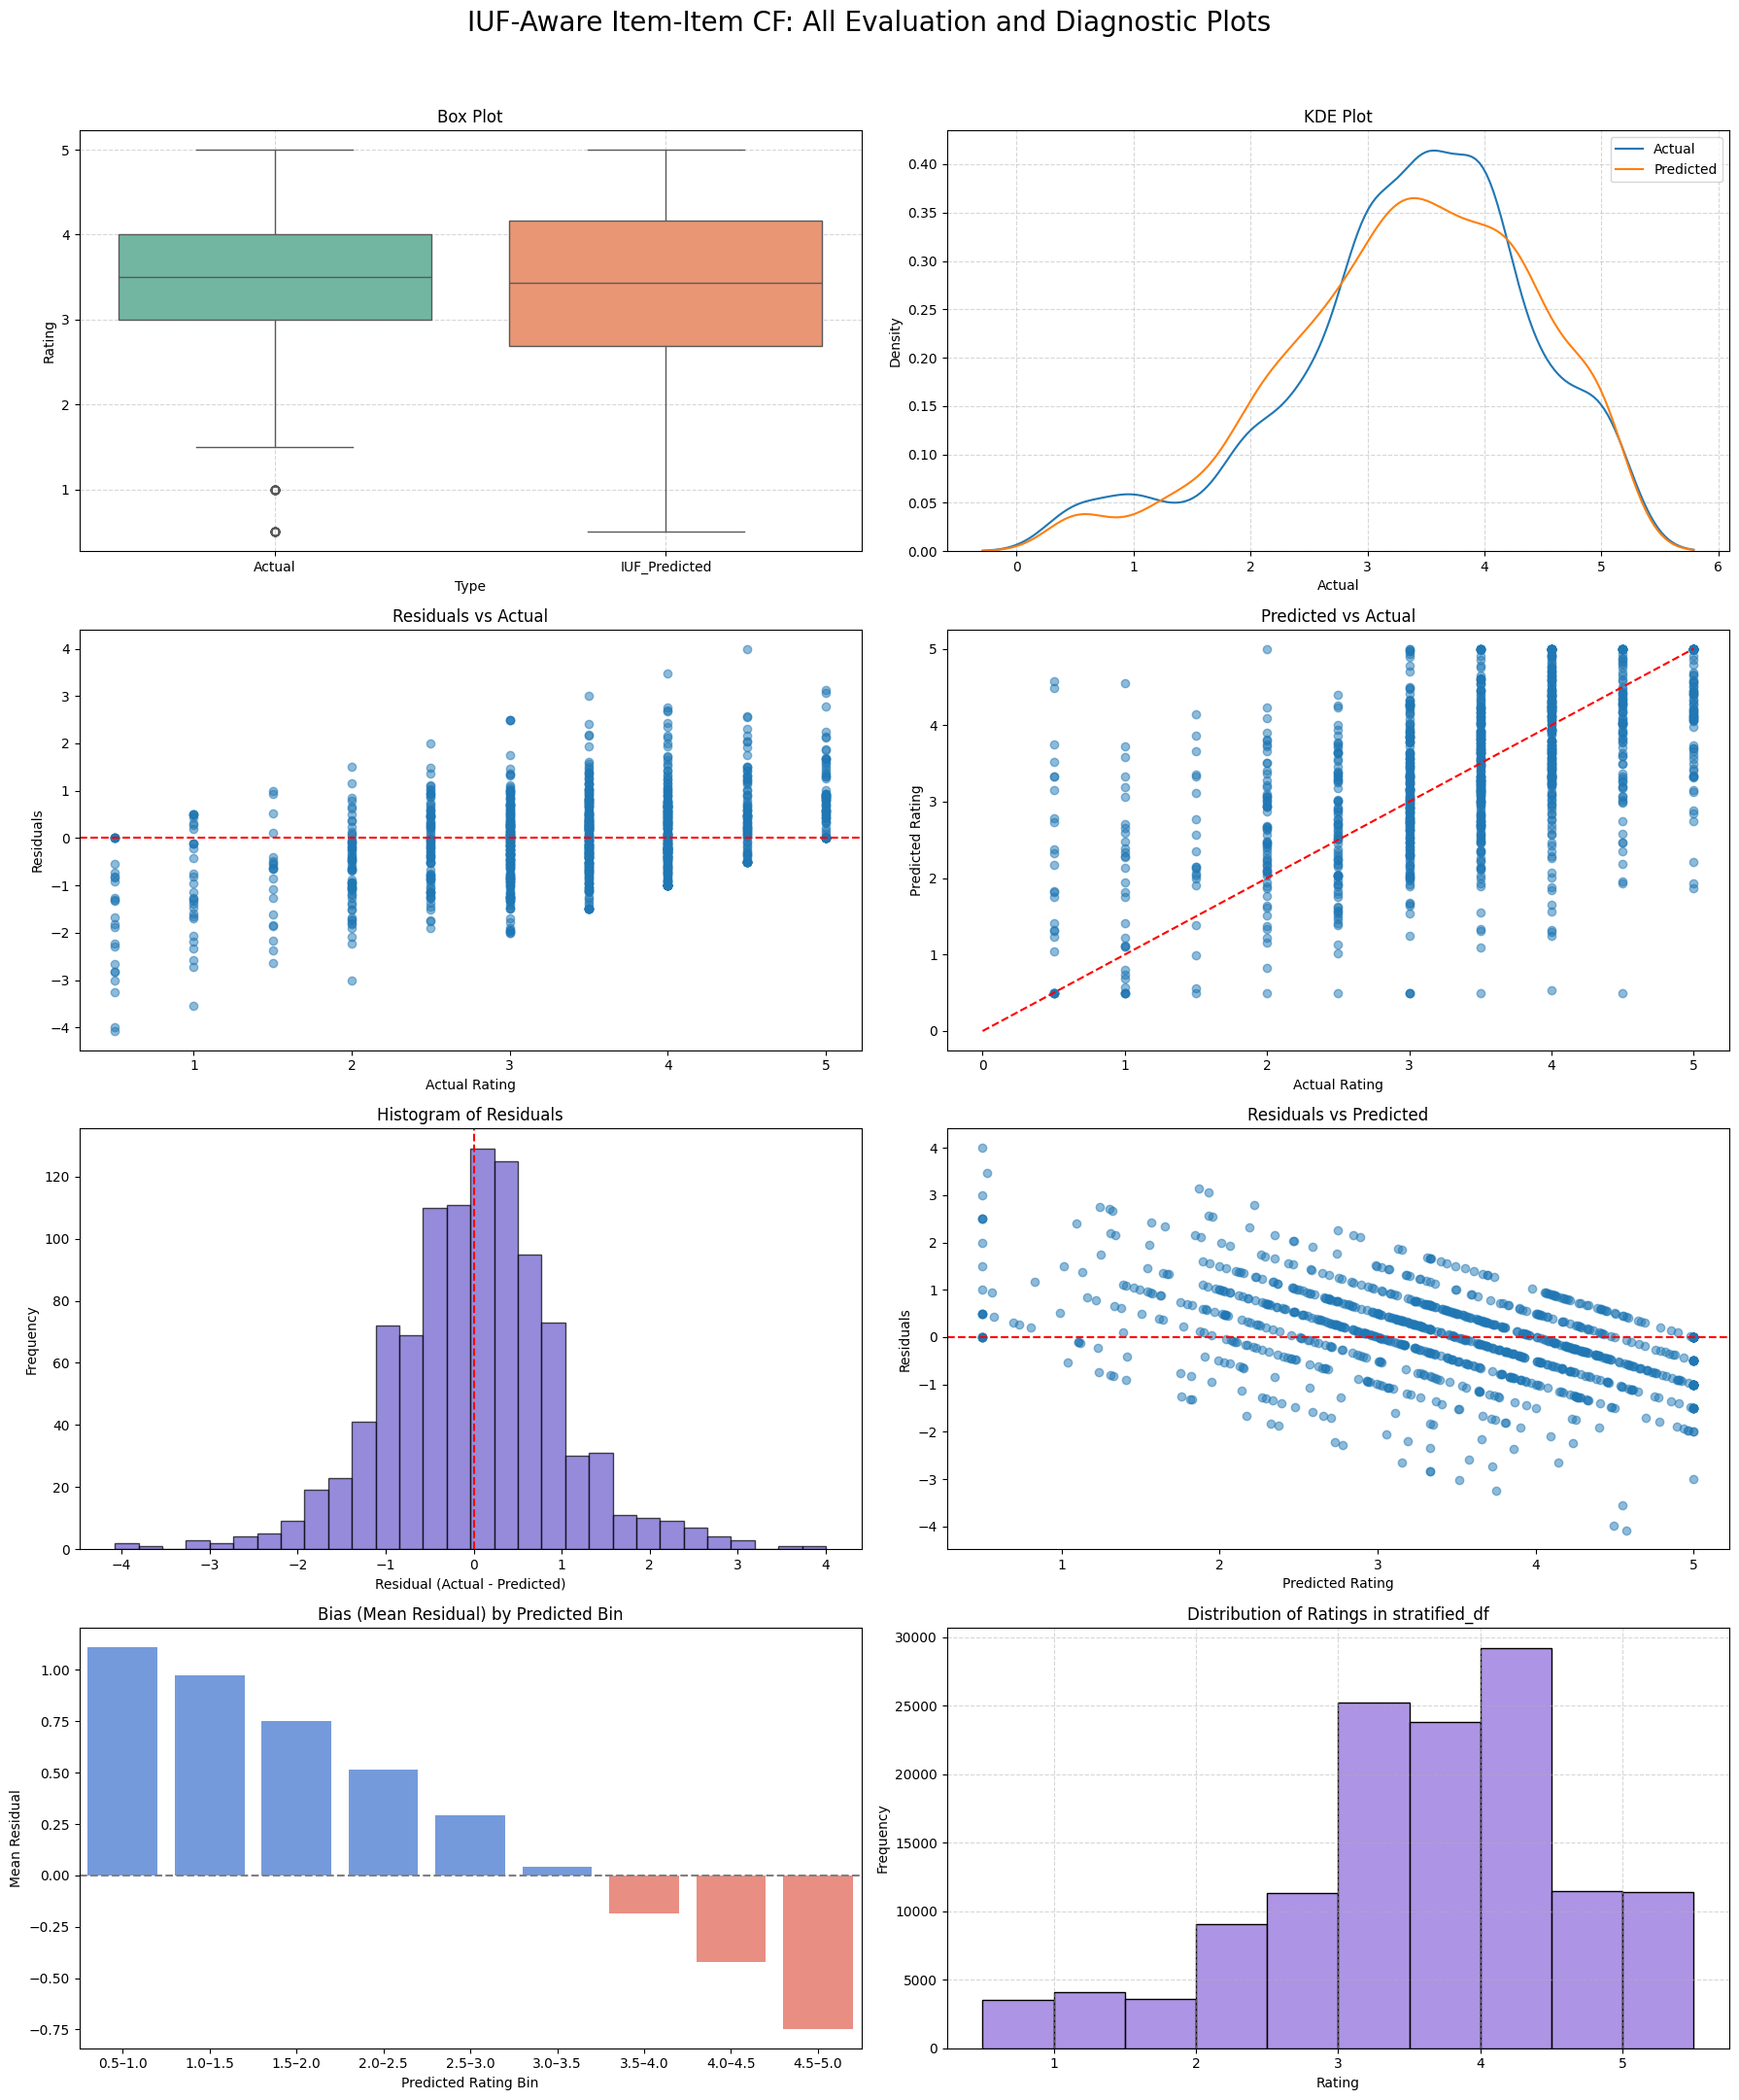

In [5]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: Pivot User-Item Matrix ---
train_ratings_grouped = train_ratings.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_common = train_ratings_grouped.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Apply IUF and Save Matrices ---
def apply_iuf_weighting(matrix):
    user_counts = (~matrix.isna()).sum(axis=0)
    iuf = np.log(matrix.shape[0] / (user_counts + 1e-9))
    return matrix.multiply(iuf, axis=1)

user_item_matrix_iuf = apply_iuf_weighting(user_item_matrix_common)

user_item_matrix_common.to_parquet("user_item_matrix_common.parquet")
user_item_matrix_iuf.to_parquet("user_item_matrix_iuf.parquet")

item_item_sim_matrix_iuf = 1 - pairwise_distances(user_item_matrix_iuf.T.fillna(0), metric='cosine')
item_item_sim_df_iuf = pd.DataFrame(item_item_sim_matrix_iuf, index=user_item_matrix_iuf.columns, columns=user_item_matrix_iuf.columns)
item_item_sim_df_iuf.to_parquet("item_item_sim_df_iuf.parquet")

# --- Step 4: Simulate Reading from File ---
user_item_matrix_common = pd.read_parquet("user_item_matrix_common.parquet")
user_item_matrix_iuf = pd.read_parquet("user_item_matrix_iuf.parquet")
item_item_sim_df_iuf = pd.read_parquet("item_item_sim_df_iuf.parquet")

# --- Step 5: Stats ---
global_mean_common = train_ratings['rating'].mean()
item_means_common = train_ratings.groupby('movieId')['rating'].mean()
user_means_common = train_ratings.groupby('userId')['rating'].mean()

# --- Step 6: Prediction Function ---
def predict_rating_iuf_item_item(uid, mid):
    if uid not in user_item_matrix_common.index or mid not in item_item_sim_df_iuf.index:
        return global_mean_common

    sims = item_item_sim_df_iuf[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_common.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Predict (No Progress Bar) ---
results_iuf = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_rating_iuf_item_item(uid, mid)
    results_iuf.append([uid, mid, actual, pred])

viz_df_iuf = pd.DataFrame(results_iuf, columns=['userId', 'movieId', 'Actual', 'IUF_Predicted'])

# --- Step 8: Evaluation ---
rmse_iuf = np.sqrt(mean_squared_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Predicted']))
mae_iuf = mean_absolute_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Predicted'])
r2_iuf = r2_score(viz_df_iuf['Actual'], viz_df_iuf['IUF_Predicted'])

print(f"IUF-Aware Item-Item CF:\nRMSE={rmse_iuf:.4f}, MAE={mae_iuf:.4f}, R²={r2_iuf:.4f}")

# --- Step 9: Unified Faceted Evaluation + Diagnostic Plots ---
viz_sample_iuf = viz_df_iuf.sample(n=min(len(viz_df_iuf), 1000), random_state=42)
residuals = viz_sample_iuf['Actual'] - viz_sample_iuf['IUF_Predicted']
box_data = viz_sample_iuf[['Actual', 'IUF_Predicted']].melt(var_name='Type', value_name='Rating')

# Bin definitions
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_iuf['pred_bin'] = pd.cut(
    viz_df_iuf['IUF_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

bias_summary = (
    viz_df_iuf.groupby('pred_bin')
    .agg(Mean_Residual=('Actual', lambda x: (x - viz_df_iuf.loc[x.index, 'IUF_Predicted']).mean()))
    .reindex(bin_labels)
    .reset_index()
    .rename(columns={'pred_bin': 'Predicted Bin'})
)

# Rating distribution for stratified_df
rating_distribution = stratified_df['rating']

# --- Create Faceted Layout ---
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
fig.suptitle("IUF-Aware Item-Item CF: All Evaluation and Diagnostic Plots", fontsize=20)

# 1. Box Plot
sns.boxplot(data=box_data, x='Type', y='Rating', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(viz_sample_iuf['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_iuf['IUF_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residuals vs Actual
axs[1, 0].scatter(viz_sample_iuf['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# 4. Predicted vs Actual
axs[1, 1].scatter(viz_sample_iuf['Actual'], viz_sample_iuf['IUF_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# 5. Histogram of Residuals
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# 6. Residuals vs Predicted
axs[2, 1].scatter(viz_sample_iuf['IUF_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# 7. Bias Bar Plot by Predicted Bin
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='Predicted Bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Residual")

# 8. Distribution of Ratings
sns.histplot(rating_distribution, bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




### ***3. Shrinkage-Aware Item-Item Collaborative Filtering***

**Methodology**

* **IUF Weighting**: Inverse User Frequency (IUF) weights were computed for each item to penalize popular items. Each item's rating column in the matrix was scaled by its IUF weight.

* **Cosine Similarity Calculation**: Cosine similarity was computed between items based on the IUF-weighted user-item matrix, treating each item as a vector of user ratings.

* **Shrinkage Adjustment**: A shrinkage term was applied to each similarity score using co-rating counts between items. The formula used was:

  $$
  \text{adjusted_sim}(i, j) = \text{cosine_sim}(i, j) \times \frac{n_{ij}}{n_{ij} + \lambda}
  $$

  where $n_{ij}$ is the number of users who rated both items and $\lambda$ is a regularization constant.

* **Final Similarity Matrix**: The final similarity matrix was created by combining cosine similarity with shrinkage, allowing more confidence in similarity scores based on more co-ratings.

* **Prediction Function**: For a user-item pair, predictions were generated using a neighborhood of items the user has rated. Ratings were adjusted for item mean, weighted by similarity, and corrected with user and item bias around the global mean.






100%|██████████| 26567/26567 [01:00<00:00, 441.63it/s]
/tmp/ipython-input-19-2301042026.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary_shrinkage = viz_df_shrinkage.groupby('pred_bin').agg(Mean_Residual=('Residual_Shrinkage', 'mean')).reset_index()


Shrinkage-Aware Item-Item CF:
RMSE=1.0186, MAE=0.7649, R²=0.0762


/tmp/ipython-input-19-2301042026.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data_shrinkage, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-19-2301042026.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary_shrinkage, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


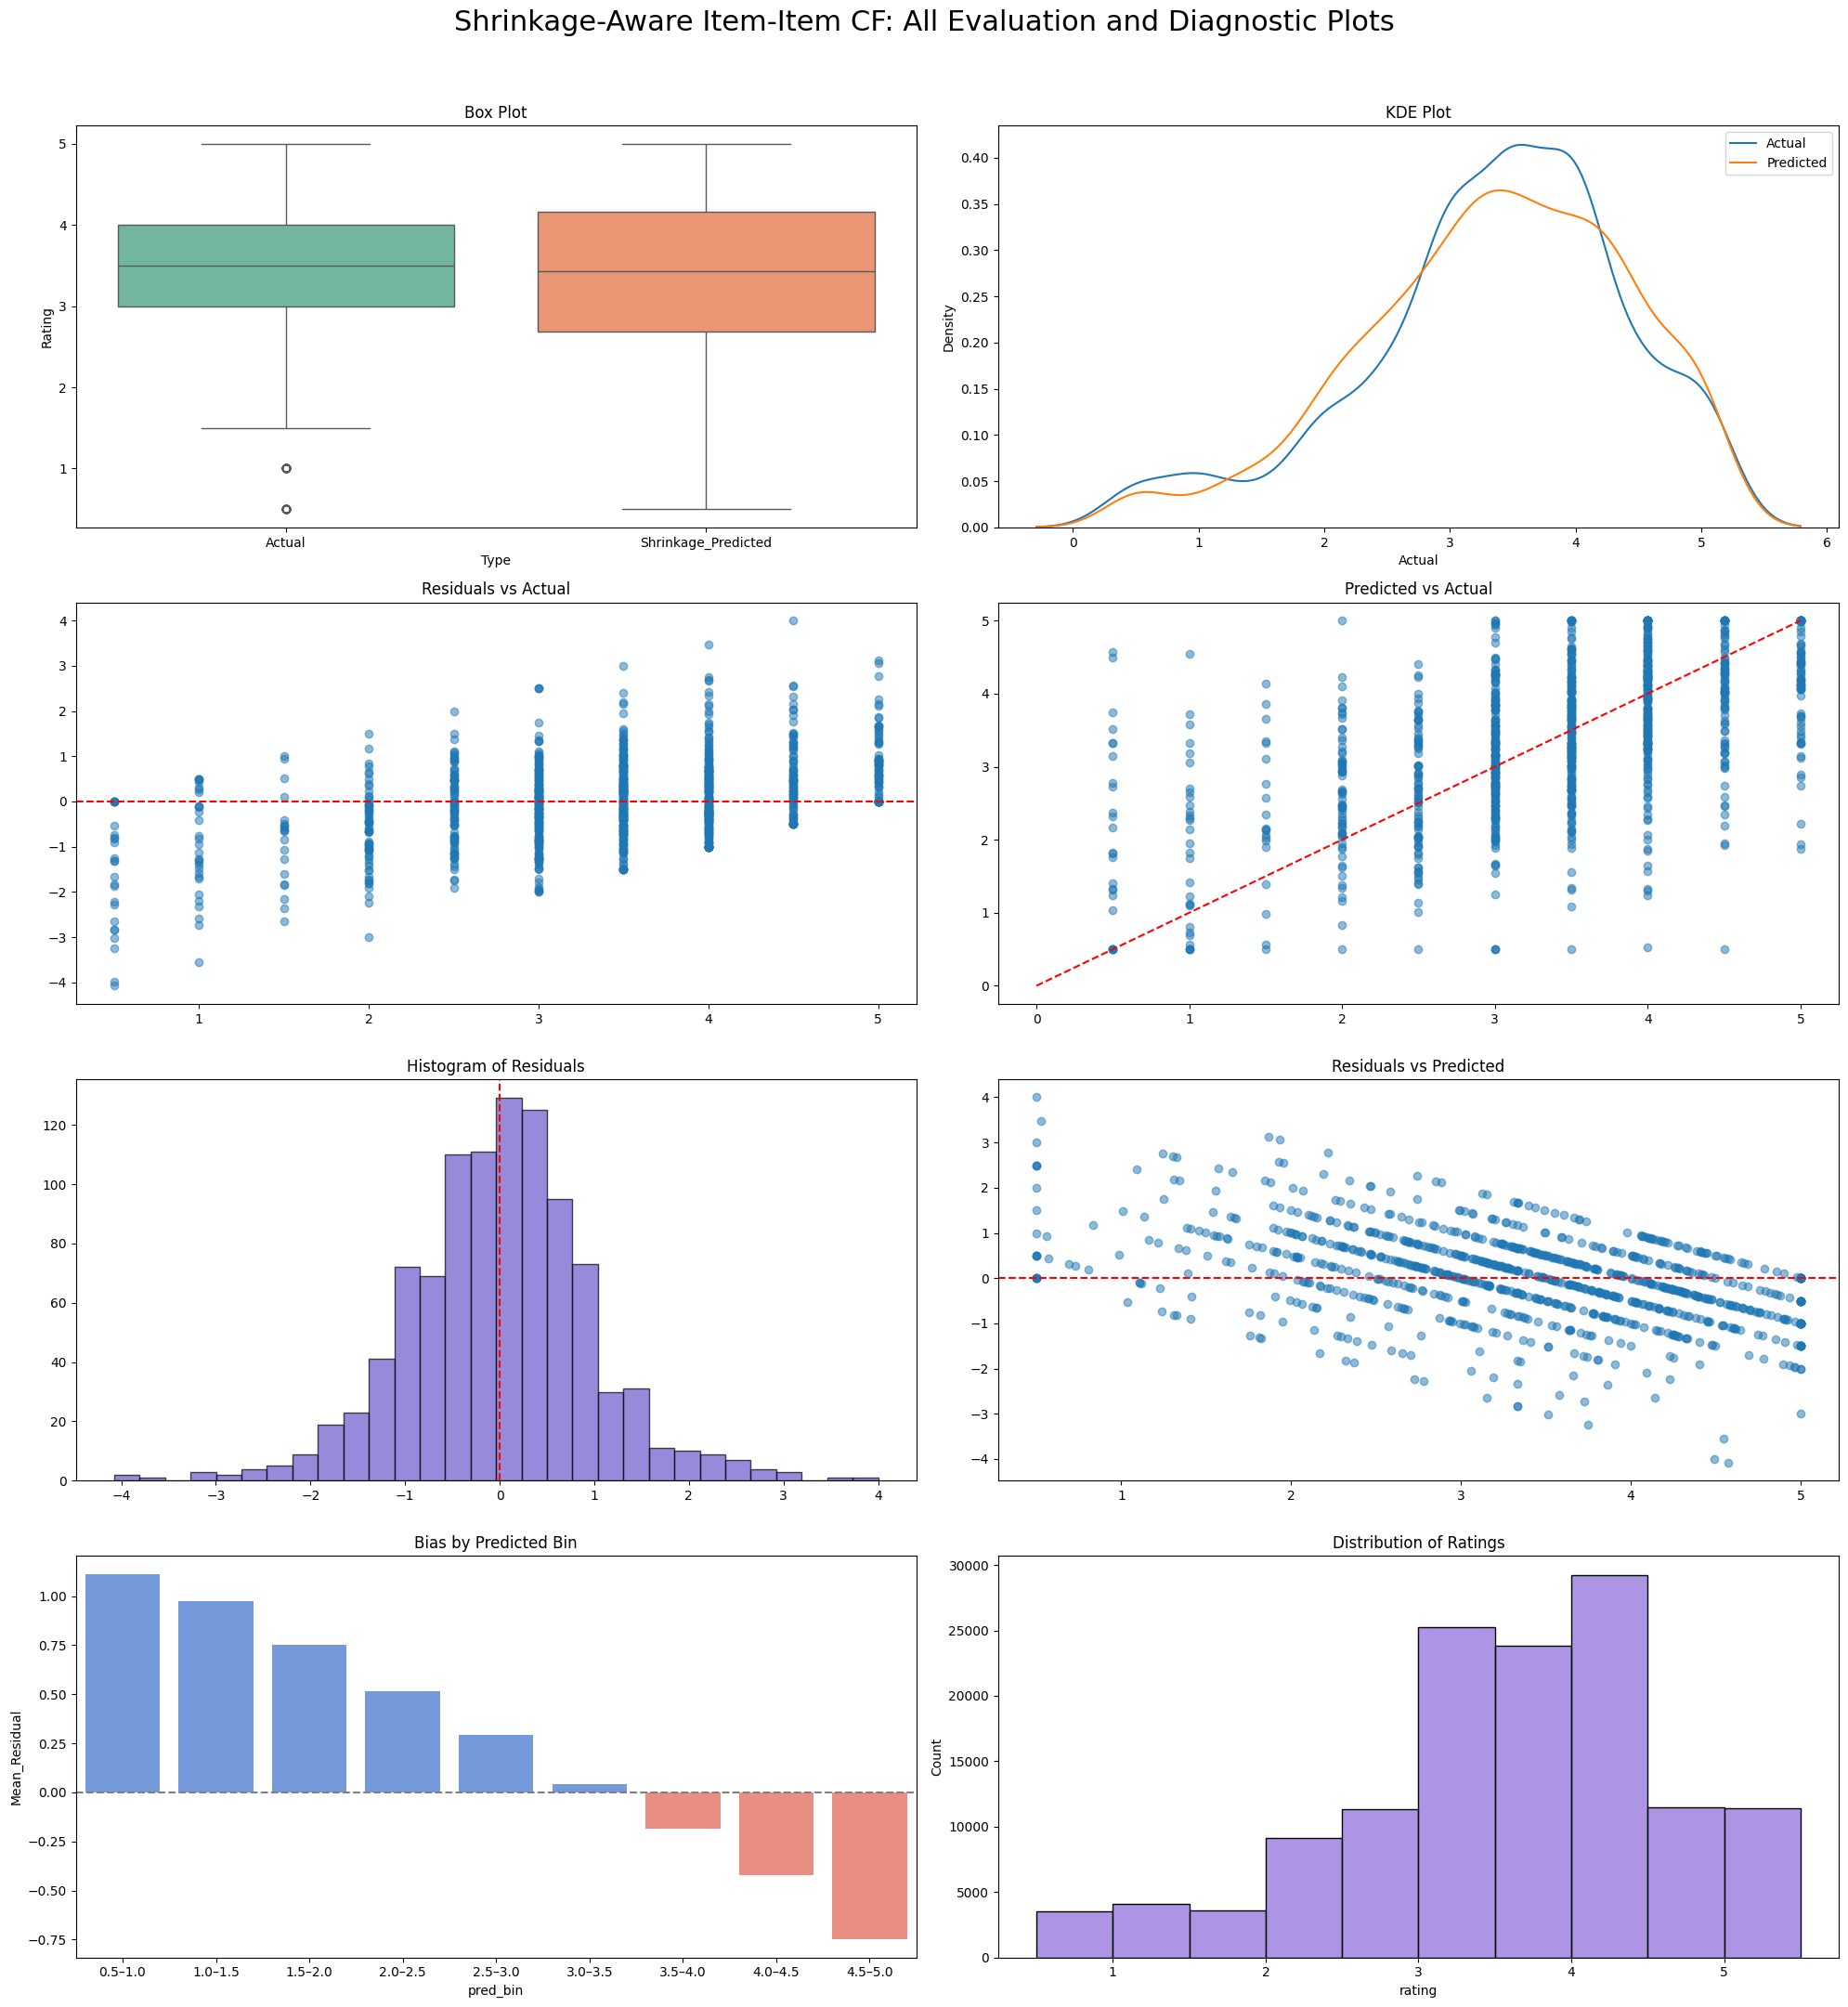

In [19]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_shrinkage = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_shrinkage = stratified_df.drop(train_ratings_shrinkage.index)

# --- Step 2: Pivot User-Item Matrix ---
train_ratings_grouped_shrinkage = train_ratings_shrinkage.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_shrinkage = train_ratings_grouped_shrinkage.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Compute Shrinkage-Aware Cosine Similarity ---
item_rating_counts_shrinkage = user_item_matrix_shrinkage.notna().sum(axis=0)
reg_lambda = 10
iuf_weights_shrinkage = np.log(user_item_matrix_shrinkage.shape[0] / (item_rating_counts_shrinkage + 1e-9))
iuf_matrix_shrinkage = user_item_matrix_shrinkage.multiply(iuf_weights_shrinkage, axis=1)
cosine_matrix_shrinkage = 1 - pairwise_distances(iuf_matrix_shrinkage.T.fillna(0), metric='cosine')

from scipy.sparse import csr_matrix

# Convert boolean mask to sparse matrix
mask_sparse = csr_matrix(~user_item_matrix_shrinkage.isna().values)

# Efficient co-rated counts using sparse matrix multiplication
co_rated_shrinkage = (mask_sparse.T @ mask_sparse).toarray()

# Continue as normal
co_rated_shrinkage = pd.DataFrame(co_rated_shrinkage,
                                  index=user_item_matrix_shrinkage.columns,
                                  columns=user_item_matrix_shrinkage.columns)

shrinkage_weights = co_rated_shrinkage / (co_rated_shrinkage + reg_lambda)
similarity_matrix_shrinkage = cosine_matrix_shrinkage * shrinkage_weights
similarity_df_shrinkage = pd.DataFrame(similarity_matrix_shrinkage, index=user_item_matrix_shrinkage.columns, columns=user_item_matrix_shrinkage.columns)

# --- Step 4: Stats ---
global_mean_shrinkage = train_ratings_shrinkage['rating'].mean()
item_means_shrinkage = train_ratings_shrinkage.groupby('movieId')['rating'].mean()
user_means_shrinkage = train_ratings_shrinkage.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Function ---
def predict_rating_shrinkage_item_item(uid, mid):
    if uid not in user_item_matrix_shrinkage.index or mid not in similarity_df_shrinkage.index:
        return global_mean_shrinkage

    sims = similarity_df_shrinkage[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_shrinkage.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_shrinkage.get(uid, global_mean_shrinkage) + item_means_shrinkage.get(mid, global_mean_shrinkage) - global_mean_shrinkage

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - item_means_shrinkage[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means_shrinkage.get(uid, global_mean_shrinkage) - global_mean_shrinkage
    item_bias = item_means_shrinkage.get(mid, global_mean_shrinkage) - global_mean_shrinkage

    return np.clip(global_mean_shrinkage + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Predict ---
results_shrinkage = []
for _, row in tqdm(test_ratings_shrinkage.iterrows(), total=len(test_ratings_shrinkage)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_rating_shrinkage_item_item(uid, mid)
    results_shrinkage.append([uid, mid, actual, pred])

viz_df_shrinkage = pd.DataFrame(results_shrinkage, columns=['userId', 'movieId', 'Actual', 'Shrinkage_Predicted'])

# --- Step 7: Evaluation ---
rmse_shrinkage = np.sqrt(mean_squared_error(viz_df_shrinkage['Actual'], viz_df_shrinkage['Shrinkage_Predicted']))
mae_shrinkage = mean_absolute_error(viz_df_shrinkage['Actual'], viz_df_shrinkage['Shrinkage_Predicted'])
r2_shrinkage = r2_score(viz_df_shrinkage['Actual'], viz_df_shrinkage['Shrinkage_Predicted'])

print(f"Shrinkage-Aware Item-Item CF:\nRMSE={rmse_shrinkage:.4f}, MAE={mae_shrinkage:.4f}, R²={r2_shrinkage:.4f}")

# --- Step 8: Diagnostic Plots ---
viz_sample_shrinkage = viz_df_shrinkage.sample(n=min(len(viz_df_shrinkage), 1000), random_state=42)
residuals_shrinkage = viz_sample_shrinkage['Actual'] - viz_sample_shrinkage['Shrinkage_Predicted']
box_data_shrinkage = viz_sample_shrinkage[['Actual', 'Shrinkage_Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_shrinkage['pred_bin'] = pd.cut(viz_df_shrinkage['Shrinkage_Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df_shrinkage['Residual_Shrinkage'] = viz_df_shrinkage['Actual'] - viz_df_shrinkage['Shrinkage_Predicted']
bias_summary_shrinkage = viz_df_shrinkage.groupby('pred_bin').agg(Mean_Residual=('Residual_Shrinkage', 'mean')).reset_index()

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Shrinkage-Aware Item-Item CF: All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data_shrinkage, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample_shrinkage['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_shrinkage['Shrinkage_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample_shrinkage['Actual'], residuals_shrinkage, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample_shrinkage['Actual'], viz_sample_shrinkage['Shrinkage_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals_shrinkage, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample_shrinkage['Shrinkage_Predicted'], residuals_shrinkage, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary_shrinkage['Mean_Residual']]
sns.barplot(data=bias_summary_shrinkage, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Prediction Spread**
IUF-aware predictions are moderately spread, capturing more low-end ratings. Shrinkage-aware predictions are tighter and more conservative, showing reduced variance and fewer extreme values. Shrinkage results in a stronger pull toward the mean.

**Residual Patterns**
Both models show heteroscedasticity—larger residuals at the extremes. Shrinkage-aware residuals are more narrowly distributed with fewer outliers. The histogram shows that shrinkage produces a more symmetrical residual curve, reducing overestimation on the low end.

**Bias and Calibration**
IUF-aware model overpredicts low ratings more aggressively, especially in bins below 3. Shrinkage-aware model reduces this bias, with a gentler bias curve and closer-to-zero mean residuals across bins.

**Rating Distribution Impact**
Both are trained on the same right-skewed data. IUF tries to account for item rarity but tends to amplify bias. Shrinkage explicitly dampens the influence of sparse data, resulting in more stable predictions at the cost of range.

**Conclusion**
Shrinkage-aware CF improves calibration and stability. It reduces both residual spread and prediction bias compared to IUF-aware CF. However, it may sacrifice flexibility in capturing rare or extreme ratings.


### ***4. Item-Item Collaborative Filtering Using Pearson Correlation Similarity***

**Methodology**

**Similarity Computation**

* Computes item-to-item similarities using Pearson correlation from the user-item rating matrix.
* Requires a minimum number of co-rated users to include a valid similarity score.
* Saves the resulting similarity matrix for reuse.

**Bias and Mean Statistics**

* Computes the global average rating, per-user averages, and per-item averages.
* These statistics support personalized baseline correction and robust fallback logic.

**Prediction Logic**

* For a given user and target item, identifies items the user has already rated that also have similarity scores with the target item.
* Adjusts the influence of these neighbor items using similarity-weighted rating deviations.
* Applies user and item bias adjustments and clips the prediction to remain within valid bounds.




100%|██████████| 26567/26567 [00:55<00:00, 476.67it/s]
/tmp/ipython-input-7-1833409717.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')
/tmp/ipython-input-7-1833409717.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Item-Item CF (Pearson Similarity):
RMSE=1.0019, MAE=0.7533, R²=0.1063


/tmp/ipython-input-7-1833409717.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary_pearson, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[2, 1])


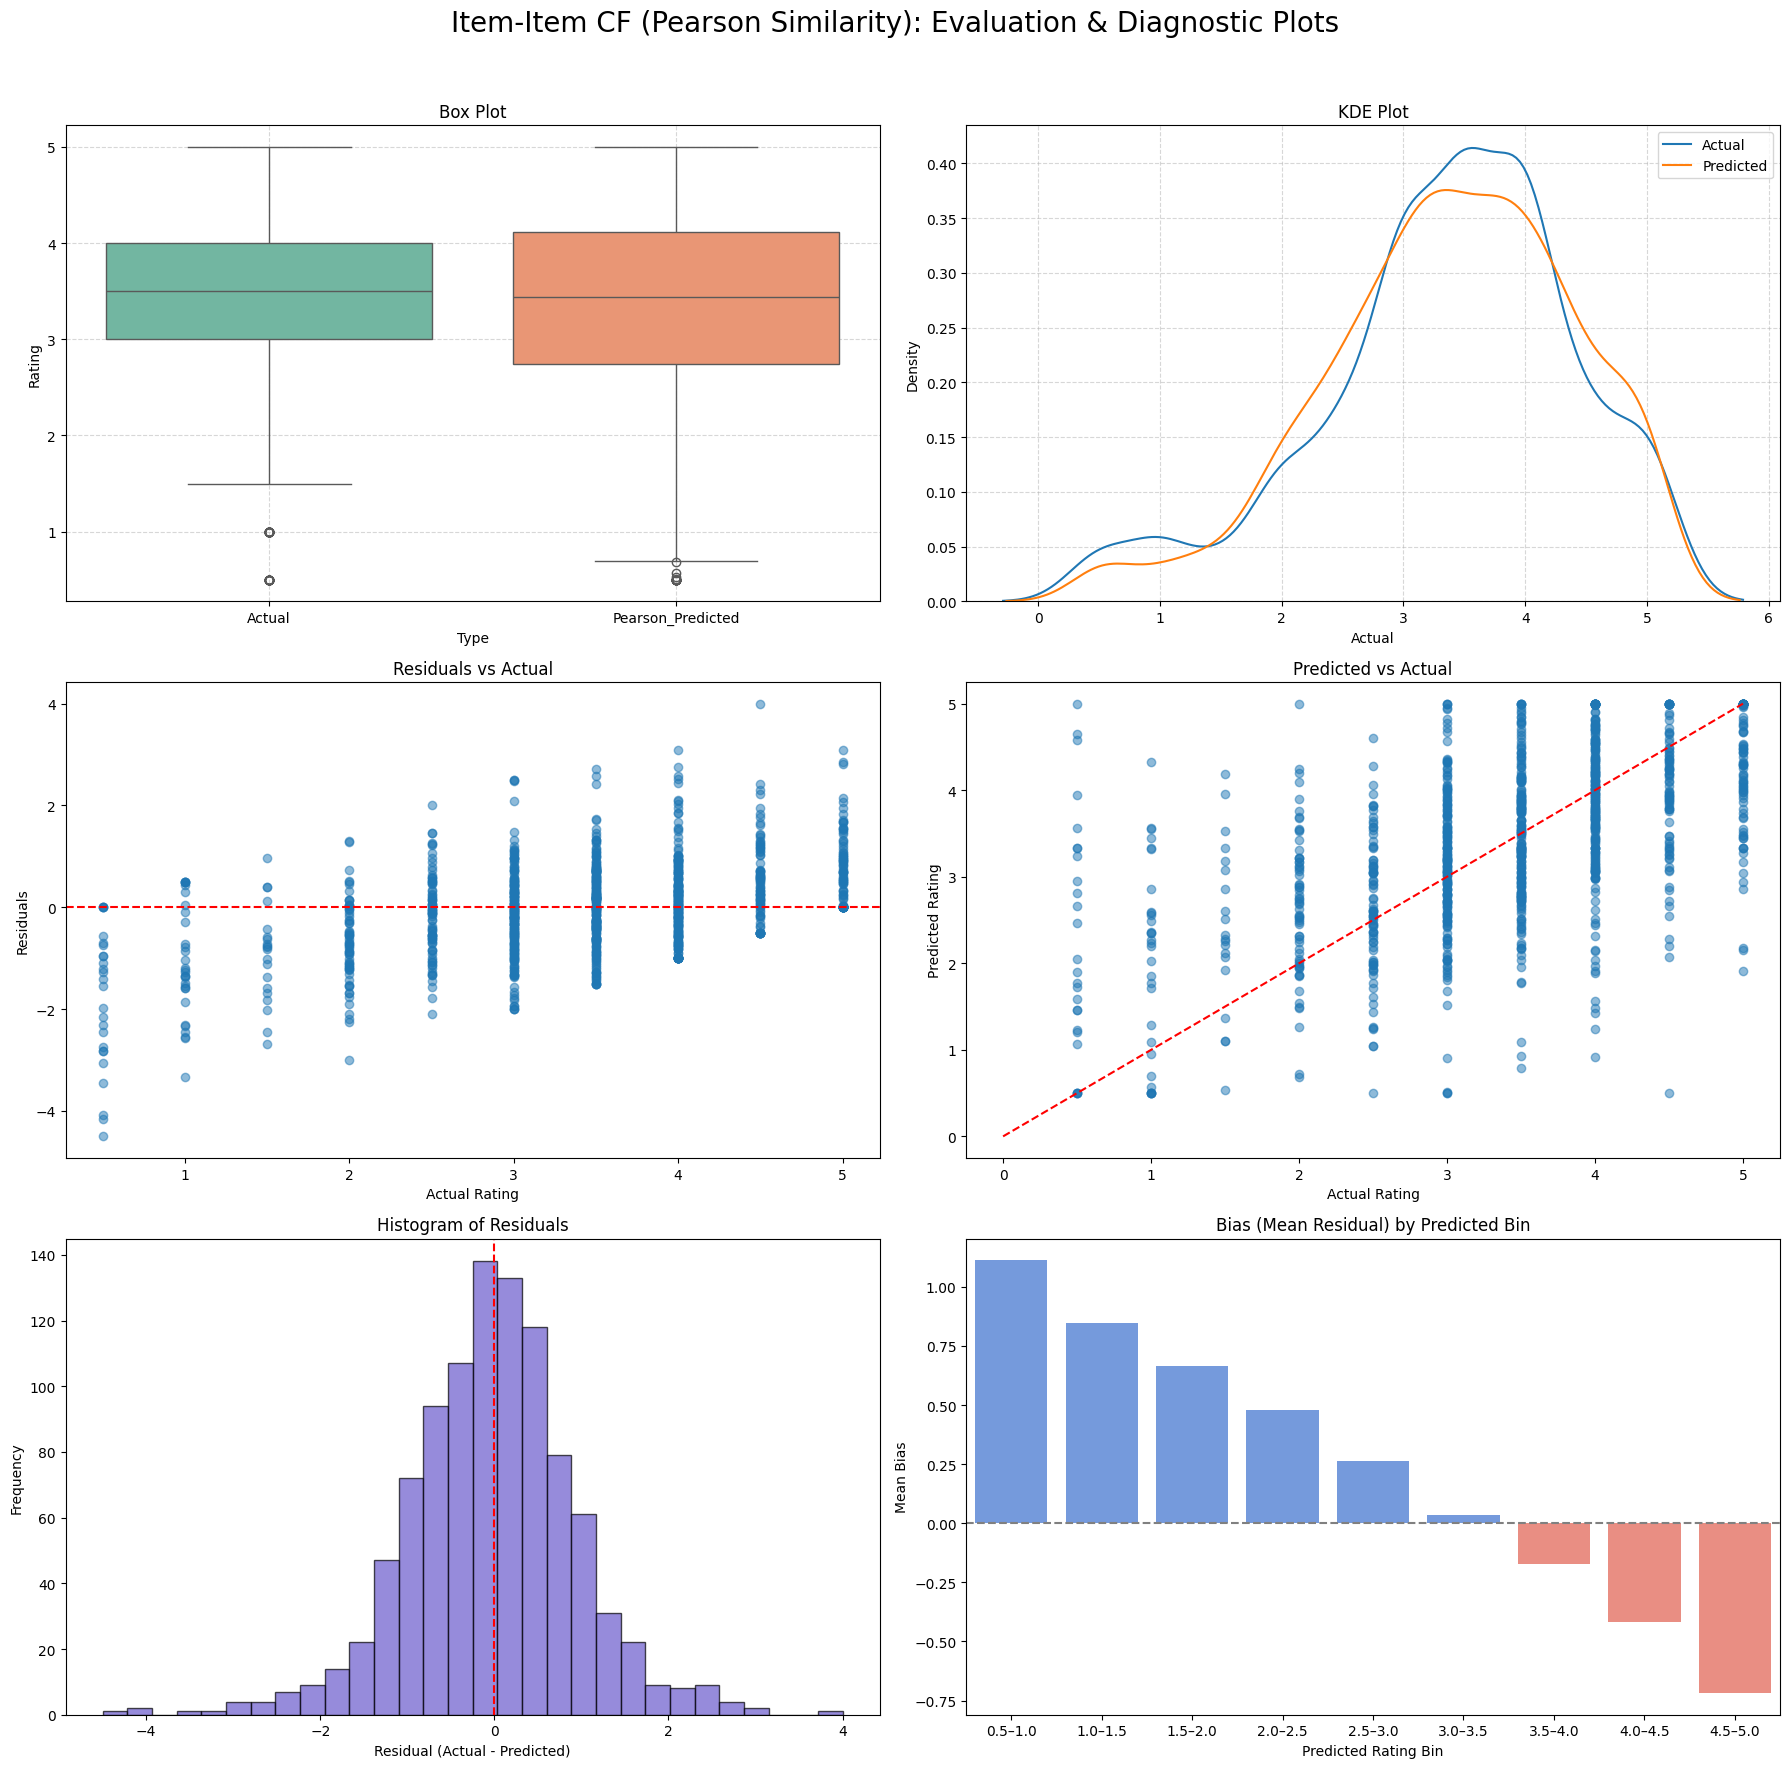

In [7]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_pearson = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_pearson = stratified_df.drop(train_ratings_pearson.index)

# --- Step 2: User-Item Matrix ---
train_ratings_pearson = train_ratings_pearson.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_pearson = train_ratings_pearson.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix_pearson.to_parquet("user_item_matrix_pearson.parquet")

# --- Step 3: Pearson Similarity Matrix ---
item_item_sim_pearson = user_item_matrix_pearson.corr(method='pearson', min_periods=3)
item_item_sim_pearson.to_parquet("item_item_sim_pearson.parquet")

# --- Step 4: Stats ---
global_mean_common = train_ratings_pearson['rating'].mean()
item_means_common = train_ratings_pearson.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_pearson.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Function ---
def predict_item_item_pearson(uid, mid):
    if uid not in user_item_matrix_pearson.index or mid not in item_item_sim_pearson.index:
        return global_mean_common

    sims = item_item_sim_pearson[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_pearson.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Generate Predictions ---
results_pearson = []
for _, row in tqdm(test_ratings_pearson.iterrows(), total=len(test_ratings_pearson)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_pearson(uid, mid)
    results_pearson.append([uid, mid, actual, pred])

viz_df_pearson = pd.DataFrame(results_pearson, columns=['userId', 'movieId', 'Actual', 'Pearson_Predicted'])

# --- Step 7: Evaluation ---
rmse_pearson = np.sqrt(mean_squared_error(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted']))
mae_pearson = mean_absolute_error(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted'])
r2_pearson = r2_score(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted'])

print(f"Item-Item CF (Pearson Similarity):\nRMSE={rmse_pearson:.4f}, MAE={mae_pearson:.4f}, R²={r2_pearson:.4f}")

# --- Step 8+: Faceted Evaluation & Bias Visualization for Pearson CF ---
viz_sample_pearson = viz_df_pearson.sample(n=min(len(viz_df_pearson), 1000), random_state=42)
box_data = viz_sample_pearson[['Actual', 'Pearson_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_pearson['Actual'] - viz_sample_pearson['Pearson_Predicted']

# Bin-based bias summary
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_pearson['pred_bin'] = pd.cut(viz_df_pearson['Pearson_Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)

bias_summary_pearson = (
    viz_df_pearson
    .groupby('pred_bin')
    .agg(Mean_Residual=('Actual', lambda x: (x - viz_df_pearson.loc[x.index, 'Pearson_Predicted']).mean()))
    .reset_index()
)

# --- Create Faceted Plot Layout ---
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("Item-Item CF (Pearson Similarity): Evaluation & Diagnostic Plots", fontsize=20)

# 1. Box Plot
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(viz_sample_pearson['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_pearson['Pearson_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residuals vs Actual
axs[1, 0].scatter(viz_sample_pearson['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# 4. Predicted vs Actual
axs[1, 1].scatter(viz_sample_pearson['Actual'], viz_sample_pearson['Pearson_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# 5. Histogram of Residuals
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# 6. Bias Plot (Mean Residual by Bin)
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary_pearson['Mean_Residual']]
sns.barplot(data=bias_summary_pearson, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[2, 1])
axs[2, 1].axhline(0, linestyle='--', color='gray')
axs[2, 1].set_title("Bias (Mean Residual) by Predicted Bin")
axs[2, 1].set_xlabel("Predicted Rating Bin")
axs[2, 1].set_ylabel("Mean Bias")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### ***5. Hybrid Recommender System (User-User CF + Content-Based Filtering)***

**Methodology for Hybrid Recommender System (CF + CB)**

**1. Genre-Based Content Matrix**

* Encodes movie genres into a one-hot matrix using only movies present in the training set.

**2. Similarity Computation**

* Computes cosine similarity between users using the rating matrix.
* Computes cosine similarity between items using their genre vectors.

**3. Hybrid Prediction Logic**

* For a test case, retrieves similar users who have rated the target item and computes a collaborative prediction using their residuals.
* Separately, retrieves similar items the user has rated and computes a content-based prediction.
* Final prediction is a weighted average of the two components (e.g., 50% CF + 50% CB).

**4. Fallback Handling**

* Uses global or user/item averages when similarity matches are insufficient.

**5. Clipping and Output**

* Ensures predictions fall within the valid rating range.
* Predictions are then evaluated using standard error metrics like RMSE, MAE, and R².


100%|██████████| 26080/26080 [03:38<00:00, 119.47it/s]
/tmp/ipython-input-8-1475731711.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  viz_df_hybrid.groupby('pred_bin')
/tmp/ipython-input-8-1475731711.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', palette='Set2', ax=axs[0, 0])


Hybrid CF (CB + CF):
RMSE=0.8760, MAE=0.6612, R²=0.3150


/tmp/ipython-input-8-1475731711.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='Predicted Bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


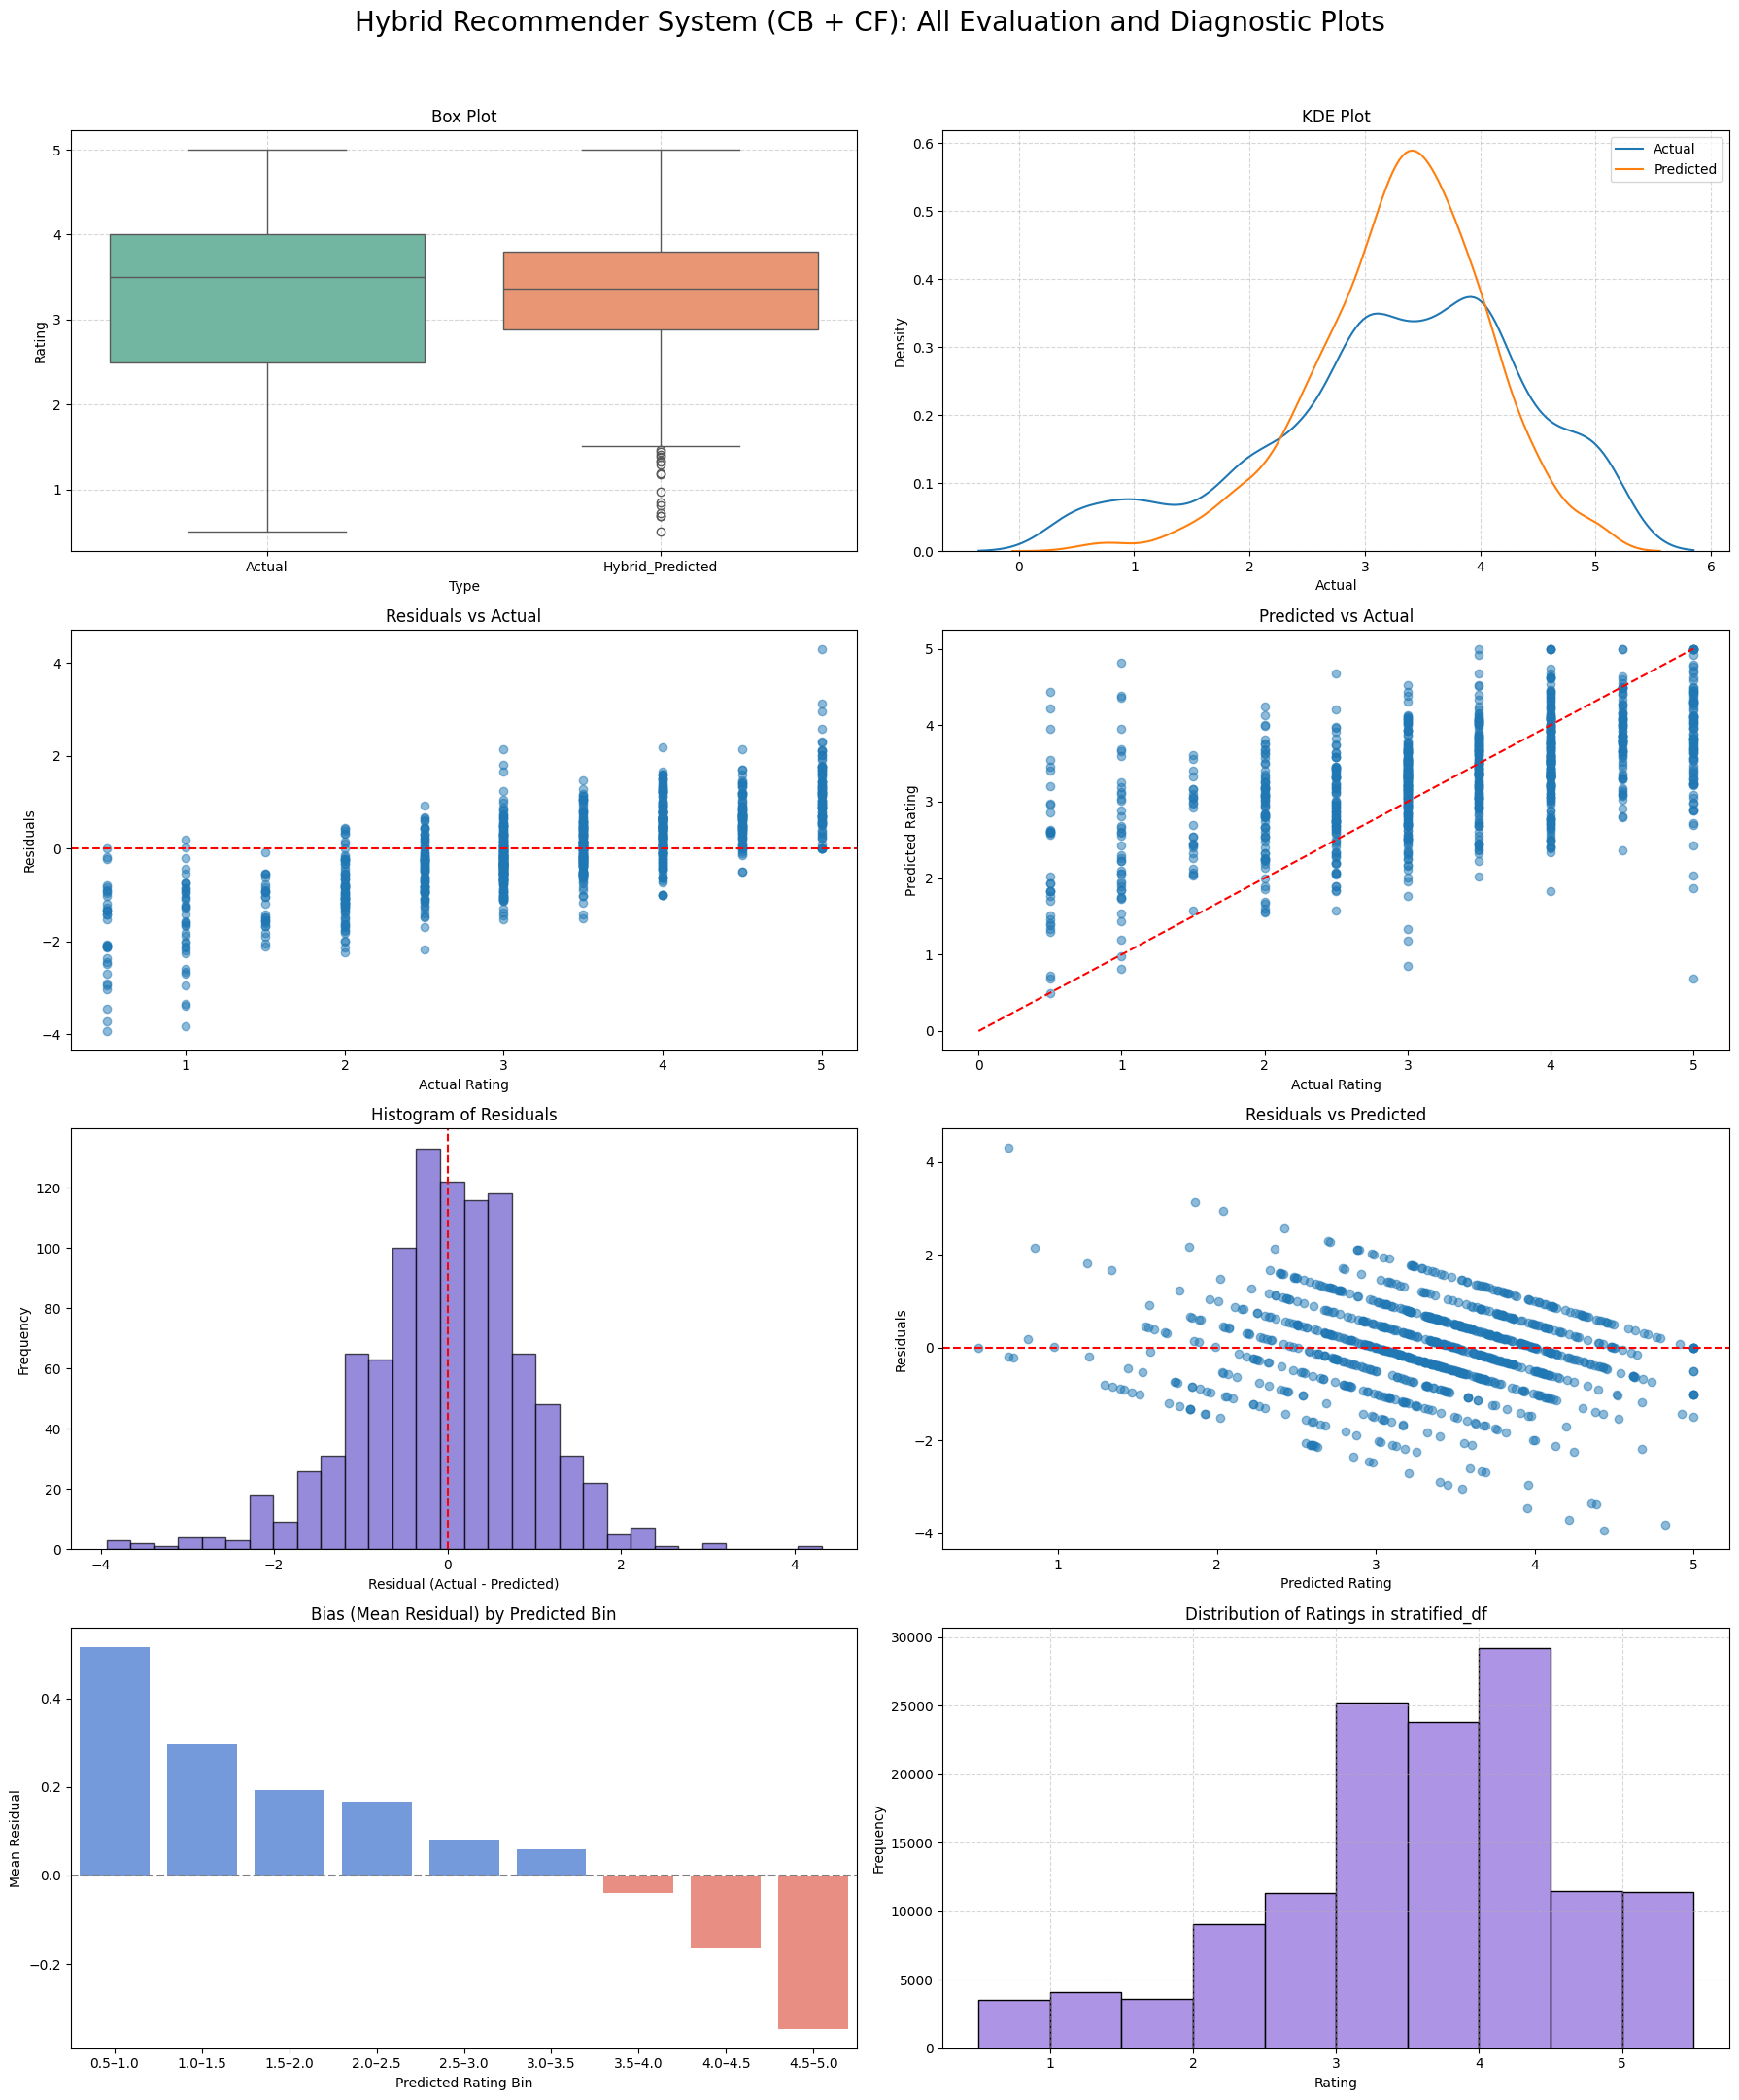

In [8]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_hybrid = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_hybrid = stratified_df.drop(train_ratings_hybrid.index)

# --- Step 2: User-Item Matrix ---
train_ratings_hybrid = train_ratings_hybrid.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_hybrid = train_ratings_hybrid.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Genre One-Hot Encoding (Based only on training movies) ---
train_movie_ids = train_ratings_hybrid['movieId'].unique()
genres_encoded = stratified_df[stratified_df['movieId'].isin(train_movie_ids)][['movieId', 'genres']].drop_duplicates()
genres_onehot = genres_encoded.set_index('movieId')['genres'].str.get_dummies(sep='|')
genres_onehot = genres_onehot.loc[~genres_onehot.index.duplicated(keep='first')]

# --- Step 4: Save Inputs ---
user_item_matrix_hybrid.to_parquet("user_item_matrix_hybrid.parquet")
genres_onehot.to_parquet("genres_onehot_hybrid.parquet")

# --- Step 5: Reload Inputs ---
user_item_matrix_hybrid = pd.read_parquet("user_item_matrix_hybrid.parquet")
genres_onehot = pd.read_parquet("genres_onehot_hybrid.parquet")

# --- Step 6: Statistics ---
global_mean_hybrid = train_ratings_hybrid['rating'].mean()
user_means_hybrid = train_ratings_hybrid.groupby('userId')['rating'].mean()
item_means_hybrid = train_ratings_hybrid.groupby('movieId')['rating'].mean()

# --- Step 7: Similarity Matrices ---
user_user_sim_hybrid = pd.DataFrame(
    cosine_similarity(user_item_matrix_hybrid.fillna(0)),
    index=user_item_matrix_hybrid.index,
    columns=user_item_matrix_hybrid.index
)

item_content_sim_hybrid = pd.DataFrame(
    cosine_similarity(genres_onehot.fillna(0)),
    index=genres_onehot.index,
    columns=genres_onehot.index
)

# --- Step 8: Filter test set for valid users and movies (must appear in training) ---
test_ratings_hybrid = test_ratings_hybrid[
    test_ratings_hybrid['movieId'].isin(genres_onehot.index) &
    test_ratings_hybrid['userId'].isin(user_item_matrix_hybrid.index)
]

# --- Step 9: Prediction Function ---
def predict_hybrid(uid, mid, alpha=0.5):
    if uid not in user_item_matrix_hybrid.index or \
       mid not in genres_onehot.index or \
       mid not in item_content_sim_hybrid.index or \
       uid not in user_user_sim_hybrid.index:
        return global_mean_hybrid

    # --- User-User CF ---
    sims_user = user_user_sim_hybrid.loc[uid].drop(uid, errors='ignore')
    raters = user_item_matrix_hybrid[mid].dropna()
    sims_user = sims_user.loc[sims_user.index.intersection(raters.index)]

    if not sims_user.empty:
        ratings = raters[sims_user.index]
        weights_user = sims_user / sims_user.abs().sum()
        cf_pred = user_means_hybrid.get(uid, global_mean_hybrid) + (weights_user * (ratings - user_means_hybrid[sims_user.index])).sum()
    else:
        cf_pred = user_means_hybrid.get(uid, global_mean_hybrid)

    # --- Content-Based ---
    sims_item = item_content_sim_hybrid.loc[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_hybrid.loc[uid].dropna()
    sims_item = sims_item.loc[sims_item.index.intersection(rated_items.index)]

    if not sims_item.empty:
        weights_item = sims_item / sims_item.abs().sum()
        cb_pred = item_means_hybrid.get(mid, global_mean_hybrid) + (weights_item * (rated_items[sims_item.index] - item_means_hybrid[sims_item.index])).sum()
    else:
        cb_pred = item_means_hybrid.get(mid, global_mean_hybrid)

    final_pred = alpha * cf_pred + (1 - alpha) * cb_pred
    return np.clip(final_pred, 0.5, 5.0)

# --- Step 10: Prediction Loop ---
results_hybrid = []
for _, row in tqdm(test_ratings_hybrid.iterrows(), total=len(test_ratings_hybrid)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_hybrid(uid, mid)
    results_hybrid.append([uid, mid, actual, pred])

viz_df_hybrid = pd.DataFrame(results_hybrid, columns=['userId', 'movieId', 'Actual', 'Hybrid_Predicted'])

# --- Step 11: Evaluation ---
rmse_hybrid = np.sqrt(mean_squared_error(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted']))
mae_hybrid = mean_absolute_error(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted'])
r2_hybrid = r2_score(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted'])
print(f"Hybrid CF (CB + CF):\nRMSE={rmse_hybrid:.4f}, MAE={mae_hybrid:.4f}, R²={r2_hybrid:.4f}")

# --- Step 12: 8-Faceted Visualization for Hybrid Recommender ---
viz_sample_hybrid = viz_df_hybrid.sample(n=min(len(viz_df_hybrid), 1000), random_state=42)
box_data = viz_sample_hybrid[['Actual', 'Hybrid_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_hybrid['Actual'] - viz_sample_hybrid['Hybrid_Predicted']

# Define bins for bias analysis
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_hybrid['pred_bin'] = pd.cut(
    viz_df_hybrid['Hybrid_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Bias summary
bias_summary = (
    viz_df_hybrid.groupby('pred_bin')
    .agg(Mean_Residual=('Actual', lambda x: (x - viz_df_hybrid.loc[x.index, 'Hybrid_Predicted']).mean()))
    .reindex(bin_labels)
    .reset_index()
    .rename(columns={'pred_bin': 'Predicted Bin'})
)

# Rating distribution
rating_distribution = stratified_df['rating']

# --- Faceted Layout ---
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
fig.suptitle("Hybrid Recommender System (CB + CF): All Evaluation and Diagnostic Plots", fontsize=20)

# 1. Box Plot
sns.boxplot(data=box_data, x='Type', y='Rating', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(viz_sample_hybrid['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_hybrid['Hybrid_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residuals vs Actual
axs[1, 0].scatter(viz_sample_hybrid['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# 4. Predicted vs Actual
axs[1, 1].scatter(viz_sample_hybrid['Actual'], viz_sample_hybrid['Hybrid_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# 5. Histogram of Residuals
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# 6. Residuals vs Predicted
axs[2, 1].scatter(viz_sample_hybrid['Hybrid_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# 7. Bias by Predicted Bin
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='Predicted Bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Residual")

# 8. Rating Distribution
sns.histplot(rating_distribution, bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Here is a concise comparison between the **Hybrid Recommender (CB + CF)** model and the best of the previous models, which is the **Shrinkage-Aware Item-Item CF**:

**Prediction Spread**
Shrinkage-aware predictions are narrowly centered around the mean, avoiding extremes. The hybrid model has a slightly wider spread, offering better reach to lower ratings while still favoring the center. Hybrid is more expressive; shrinkage is more conservative.

**Residual Patterns**
Shrinkage-aware residuals are tightly distributed with minimal skew. The hybrid model shows more residual variance and a broader funnel in residuals vs. predicted, indicating greater prediction flexibility but slightly reduced precision.

**Bias and Calibration**
Shrinkage-aware bias is flatter across bins, with near-zero mean residuals from 2.5 to 4.5. The hybrid model introduces stronger bias at the extremes—overpredicting low ratings and underpredicting high ones. Shrinkage is better calibrated overall.

**Rating Distribution Impact**
Both are influenced by the right-skewed rating distribution. Shrinkage responds by regularizing predictions toward the center. The hybrid model compensates using content-based information, improving coverage but increasing edge error.

**Conclusion**
Shrinkage-Aware Item-Item CF is better calibrated, more stable, and yields lower residual error. The Hybrid model provides greater flexibility and coverage, especially for rare items, but sacrifices some calibration and error control. Shrinkage remains the better performer in terms of accuracy and reliability.


## **User-User Collaborative Filtering**

### ***1. User-User Collaborative Filtering with Cosine Similarity***

**Methodology**

**1. Mean-Centered Similarity Matrix**

* Constructs a user-user similarity matrix using cosine similarity on the user-item matrix after subtracting each user's mean rating.
* This captures relative preferences rather than absolute ratings.

**2. Persistent Matrix Storage**

* Saves the user-item matrix, user means, item means, and cosine similarity matrix to disk as `.parquet` files for reuse and reproducibility.

**3. Bias-Aware Prediction**

* Makes predictions by identifying users similar to the target user who rated the item.
* Combines their residuals (from their own mean) using cosine similarity as weights.
* Adjusts the final prediction using user and item bias.

**4. Fallback Logic**

* If no similar users rated the item, the system falls back to a baseline combining the user’s average and the item’s average.

**5. Output Clipping**

* Ensures predicted ratings are clipped to the allowed range (0.5 to 5.0).

---

Let me know if you'd like this side-by-side with another approach.


User-User CF with Cosine Similarity:
RMSE = 0.9373, MAE = 0.7099, R² = 0.2178


/tmp/ipython-input-9-3911874983.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')
/tmp/ipython-input-9-3911874983.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data_user_user, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-9-3911874983.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary_user_user, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


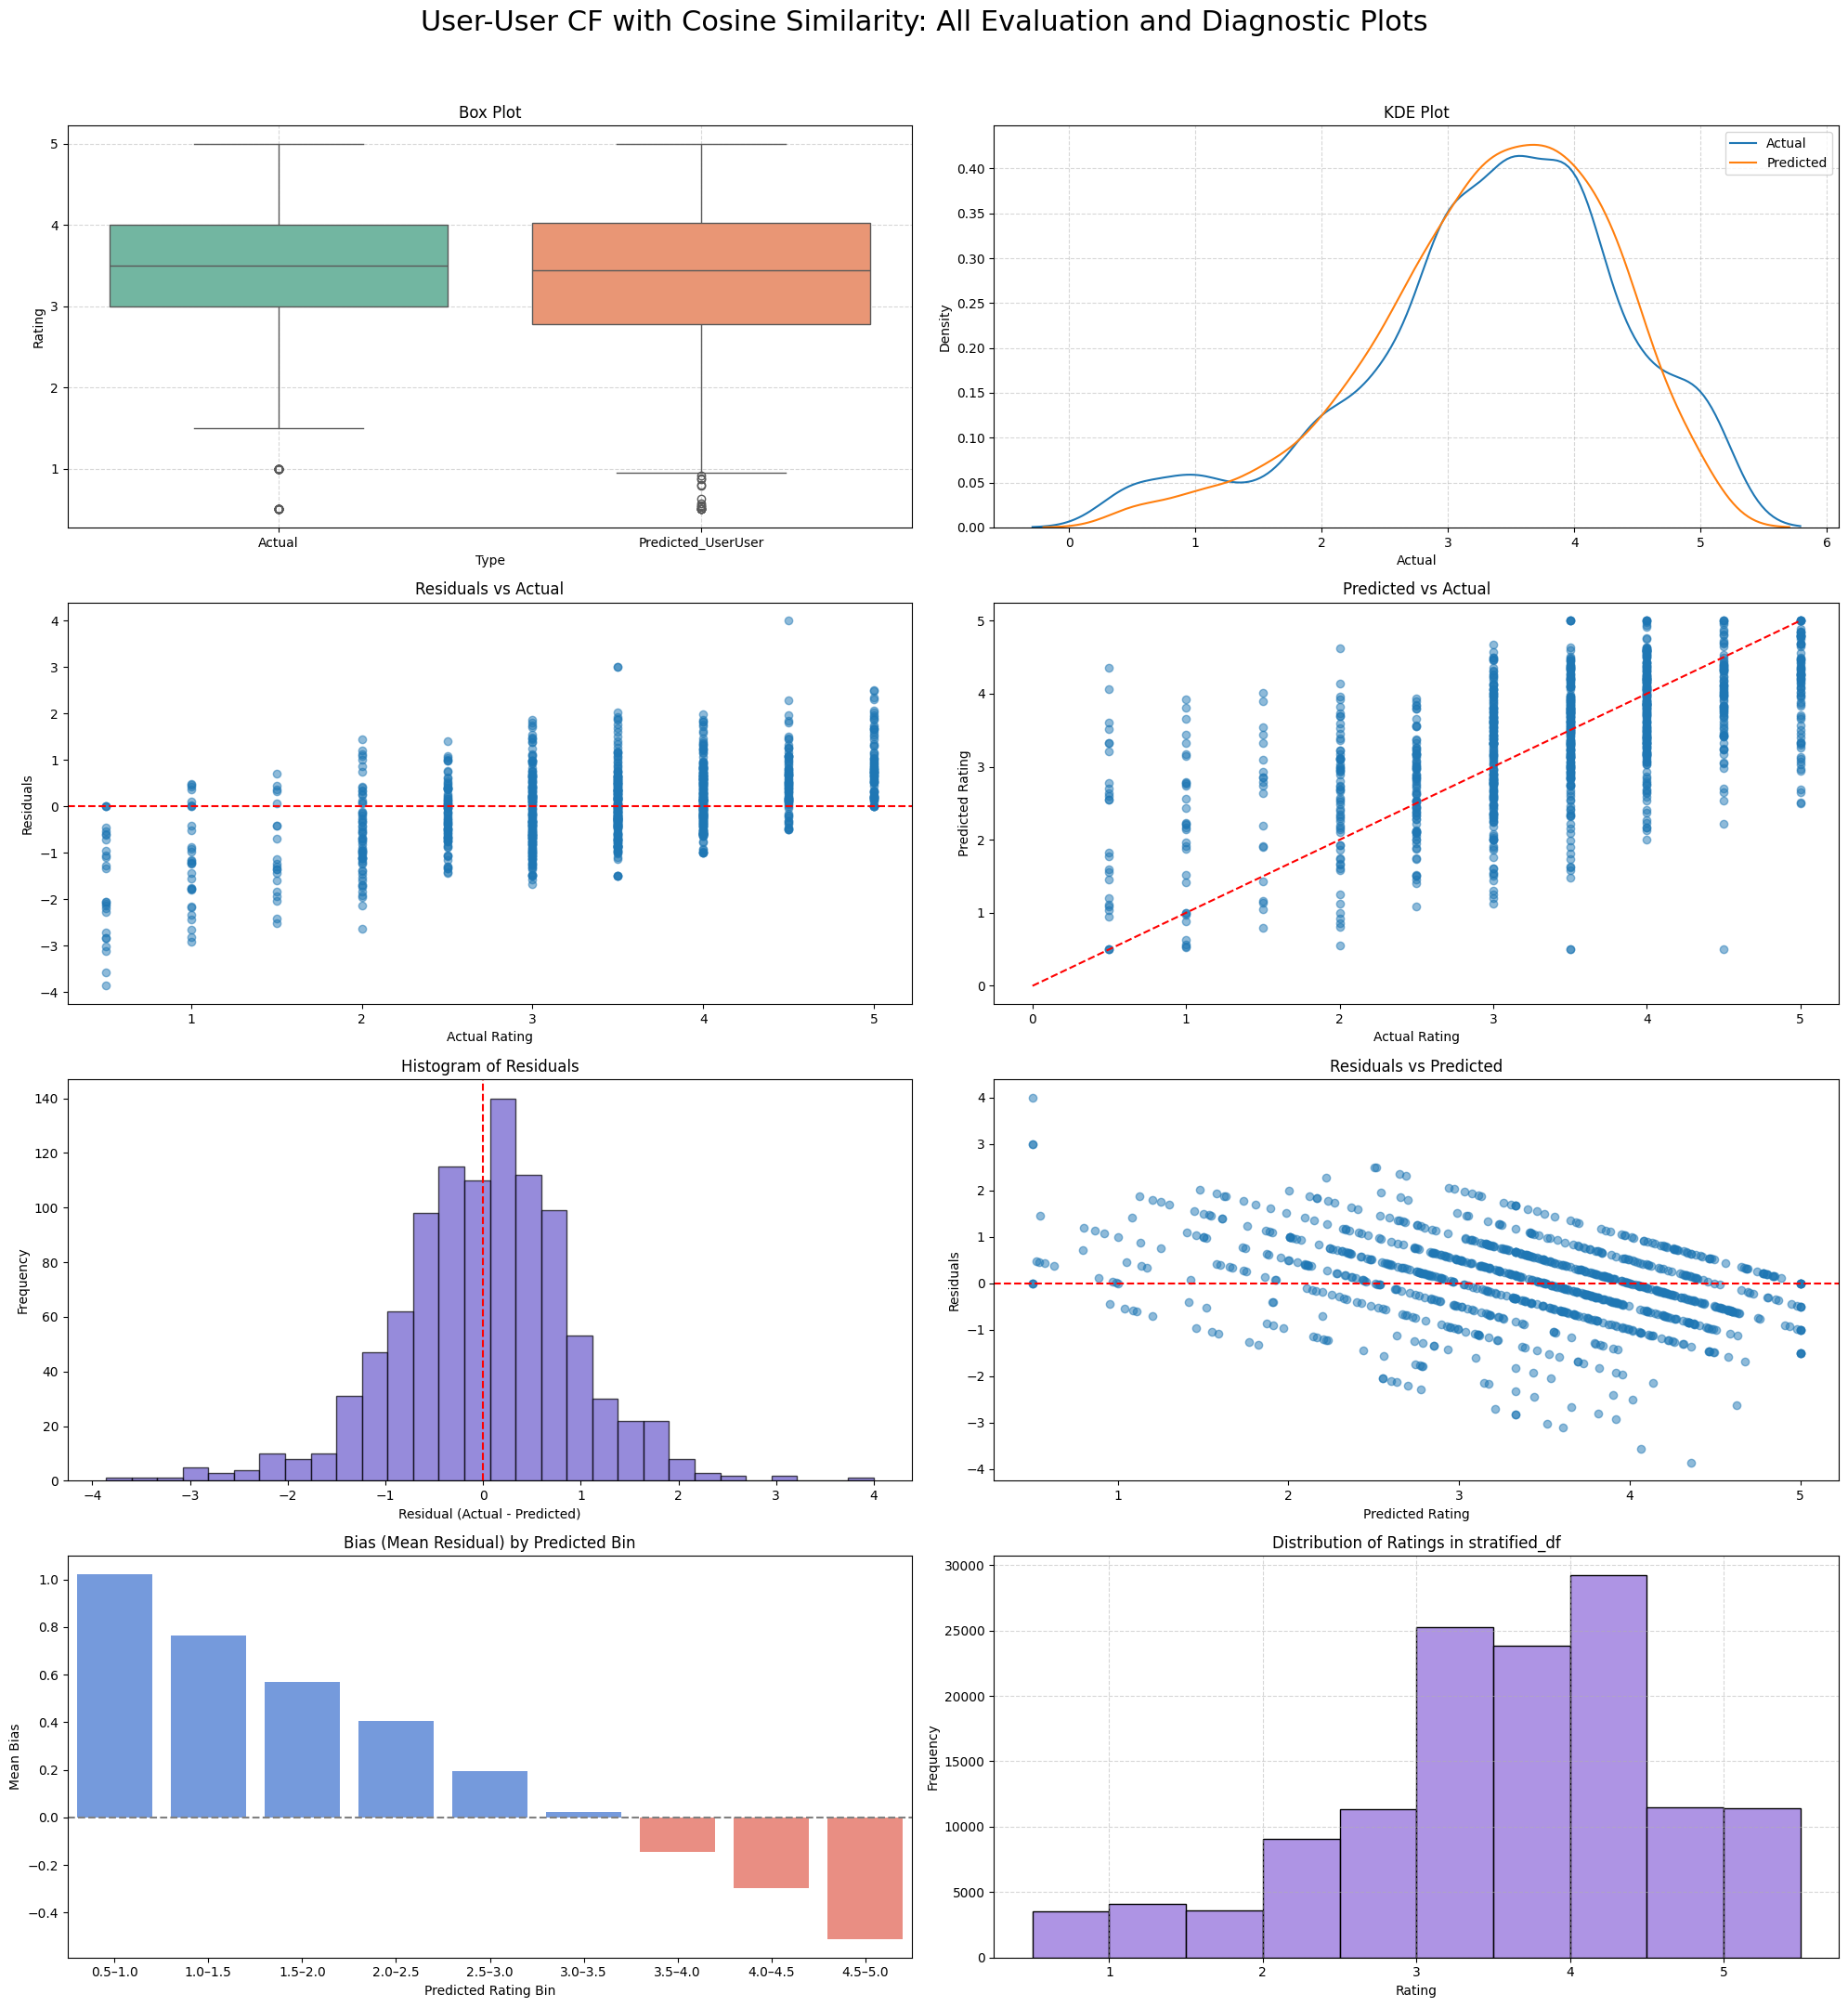

In [9]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix & Common Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Save to Parquet ---
user_item_matrix.to_parquet("user_item_matrix_user_user.parquet")
item_means.to_frame("item_mean").to_parquet("item_means_user_user.parquet")
user_means.to_frame("user_mean").to_parquet("user_means_user_user.parquet")

# --- Step 4: Compute and Save Similarity Matrix ---
user_item_centered = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)
user_user_sim_matrix_cosine = pd.DataFrame(
    cosine_similarity(user_item_centered.fillna(0)),
    index=user_item_centered.index,
    columns=user_item_centered.index
)
user_user_sim_matrix_cosine.to_parquet("user_user_sim_matrix_cosine.parquet")

# --- Step 5: Load Matrices ---
user_item_matrix = pd.read_parquet("user_item_matrix_user_user.parquet")
item_means = pd.read_parquet("item_means_user_user.parquet")['item_mean']
user_means = pd.read_parquet("user_means_user_user.parquet")['user_mean']
user_user_sim_matrix_cosine = pd.read_parquet("user_user_sim_matrix_cosine.parquet")

# --- Step 6: Prediction Function ---
def predict_rating_user_user_cosine(uid, mid):
    if mid not in user_item_matrix.columns or uid not in user_user_sim_matrix_cosine.index:
        return global_mean

    sims = user_user_sim_matrix_cosine.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Parallel Predictions ---
def parallel_predict_user_user(row):
    uid, mid, actual = row.userId, row.movieId, row.rating
    pred = predict_rating_user_user_cosine(uid, mid)
    return [uid, mid, actual, pred]

results_user_user = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict_user_user)(row) for row in test_ratings.itertuples(index=False)
)

viz_df_user_user = pd.DataFrame(results_user_user, columns=['userId', 'movieId', 'Actual', 'Predicted_UserUser'])

# --- Step 8: Evaluation ---
rmse_uu = np.sqrt(mean_squared_error(viz_df_user_user['Actual'], viz_df_user_user['Predicted_UserUser']))
mae_uu = mean_absolute_error(viz_df_user_user['Actual'], viz_df_user_user['Predicted_UserUser'])
r2_uu = r2_score(viz_df_user_user['Actual'], viz_df_user_user['Predicted_UserUser'])

print(f"User-User CF with Cosine Similarity:\nRMSE = {rmse_uu:.4f}, MAE = {mae_uu:.4f}, R² = {r2_uu:.4f}")

# --- Step 9: Plotting All Diagnostics in One Faceted Grid ---
viz_sample_user_user = viz_df_user_user.sample(n=min(len(viz_df_user_user), 1000), random_state=42)
residuals_user_user = viz_sample_user_user['Actual'] - viz_sample_user_user['Predicted_UserUser']
box_data_user_user = viz_sample_user_user[['Actual', 'Predicted_UserUser']].melt(var_name='Type', value_name='Rating')

# Bias Summary
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_user_user['pred_bin'] = pd.cut(viz_df_user_user['Predicted_UserUser'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df_user_user['Residual_UserUser'] = viz_df_user_user['Actual'] - viz_df_user_user['Predicted_UserUser']
bias_summary_user_user = (
    viz_df_user_user
    .groupby('pred_bin')
    .agg(Mean_Residual=('Residual_UserUser', 'mean'))
    .reset_index()
)

# Create Faceted Plot Grid
fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("User-User CF with Cosine Similarity: All Evaluation and Diagnostic Plots", fontsize=22)

# Plot 1: Box Plot
sns.boxplot(data=box_data_user_user, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: KDE Plot
sns.kdeplot(viz_sample_user_user['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_user_user['Predicted_UserUser'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Residuals vs Actual
axs[1, 0].scatter(viz_sample_user_user['Actual'], residuals_user_user, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# Plot 4: Predicted vs Actual
axs[1, 1].scatter(viz_sample_user_user['Actual'], viz_sample_user_user['Predicted_UserUser'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# Plot 5: Histogram of Residuals
axs[2, 0].hist(residuals_user_user, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# Plot 6: Residuals vs Predicted
axs[2, 1].scatter(viz_sample_user_user['Predicted_UserUser'], residuals_user_user, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# Plot 7: Bias by Predicted Bin
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary_user_user['Mean_Residual']]
sns.barplot(data=bias_summary_user_user, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Bias")

# Plot 8: Distribution of Ratings
sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### ***2. User-User Collaborative Filtering using Pearson Correlation***

**Methodology**

**1. Correlation-Based Similarity Matrix**

* Builds a user-user similarity matrix using Pearson correlation on the user-item rating matrix.
* Automatically captures rating trends by centering ratings internally.
* Self-similarity (diagonal) is excluded during prediction.

**2. Bias-Aware Prediction**

* Makes predictions by aggregating residuals (deviations from user averages) from similar users who rated the same item.
* Incorporates both user and item biases in the final estimate.

**3. Fallback Logic**

* If no similar users rated the item, it defaults to a baseline that combines user and item average ratings.

**4. Clipping**

* Predictions are restricted to stay within the observed rating range of 0.5 to 5.0.

---

Let me know if you'd like the same structure for any other model.



User-User CF with Correlation Similarity:
RMSE = 0.9301, MAE = 0.7027, R² = 0.2298


/tmp/ipython-input-10-2766779122.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')
/tmp/ipython-input-10-2766779122.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-10-2766779122.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


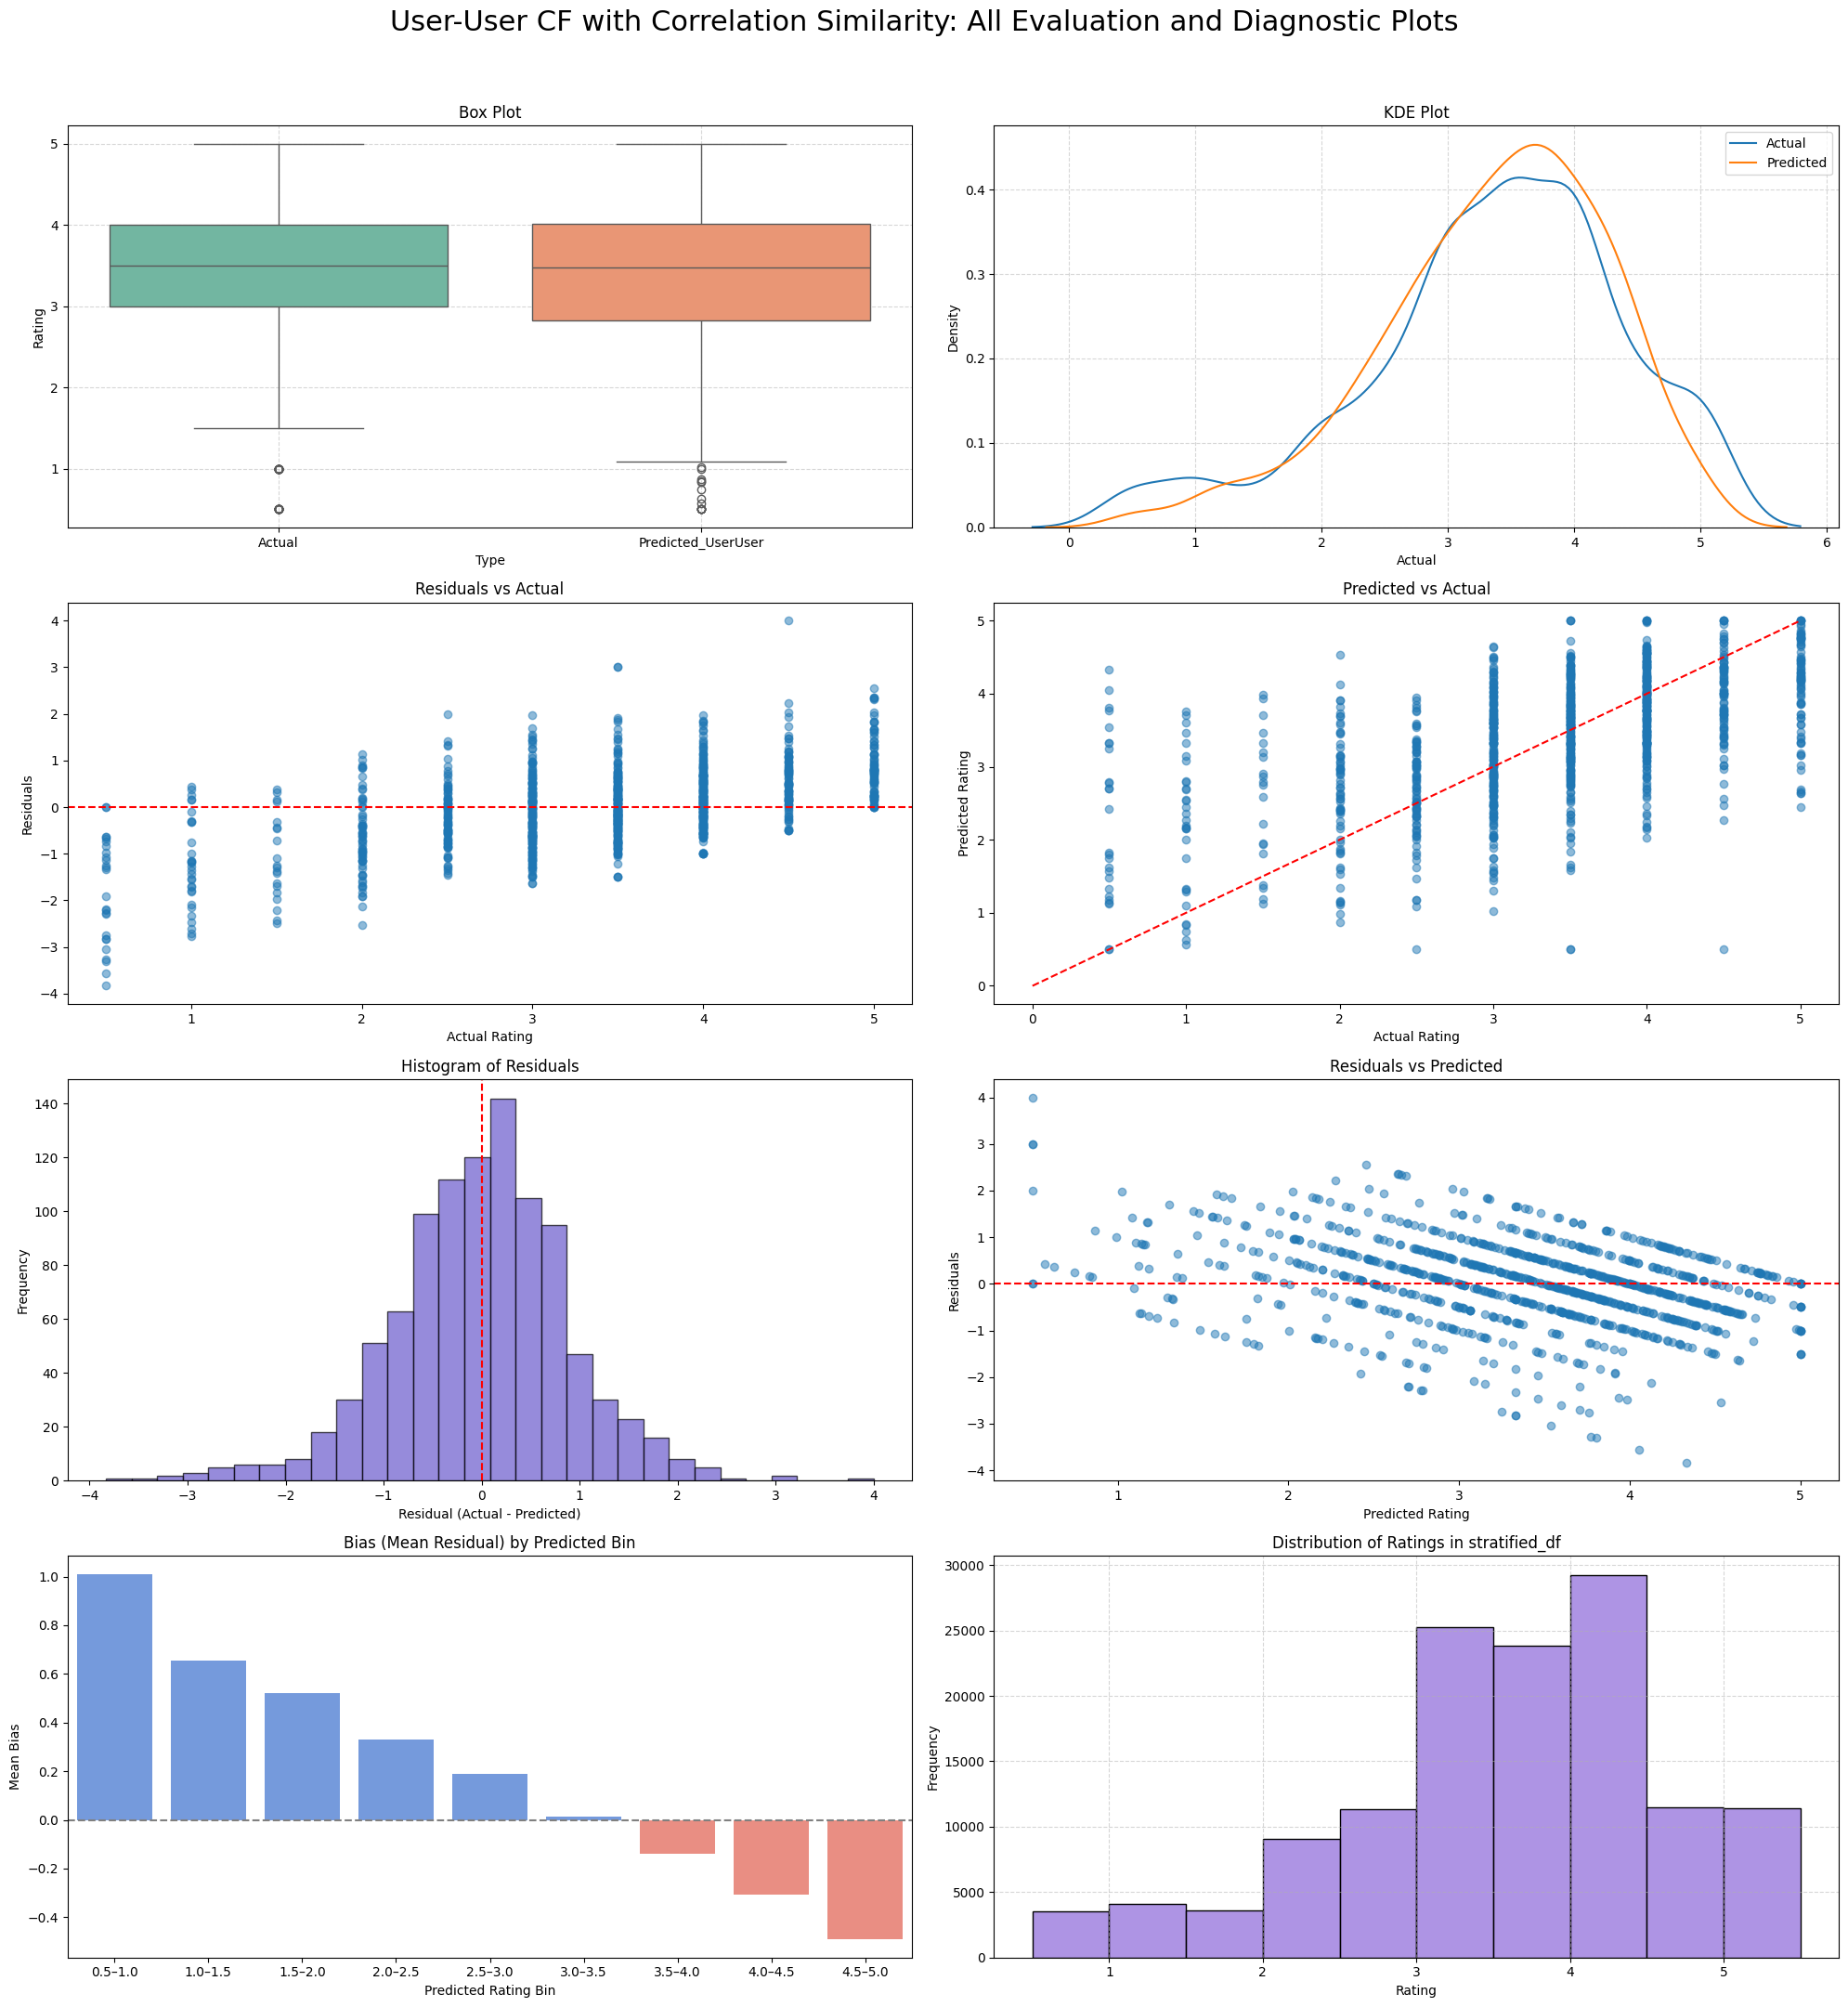

In [10]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix & Common Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Correlation Similarity Matrix ---
user_user_sim_matrix_corr = user_item_matrix.T.corr(method='pearson').fillna(0)

# --- Step 4: Prediction Function ---
def predict_rating_user_user_corr(uid, mid):
    if mid not in user_item_matrix.columns or uid not in user_user_sim_matrix_corr.index:
        return global_mean

    sims = user_user_sim_matrix_corr.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Predict in Parallel ---
def parallel_predict_user_user(row):
    uid, mid, actual = row.userId, row.movieId, row.rating
    pred = predict_rating_user_user_corr(uid, mid)
    return [uid, mid, actual, pred]

results_user_user_corr = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict_user_user)(row) for row in test_ratings.itertuples(index=False)
)

viz_df_user_user_corr = pd.DataFrame(results_user_user_corr, columns=['userId', 'movieId', 'Actual', 'Predicted_UserUser'])

# --- Step 6: Evaluation ---
rmse_corr = np.sqrt(mean_squared_error(viz_df_user_user_corr['Actual'], viz_df_user_user_corr['Predicted_UserUser']))
mae_corr = mean_absolute_error(viz_df_user_user_corr['Actual'], viz_df_user_user_corr['Predicted_UserUser'])
r2_corr = r2_score(viz_df_user_user_corr['Actual'], viz_df_user_user_corr['Predicted_UserUser'])

print(f"User-User CF with Correlation Similarity:\nRMSE = {rmse_corr:.4f}, MAE = {mae_corr:.4f}, R² = {r2_corr:.4f}")

# --- Step 7: Diagnostic Plots ---
viz_sample = viz_df_user_user_corr.sample(n=min(len(viz_df_user_user_corr), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted_UserUser']
box_data = viz_sample[['Actual', 'Predicted_UserUser']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_user_user_corr['pred_bin'] = pd.cut(viz_df_user_user_corr['Predicted_UserUser'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df_user_user_corr['Residual_UserUser'] = viz_df_user_user_corr['Actual'] - viz_df_user_user_corr['Predicted_UserUser']
bias_summary = (
    viz_df_user_user_corr
    .groupby('pred_bin')
    .agg(Mean_Residual=('Residual_UserUser', 'mean'))
    .reset_index()
)

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("User-User CF with Correlation Similarity: All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted_UserUser'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted_UserUser'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

axs[2, 1].scatter(viz_sample['Predicted_UserUser'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Bias")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ***3 User-User Collaborative Filtering using Shrinkage-Aware Cosine Similarity***

**Methodology**

**1. Interaction Matrix Creation**

* Builds a user-item matrix from training data using user ratings averaged per (user, item) pair.

**2. Shrinkage Adjustment for Similarity**

* Computes cosine similarity between users using a sparse matrix.
* Applies a shrinkage factor to the similarity based on the number of commonly rated items, reducing the influence of weak overlaps.

**3. Bias-Aware Predictions**

* Predictions combine user and item bias adjustments with weighted residuals from similar users.
* Weights are scaled by the similarity and the deviation of neighbor ratings from their own averages.

**4. Fallback Handling**

* When no neighbors have rated the target item, a fallback estimate using combined user and item biases is applied.

**5. Rating Clipping**

* Ensures predicted ratings remain within the valid scale boundaries.



100%|██████████| 26567/26567 [01:16<00:00, 349.19it/s]
/tmp/ipython-input-11-1758533965.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()


User-User Shrinkage-Aware Cosine CF:
RMSE=1.0041, MAE=0.7622, R²=0.1024


/tmp/ipython-input-11-1758533965.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-11-1758533965.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


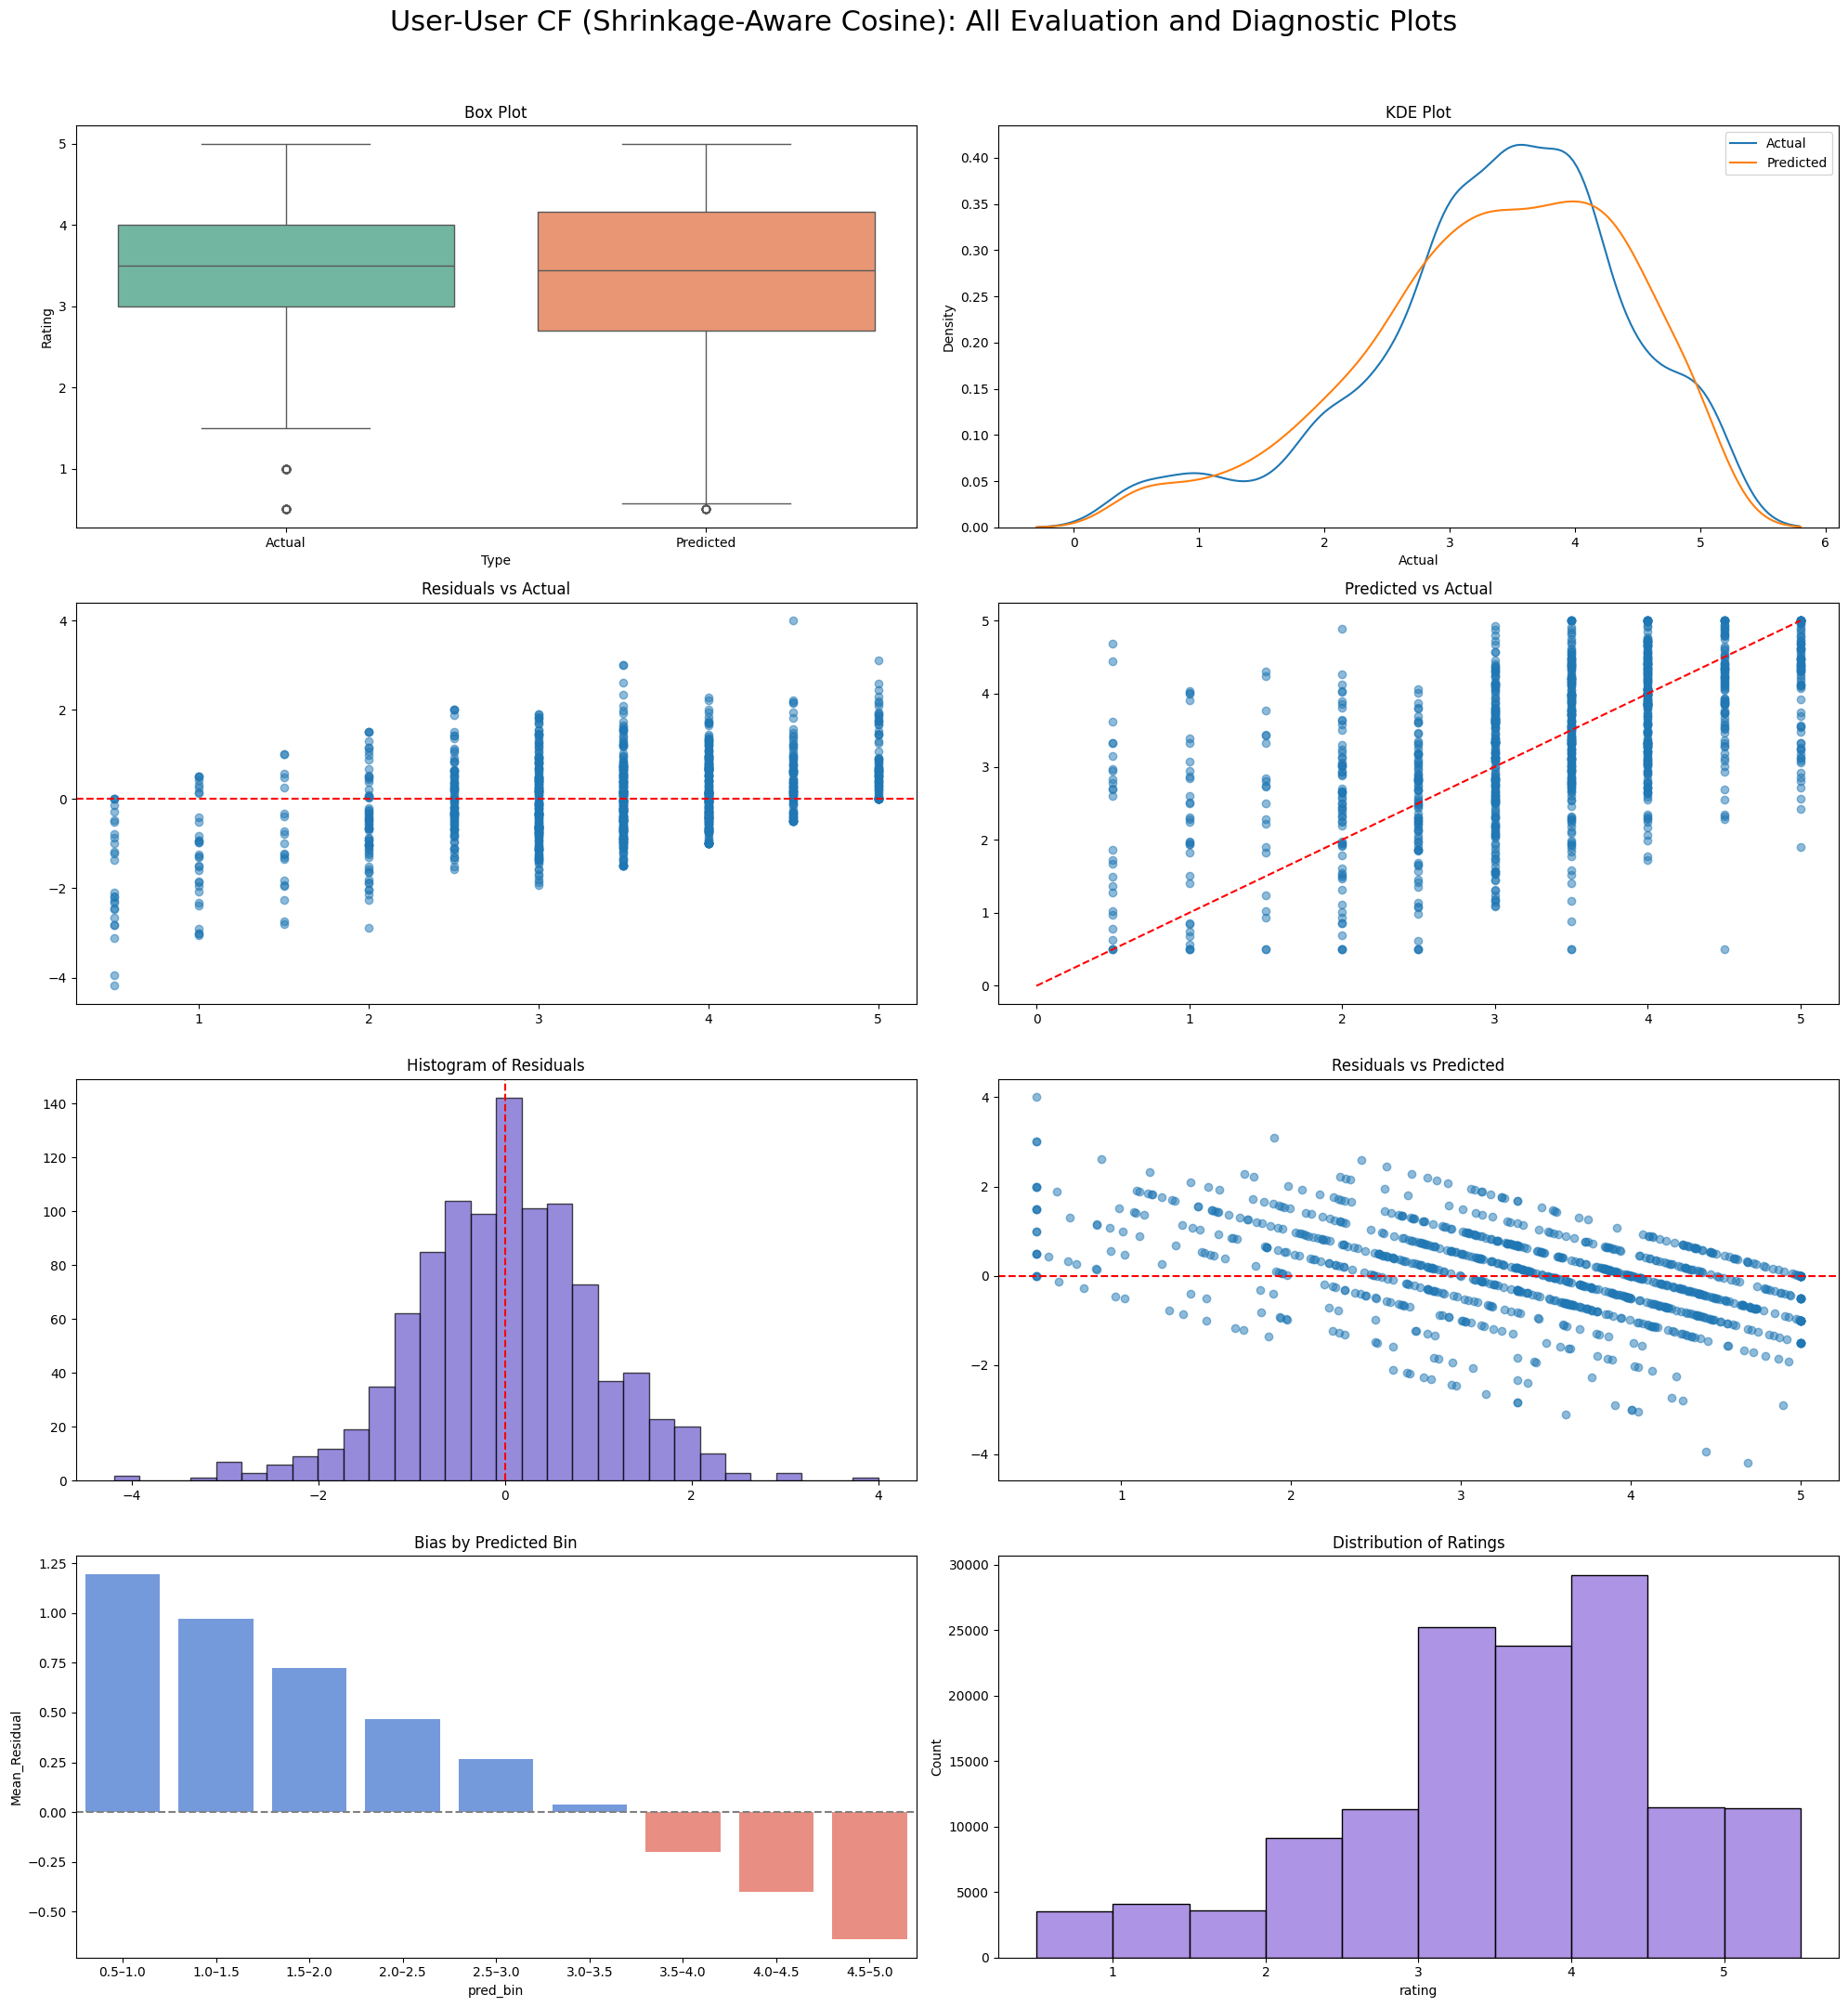

In [11]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Prepare Data ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_df = stratified_df.sample(frac=0.8, random_state=42)
test_df = stratified_df.drop(train_df.index)

train_df = train_df.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Shrinkage-Aware Cosine Similarity ---
reg_lambda = 10

binary_matrix = user_item_matrix.notna().astype(int)
binary_sparse = csr_matrix(binary_matrix.values)
filled_sparse = csr_matrix(user_item_matrix.fillna(0).values)

common_counts = binary_sparse @ binary_sparse.T
cosine_sim_raw = 1 - pairwise_distances(filled_sparse, metric='cosine')
cosine_sim_df = pd.DataFrame(cosine_sim_raw, index=user_item_matrix.index, columns=user_item_matrix.index)

shrink_factor = common_counts.toarray() / (common_counts.toarray() + reg_lambda)
user_user_sim = cosine_sim_df * shrink_factor

# --- Step 3: Bias Stats ---
global_mean = train_df['rating'].mean()
user_means = train_df.groupby('userId')['rating'].mean()
item_means = train_df.groupby('movieId')['rating'].mean()

# --- Step 4: Prediction Function ---
def predict_user_user_shrink(uid, mid):
    if uid not in user_item_matrix.index or mid not in user_item_matrix.columns:
        return global_mean

    sims = user_user_sim.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Predict on Test Set ---
results = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_shrink(uid, mid)
    results.append([uid, mid, actual, pred])

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 6: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])

print(f"User-User Shrinkage-Aware Cosine CF:\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 7: Evaluation Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

# --- Faceted Plot Grid ---
fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("User-User CF (Shrinkage-Aware Cosine): All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Content-Based Filtering

### ***1 Content-Based Filtering using Genre Cosine Similarity with Bias Correction***

**Methodology**

1. **Genre Encoding**:
   Each movie is represented as a binary (multi-hot) vector based on its genres. For example, a movie tagged with "Action|Comedy" would have 1s for those genres and 0s elsewhere.

2. **Similarity Computation**:
   Cosine similarity is computed between all movie pairs using their genre vectors:

   $$
   \text{sim}(i, j) = \frac{\vec{g}_i \cdot \vec{g}_j}{\|\vec{g}_i\| \cdot \|\vec{g}_j\|}
   $$

   where $\vec{g}_i$ and $\vec{g}_j$ are genre vectors for movies $i$ and $j$.

3. **Rating Prediction**:
   For user $u$ and target movie $i$, predicted rating is calculated using ratings the user has given to genre-similar movies:

   $$
   \hat{r}_{ui} = \mu + b_u + b_i + \sum_{j \in N(i)} w_{ij} \cdot (r_{uj} - \bar{r}_j)
   $$

   where:

   * $\mu$: global mean rating
   * $b_u = \bar{r}_u - \mu$: user bias
   * $b_i = \bar{r}_i - \mu$: item bias
   * $w_{ij} = \frac{\text{sim}(i,j)}{\sum_k |\text{sim}(i,k)|}$: normalized similarity
   * $N(i)$: set of movies rated by user $u$ that are similar to movie $i$


Content-Based CF with Cosine Similarity:
RMSE=1.0481, MAE=0.7872, R²=0.0220


/tmp/ipython-input-12-2166584869.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()
/tmp/ipython-input-12-2166584869.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-12-2166584869.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


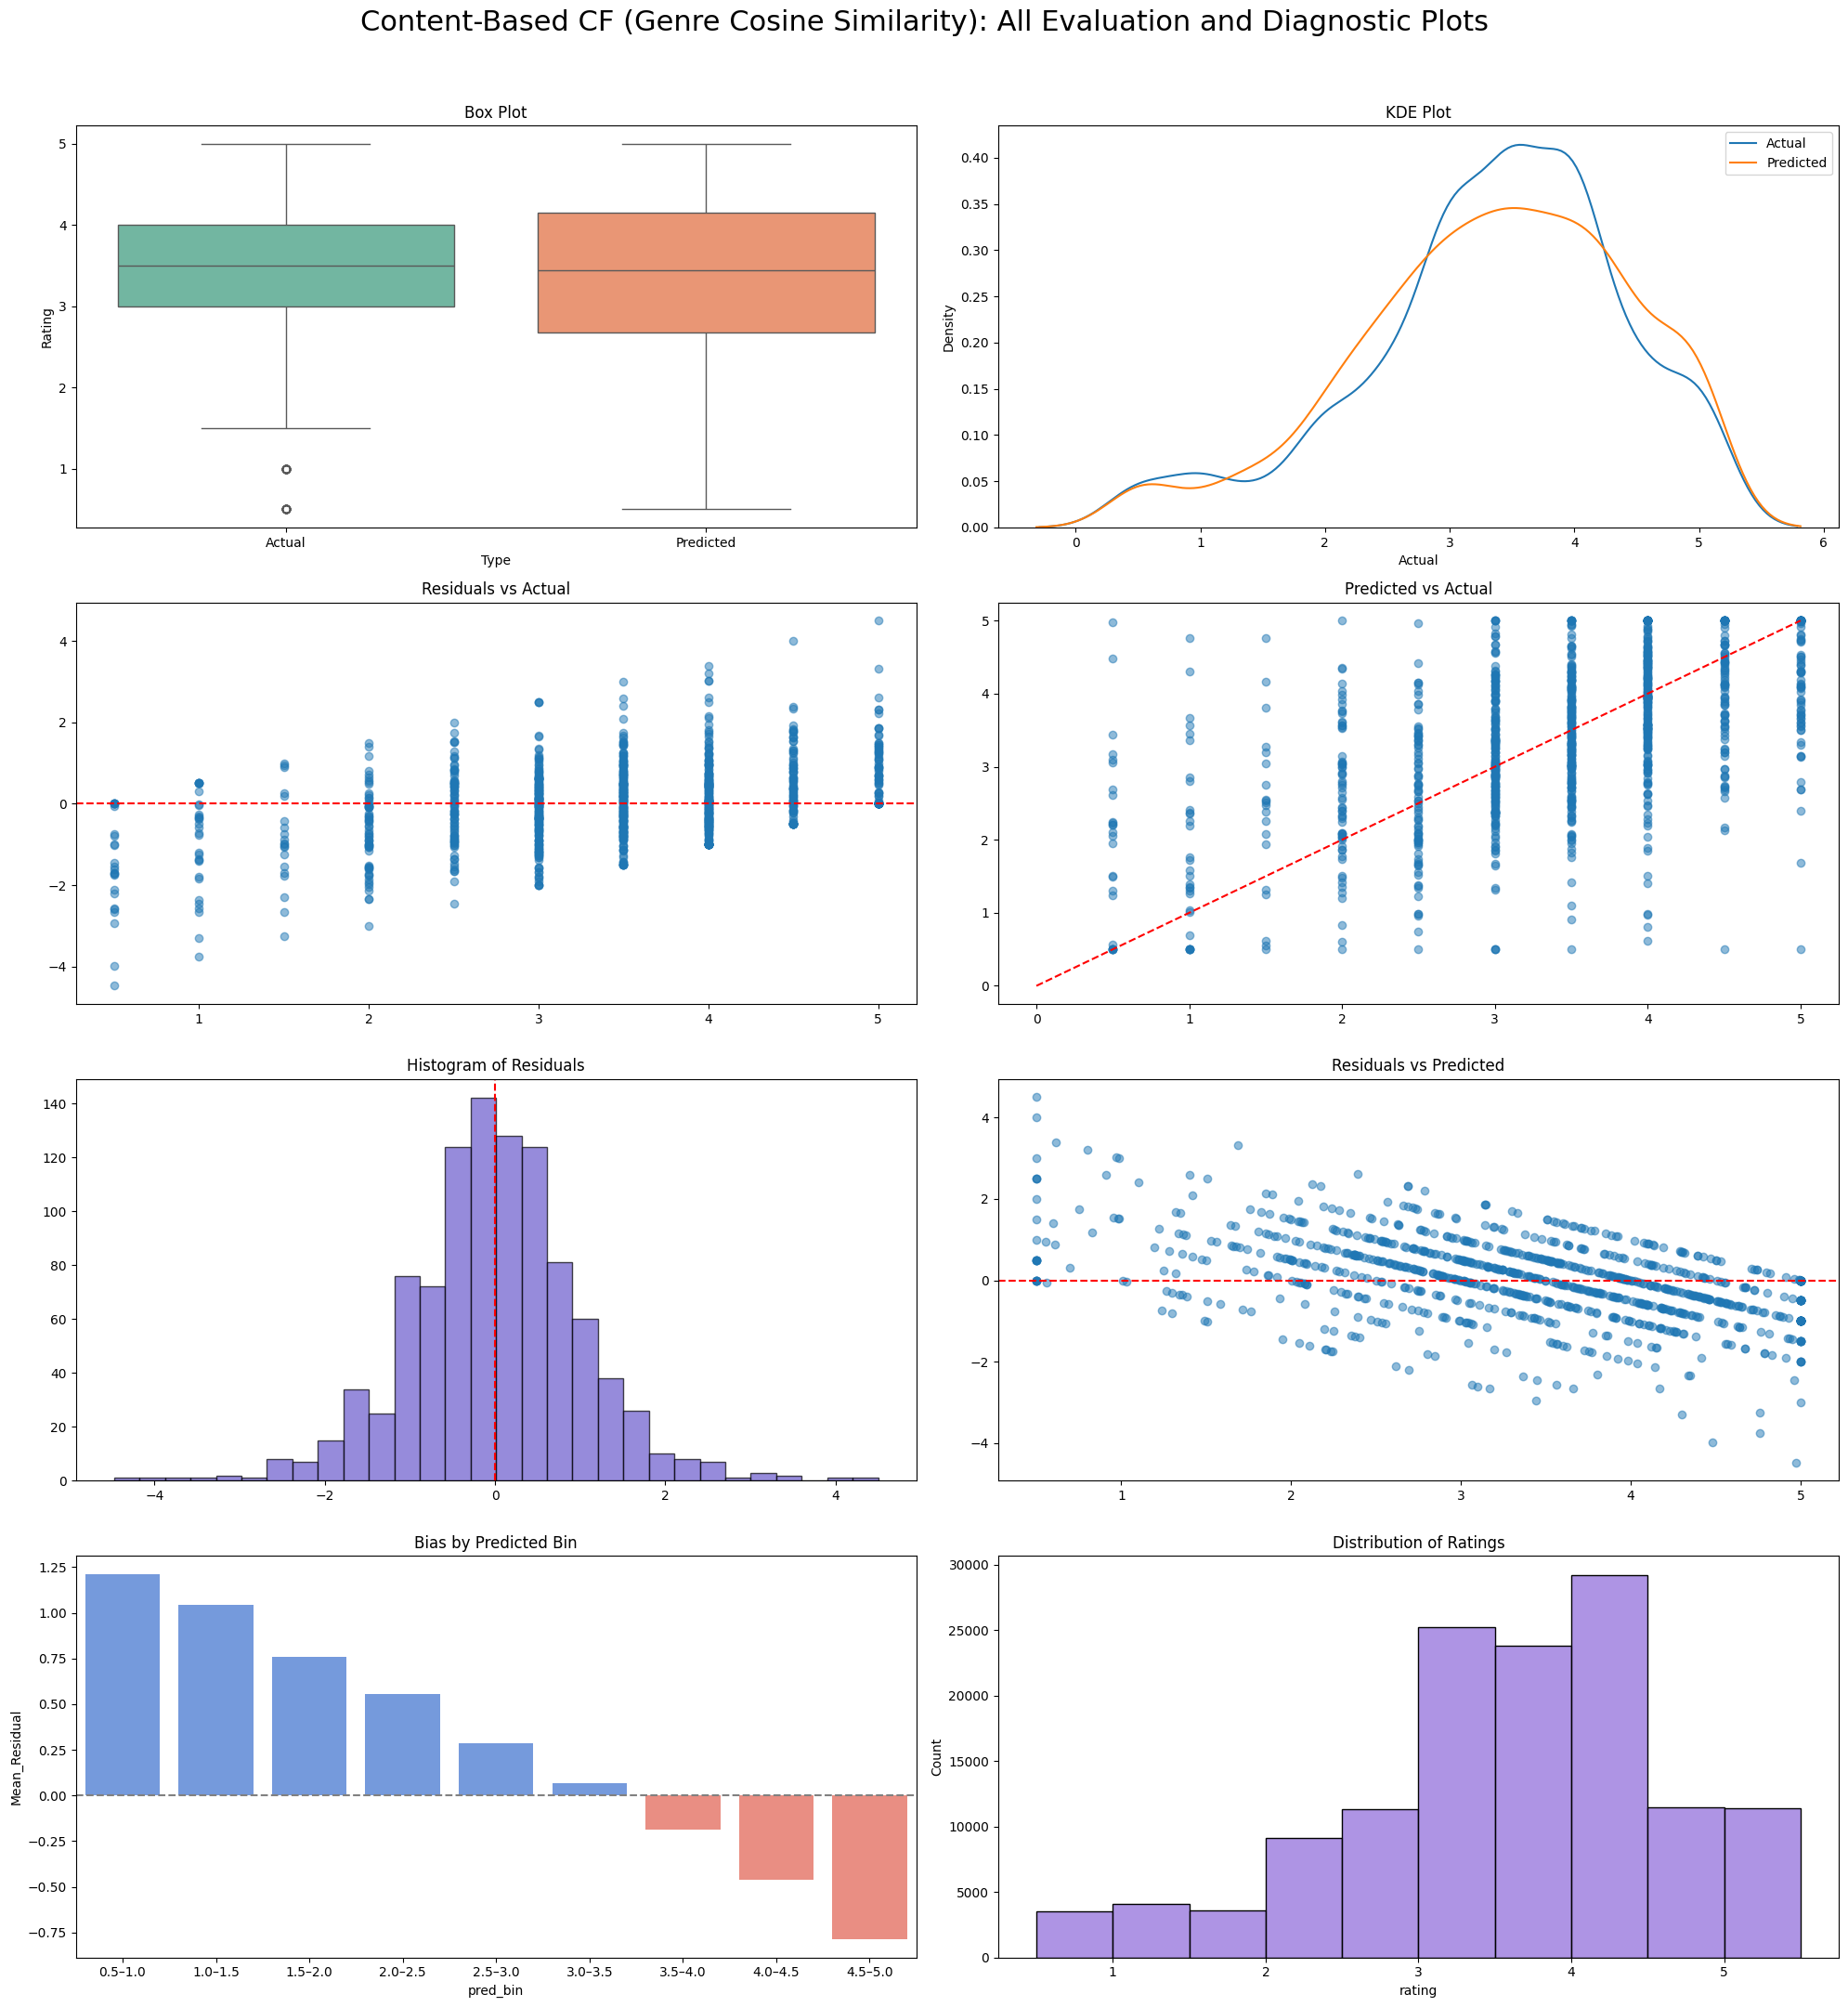

In [12]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix and Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: Genre Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates().set_index('movieId')
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_sim_matrix = pd.DataFrame(
    cosine_similarity(genre_onehot),
    index=genre_onehot.index,
    columns=genre_onehot.index
)

# --- Step 4: Prediction Function ---
def predict_content_based(uid, mid):
    if uid not in user_item_matrix.index or mid not in genre_sim_matrix.index:
        return global_mean

    user_ratings = user_item_matrix.loc[uid].dropna()
    rated_movies = user_ratings.index.intersection(genre_sim_matrix.index)
    if rated_movies.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    sims = genre_sim_matrix.loc[mid, rated_movies]
    weights = sims / sims.abs().sum()
    residuals = user_ratings[rated_movies] - item_means[rated_movies]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Predict on Test Set ---
results = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_content_based(uid, mid)
    results.append([uid, mid, actual, pred])

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 6: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])

print(f"Content-Based CF with Cosine Similarity:\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 7: Evaluation Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

# --- Faceted Plot Grid ---
fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Content-Based CF (Genre Cosine Similarity): All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


***Analysis: Content-Based Movie Recommender Using One-Hot Encoded Genre Vectors (Cosine Similarity)***

**Model Performance (Metrics):**

* *Uncentered Prediction:* RMSE=1.0462, MAE=0.7851, R²=0.0257
* *Centered Prediction:* RMSE=1.0096, MAE=0.7790, R²=0.0926
* *GenreOnly Prediction:* RMSE=1.1802, MAE=0.9737, R²=-0.2399

The centered model shows the best predictive performance overall with the lowest RMSE/MAE and highest (though still modest) R². The GenreOnly model performs worst, with a negative R², indicating it underperforms compared to simply predicting the mean.

**Rating Distribution and Box Plot (Top Right):**
All predicted distributions are slightly more compressed than the actual ratings, but:

* *Centered Prediction* aligns more closely with the true distribution than *Uncentered* or *GenreOnly*.
* *GenreOnly* underpredicts higher ratings and overpredicts lower ratings, which is also seen in its narrower box and lower median.

**KDE Plot (Bottom Left):**

* *Actual* ratings show a spread with a peak near 4.0.
* *Uncentered* and *Centered* KDEs approximate this shape, with the *Centered* line more closely matching the distribution of actual ratings.
* *GenreOnly* shows unrealistic density spikes around 3.0, confirming it's less effective at capturing true rating variation.

**Residuals (Bottom Right):**

* *Centered* predictions yield tighter residuals around 0 across all rating values, reinforcing its superior accuracy.
* *Uncentered* predictions show a similar pattern but with more dispersion.
* *GenreOnly* residuals are consistently biased low across most rating levels—indicative of its poor adaptability to user preferences.

**Conclusion:**
Centering user profiles yields notable improvements in performance and error consistency. The EDA plots (box, KDE, and residuals) all support the metric findings—centered profiles better capture rating behavior. The GenreOnly model lacks personalization and performs poorly, both statistically and visually.


### ***2 Content-Based Filtering using Genre Jaccard Similarity with Bias Correction***

1. **Genre Representation**:
   Each movie is encoded using multi-hot vectors from its genres. If a movie belongs to genres like *Drama* and *Thriller*, its binary vector has 1s in those positions.

2. **Similarity Calculation**:
   Jaccard similarity is calculated between every pair of movie genre vectors as follows:

   $$
   \text{sim}(i, j) = \frac{|g_i \cap g_j|}{|g_i \cup g_j|}
   $$

   where $g_i$ and $g_j$ are genre sets of movies $i$ and $j$, respectively.

3. **Prediction Rule**:
   To predict the rating of a user $u$ for a movie $i$, the algorithm identifies genre-similar movies $j$ rated by the user and computes:

   $$
   \hat{r}_{ui} = \mu + b_u + b_i + \sum_{j \in N(i)} w_{ij} \cdot (r_{uj} - \bar{r}_j)
   $$

   with:

   * $\mu$: global average rating
   * $b_u = \bar{r}_u - \mu$: user bias
   * $b_i = \bar{r}_i - \mu$: item bias
   * $w_{ij} = \frac{\text{sim}(i,j)}{\sum_k |\text{sim}(i,k)|}$: normalized similarity
   * $N(i)$: movies rated by user $u$ that are genre-similar to movie $i$

100%|██████████| 26567/26567 [00:45<00:00, 582.66it/s]


Content-Based CF with Jaccard Similarity:
RMSE=1.0533, MAE=0.7931, R²=0.0123


/tmp/ipython-input-13-3815969405.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()
/tmp/ipython-input-13-3815969405.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-13-3815969405.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


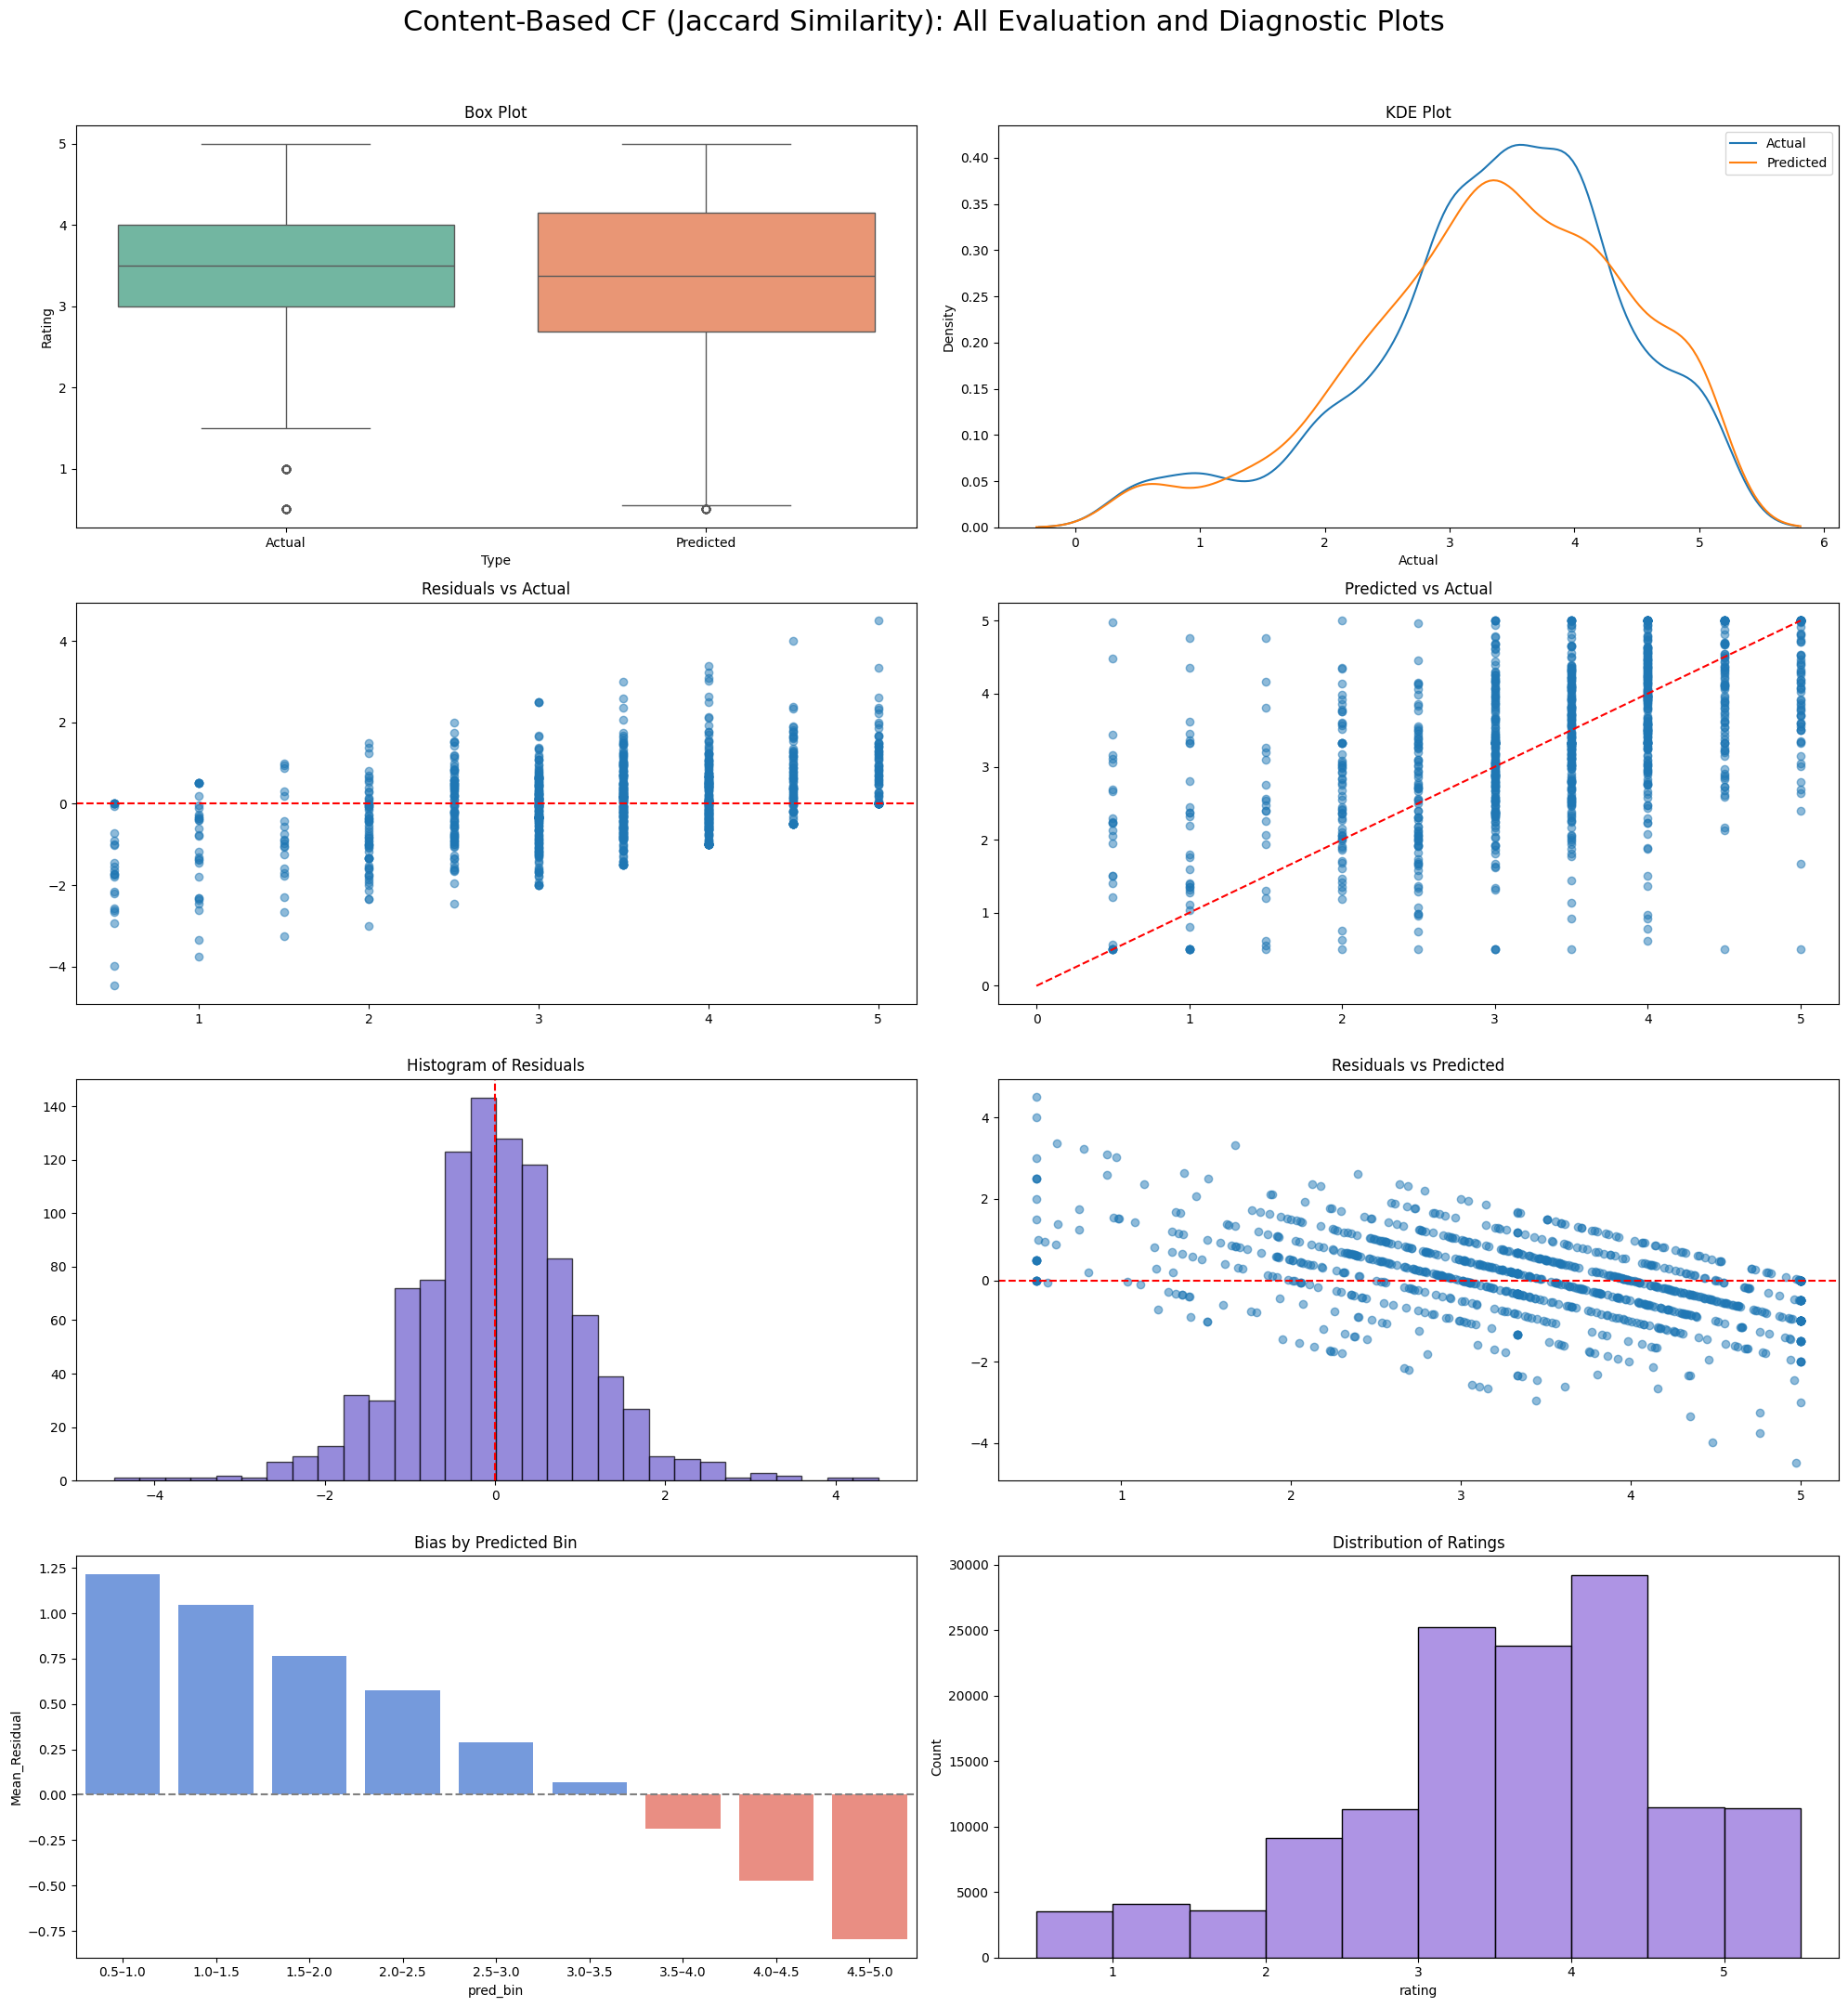

In [13]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score, mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix and Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: Genre Matrix (Multi-hot Encoding) ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates().set_index('movieId')
genre_multi_hot = movie_genres['genres'].str.get_dummies(sep='|')

# --- Step 4: Vectorized Jaccard Similarity Matrix ---
def fast_jaccard_matrix(X):
    X = X.astype(bool).astype(int)
    intersection = np.dot(X, X.T)
    row_sums = X.sum(axis=1).values.reshape(-1, 1)
    union = row_sums + row_sums.T - intersection
    sim_matrix = intersection / np.maximum(union, 1e-9)
    return pd.DataFrame(sim_matrix, index=X.index, columns=X.index)

genre_sim_jaccard = fast_jaccard_matrix(genre_multi_hot)

# --- Step 5: Parallel Prediction Function ---
def predict_jaccard(uid, mid):
    if uid not in user_item_matrix.index or mid not in genre_sim_jaccard.index:
        return global_mean

    user_ratings = user_item_matrix.loc[uid].dropna()
    rated_movies = user_ratings.index.intersection(genre_sim_jaccard.index)
    if rated_movies.empty:
        return global_mean

    sims = genre_sim_jaccard.loc[mid, rated_movies]
    if sims.abs().sum() == 0:
        return global_mean

    weights = sims / sims.abs().sum()
    residuals = user_ratings[rated_movies] - item_means[rated_movies]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Parallel Predictions ---
def parallel_predict(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_jaccard(uid, mid)
    return [uid, mid, actual, pred]

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict)(row) for _, row in tqdm(test_ratings.iterrows(), total=len(test_ratings))
)

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 7: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])

print(f"Content-Based CF with Jaccard Similarity:\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Content-Based CF (Jaccard Similarity): All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ***3 Content-Based Filtering using Genre TF-IDF Cosine Similarity with Bias Correction***

**Methodology**

1. **TF-IDF Genre Encoding**:
   Movie genres are encoded using Term Frequency–Inverse Document Frequency (TF-IDF), treating genre labels as textual tokens. This gives higher weight to rare genres that better distinguish movies.

2. **Similarity Computation**:
   Cosine similarity is calculated between TF-IDF genre vectors:

   $$
   \text{sim}(i, j) = \frac{\vec{g}_i \cdot \vec{g}_j}{\|\vec{g}_i\| \cdot \|\vec{g}_j\|}
   $$

   where $\vec{g}_i$ and $\vec{g}_j$ are the TF-IDF genre vectors for movies $i$ and $j$.

3. **Prediction Rule**:
   The predicted rating for user $u$ on movie $i$ is computed using:

   $$
   \hat{r}_{ui} = \mu + b_u + b_i + \sum_{j \in N(i)} w_{ij} \cdot (r_{uj} - \bar{r}_j)
   $$

   where:

   * $\mu$ is the global mean rating
   * $b_u = \bar{r}_u - \mu$ is the user bias
   * $b_i = \bar{r}_i - \mu$ is the item bias
   * $w_{ij}$ is the normalized TF-IDF-based cosine similarity
   * $N(i)$ is the set of genre-similar movies rated by user $u$


100%|██████████| 26567/26567 [00:46<00:00, 566.43it/s]
/tmp/ipython-input-14-3602520638.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()
/tmp/ipython-input-14-3602520638.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Content-Based CF with TF-IDF Similarity:
RMSE=1.0517, MAE=0.7917, R²=0.0152


/tmp/ipython-input-14-3602520638.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


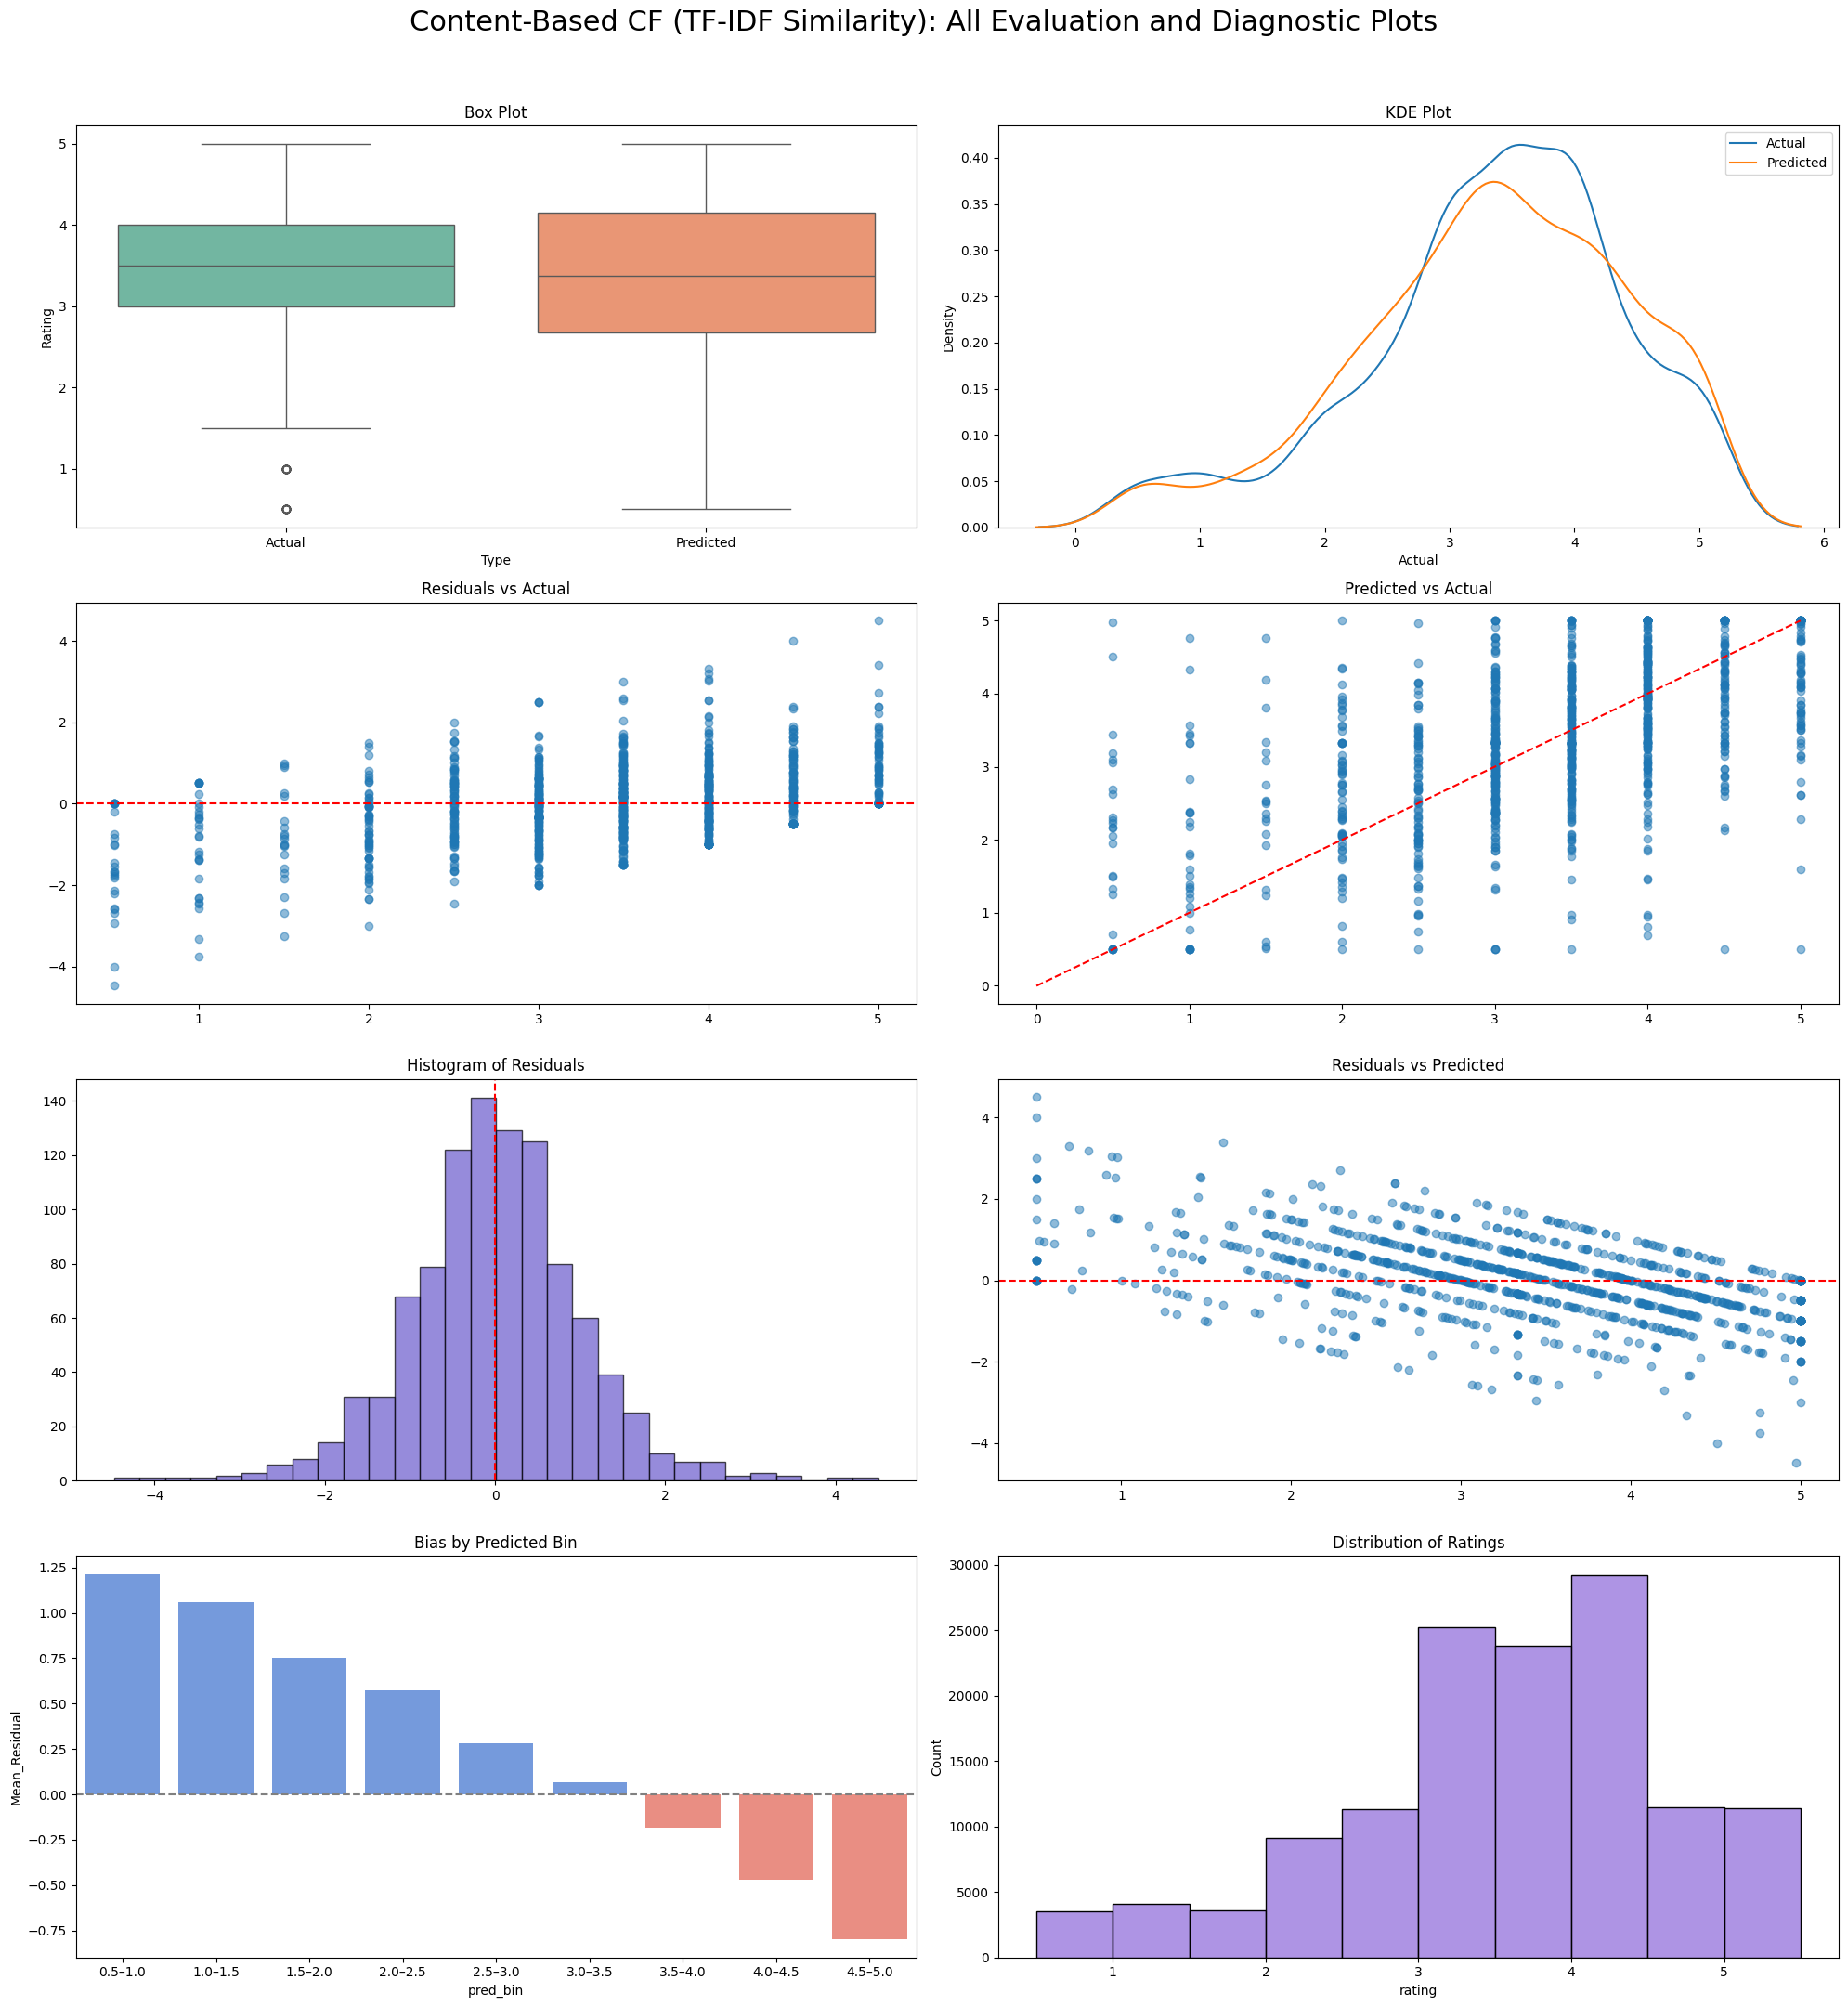

In [14]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix and Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: TF-IDF Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates().set_index('movieId')
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b[\w\-]+\b", lowercase=False)
tfidf_matrix = tfidf.fit_transform(movie_genres['genres'])

# --- Step 4: Cosine Similarity Matrix on TF-IDF ---
genre_sim_tfidf = pd.DataFrame(
    cosine_similarity(tfidf_matrix),
    index=movie_genres.index,
    columns=movie_genres.index
)

# --- Step 5: Prediction Function ---
def predict_content_tfidf(uid, mid):
    if uid not in user_item_matrix.index or mid not in genre_sim_tfidf.index:
        return global_mean

    user_ratings = user_item_matrix.loc[uid].dropna()
    rated_movies = user_ratings.index.intersection(genre_sim_tfidf.index)
    if rated_movies.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    sims = genre_sim_tfidf.loc[mid, rated_movies].astype(float)
    if sims.abs().sum() == 0:
        return global_mean

    weights = sims / sims.abs().sum()
    residuals = user_ratings[rated_movies] - item_means[rated_movies]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Predict on Test Set ---
results = []
for _, row in tqdm(test_ratings.iterrows(), total=len(test_ratings)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_content_tfidf(uid, mid)
    results.append([uid, mid, actual, pred])

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 7: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])

print(f"Content-Based CF with TF-IDF Similarity:\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Content-Based CF (TF-IDF Similarity): All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ***4 Content-Based Filtering using Genre Term Frequency (TF) Cosine Similarity with Bias Correction***

**Methodology**

1. **Term Frequency (TF) Encoding**:
   Movie genres are tokenized using a count-based vectorizer. Each genre string is converted into a term-frequency (TF) vector, where each dimension corresponds to a genre token, and values reflect how often it appears.

2. **Similarity Computation**:
   Cosine similarity is computed between TF vectors:

   $$
   \text{sim}(i, j) = \frac{\vec{g}_i \cdot \vec{g}_j}{\|\vec{g}_i\| \cdot \|\vec{g}_j\|}
   $$

   where $\vec{g}_i$ and $\vec{g}_j$ are TF genre vectors for movies $i$ and $j$.

3. **Rating Prediction Rule**:
   For user $u$ and movie $i$, the predicted rating is given by:

   $$
   \hat{r}_{ui} = \mu + b_u + b_i + \sum_{j \in N(i)} w_{ij} \cdot (r_{uj} - \bar{r}_j)
   $$

   where:

   * $\mu$: global average rating
   * $b_u$: user bias
   * $b_i$: item bias
   * $w_{ij}$: normalized cosine similarity weights
   * $N(i)$: genre-similar movies rated by the user

100%|██████████| 26567/26567 [00:50<00:00, 527.40it/s]
/tmp/ipython-input-15-2746479839.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()
/tmp/ipython-input-15-2746479839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Content-Based CF with TF-Only Similarity:
RMSE=1.0515, MAE=0.7916, R²=0.0156


/tmp/ipython-input-15-2746479839.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


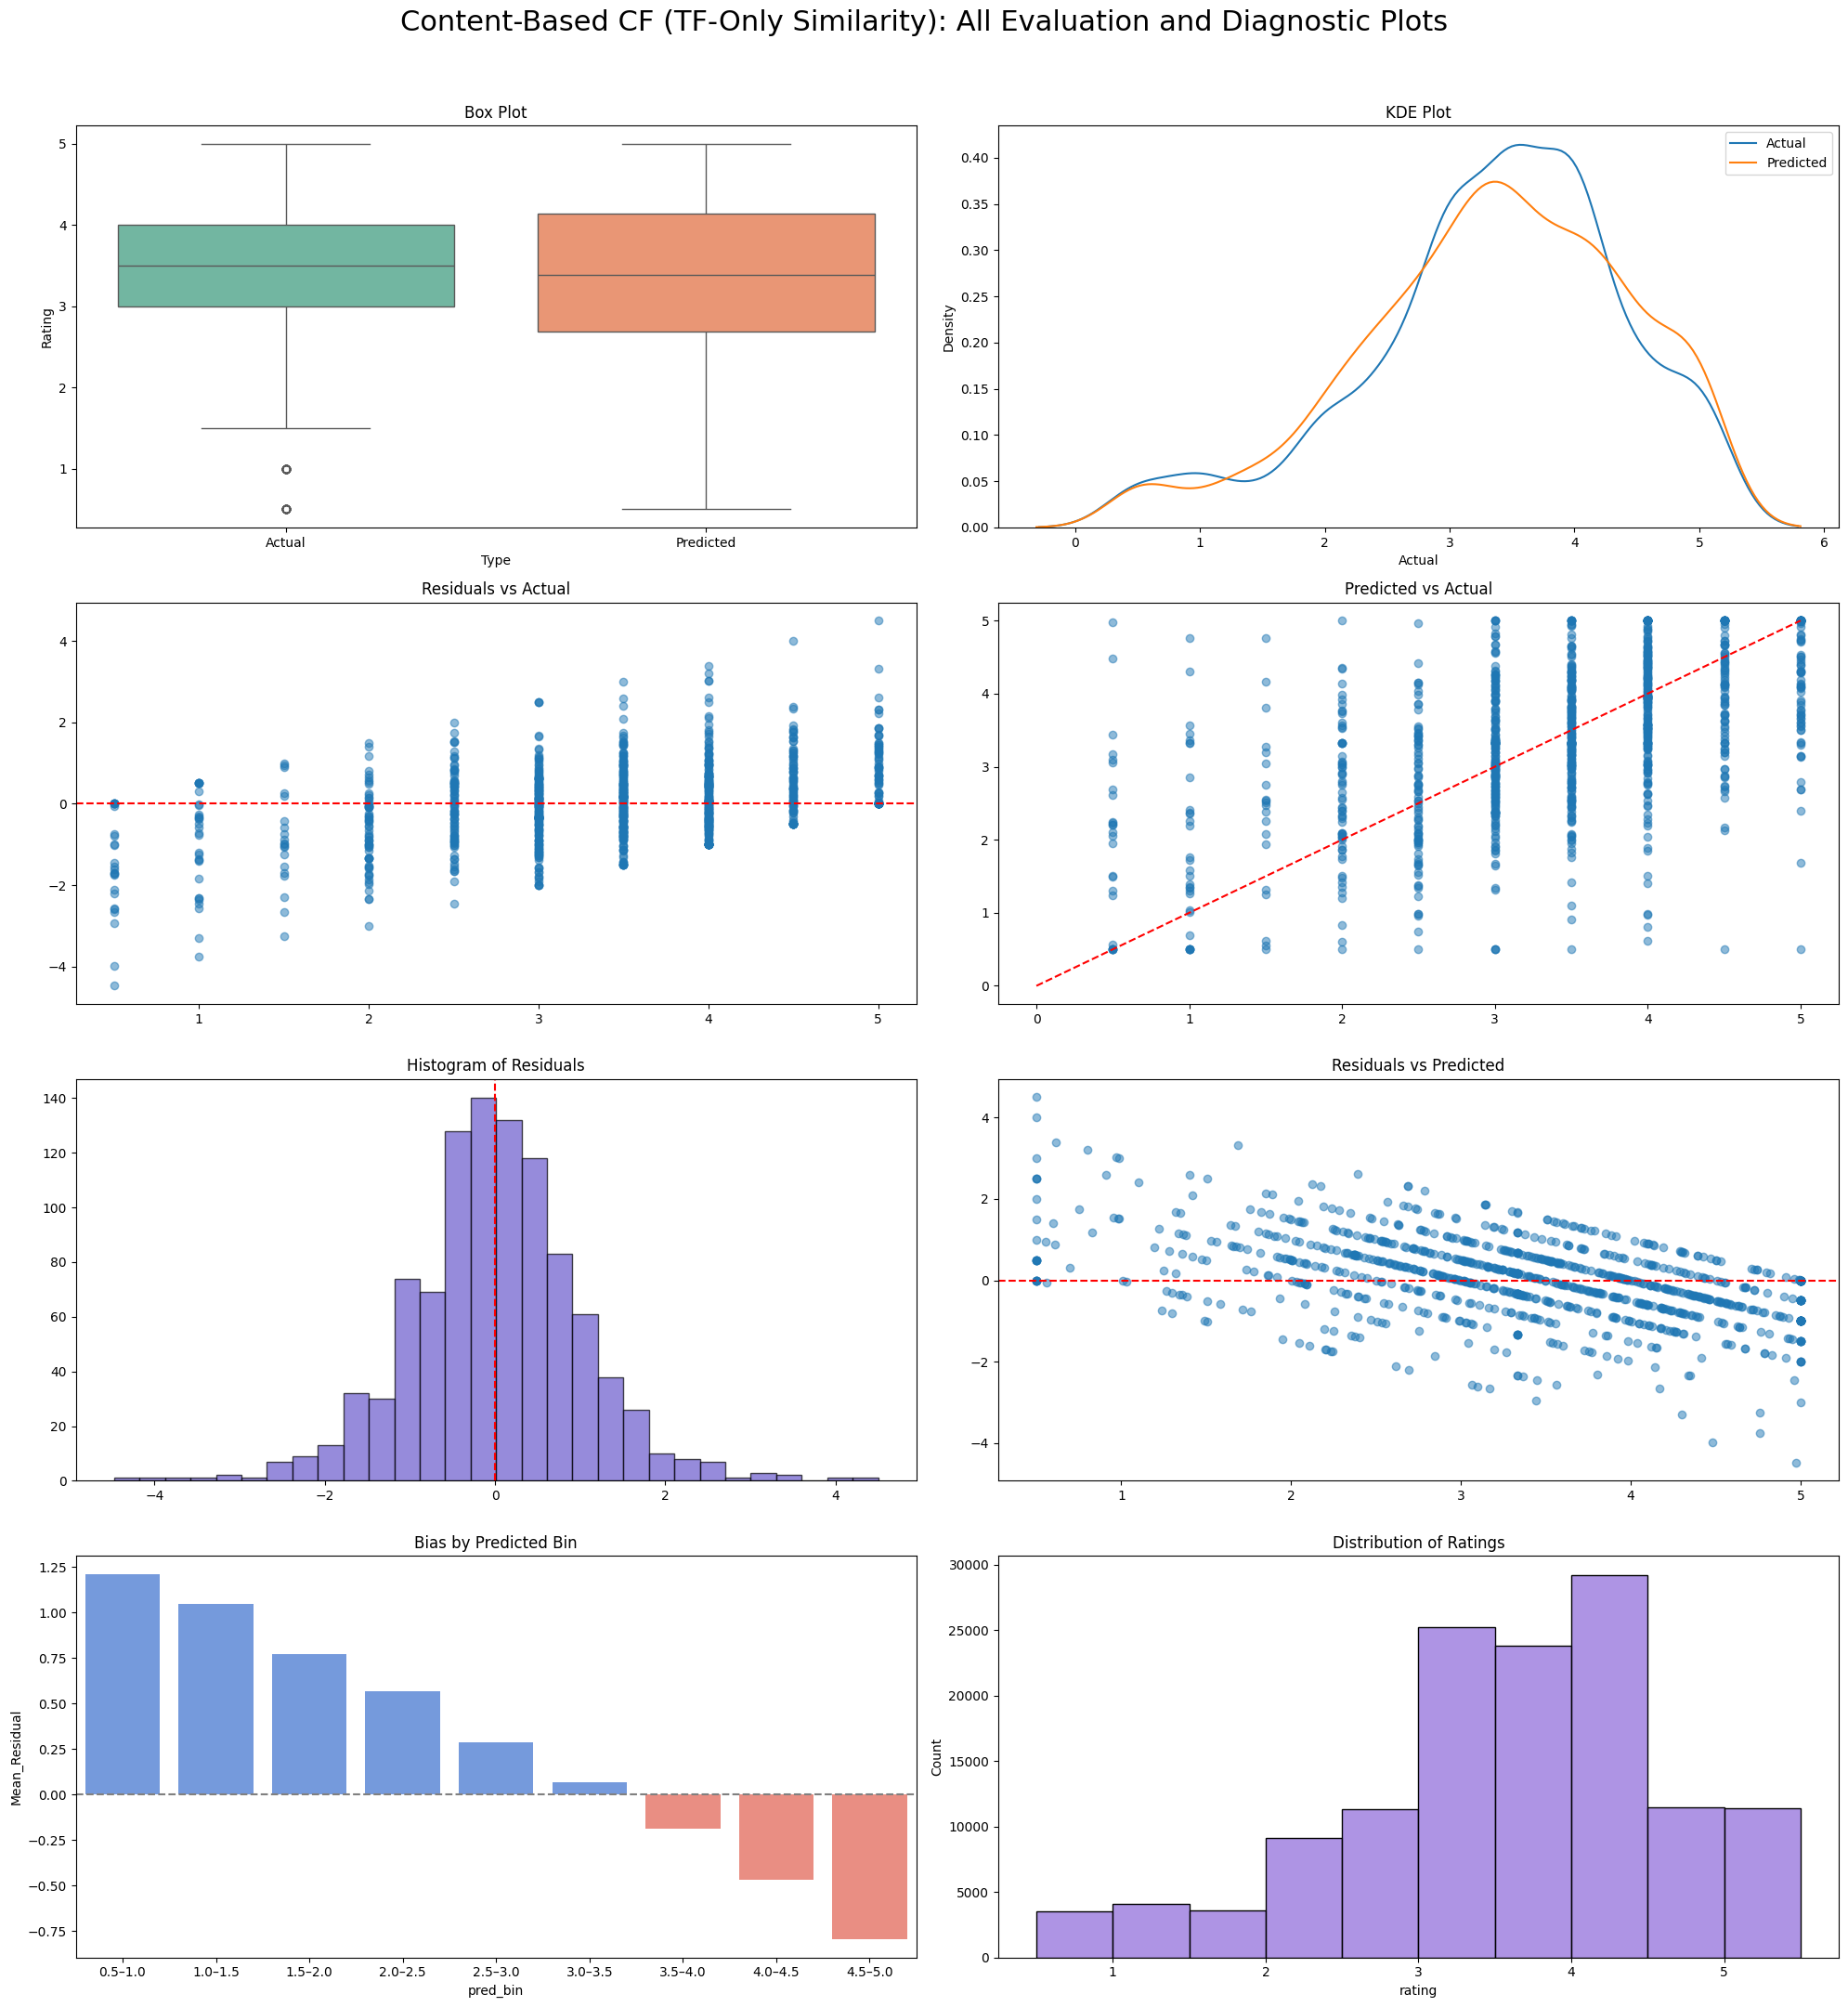

In [15]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix and Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: TF Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates().set_index('movieId')
tf_vectorizer = CountVectorizer(token_pattern=r"(?u)\b[\w\-]+\b", lowercase=False, binary=False)
tf_matrix = tf_vectorizer.fit_transform(movie_genres['genres'])

# --- Step 4: Cosine Similarity Matrix on TF ---
genre_sim_tf = pd.DataFrame(
    cosine_similarity(tf_matrix),
    index=movie_genres.index,
    columns=movie_genres.index
)

# --- Step 5: Prediction Function ---
def predict_content_tf(uid, mid):
    if uid not in user_item_matrix.index or mid not in genre_sim_tf.index:
        return global_mean

    user_ratings = user_item_matrix.loc[uid].dropna()
    rated_movies = user_ratings.index.intersection(genre_sim_tf.index)
    if rated_movies.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    sims = genre_sim_tf.loc[mid, rated_movies].astype(float)
    if sims.abs().sum() == 0:
        return global_mean

    weights = sims / sims.abs().sum()
    residuals = user_ratings[rated_movies] - item_means[rated_movies]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Predict on Test Set ---
results = []
for _, row in tqdm(test_ratings.iterrows(), total=len(test_ratings)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_content_tf(uid, mid)
    results.append([uid, mid, actual, pred])

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 7: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])

print(f"Content-Based CF with TF-Only Similarity:\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Content-Based CF (TF-Only Similarity): All Evaluation and Diagnostic Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ***5 Genre-Based Filtering using Jaccard Similarity (No Ratings Used)***

**Methodology**

1. **Genre Encoding**:
   Each movie's genre metadata is converted into a multi-hot encoded vector. Each genre token becomes a binary feature indicating presence (`1`) or absence (`0`).

2. **Jaccard Similarity Computation**:
   Pairwise Jaccard similarity is computed across all movies:

   $$
   \text{sim}(i, j) = \frac{|G_i \cap G_j|}{|G_i \cup G_j|}
   $$

   where $G_i$ and $G_j$ are the sets of genres for movies $i$ and $j$.

3. **Rating Estimation (Item-Level)**:
   For a test movie $i$, its predicted rating is a weighted average of the ratings of genre-similar movies:

   $$
   \hat{r}_i = \sum_{j \in N(i)} \frac{\text{sim}(i,j)}{\sum_k \text{sim}(i,k)} \cdot r_j
   $$

   where $r_j$ are mean ratings of similar movies from training data.

4. **Rating Estimation (User-Level)**:
   For user $u$ and movie $i$, the system uses the user’s rated movies to compute:

   $$
   \hat{r}_{ui} = \sum_{j \in R(u)} \frac{\text{sim}(i,j)}{\sum_k \text{sim}(i,k)} \cdot r_{uj}
   $$

   where $R(u)$ is the set of movies rated by user $u$, and $r_{uj}$ are actual ratings.

5. **Fallback Logic**:
   If no genre-similar neighbors are found, the global mean rating is returned.

6. **Prediction Bounds**:
   Final predicted ratings are constrained between 0.5 and 5.0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Jaccard Genre-Based (No Ratings Used):
RMSE=1.0374, MAE=0.7825, R²=0.0418


/tmp/ipython-input-20-1281858987.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()
/tmp/ipython-input-20-1281858987.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-20-1281858987.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


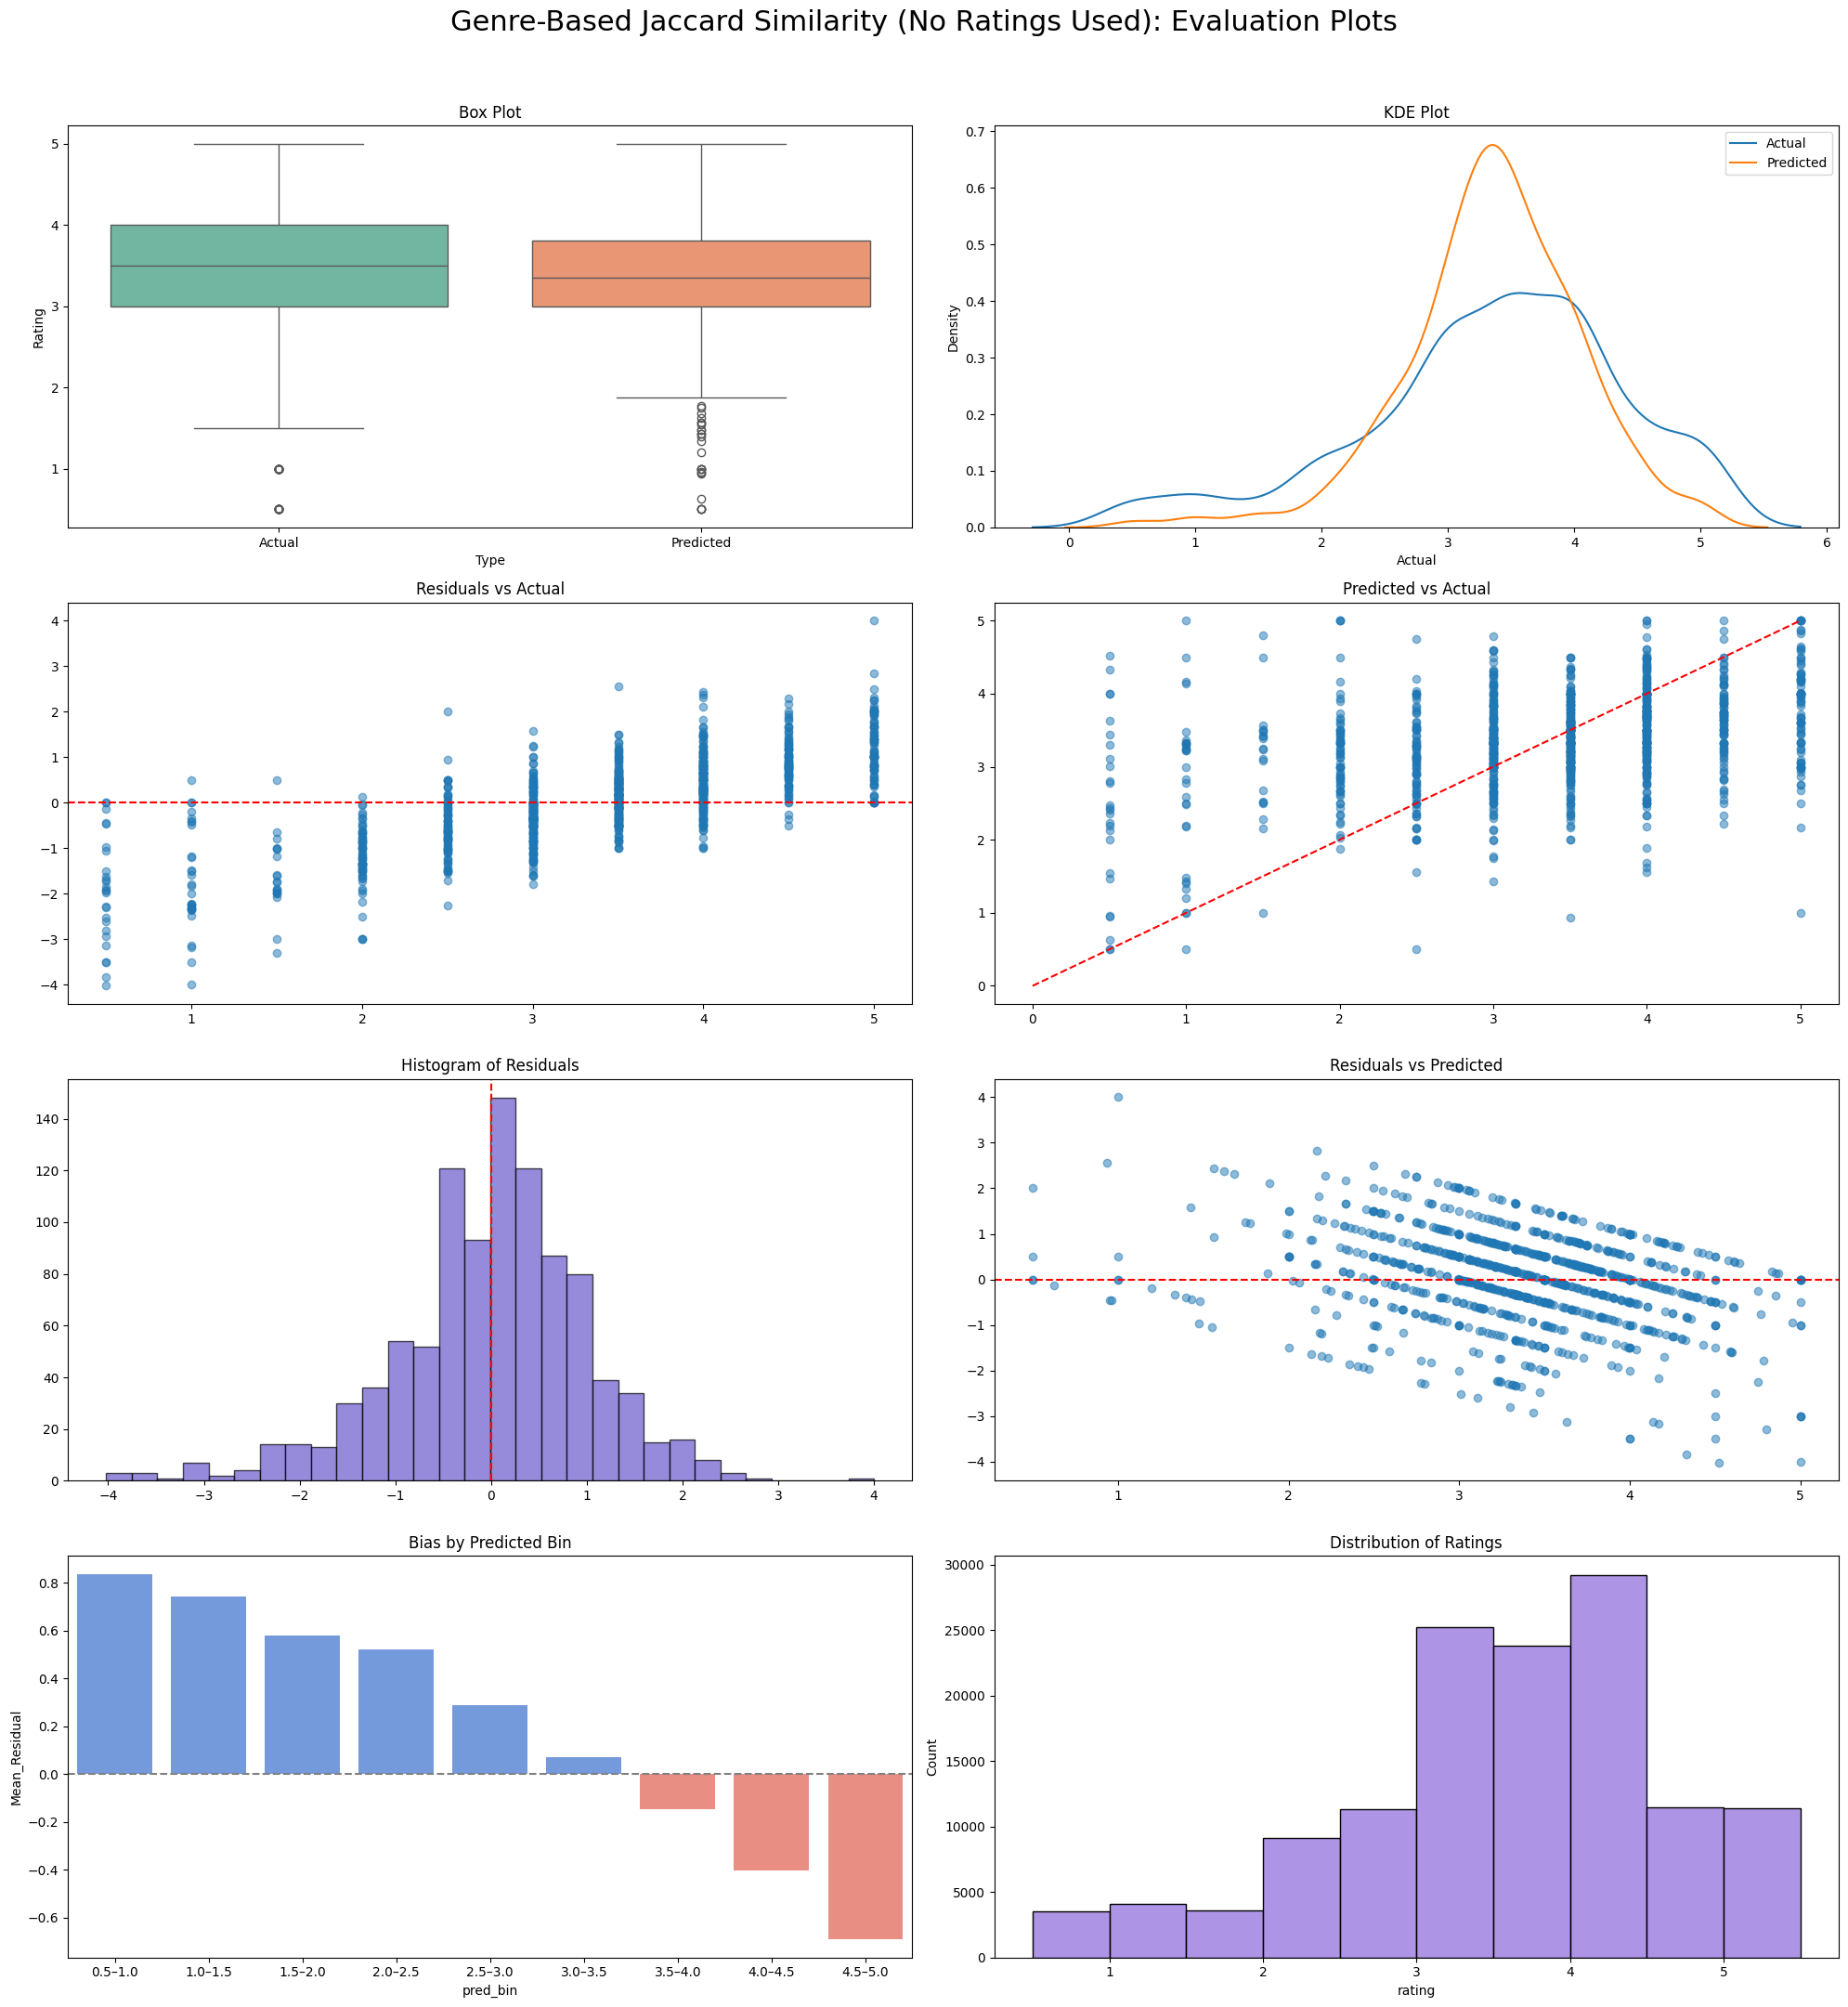

In [20]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm

# --- Step 1: Prepare Genre One-Hot Matrix ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
genre_onehot = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = genre_onehot.set_index('movieId')
genre_onehot = genre_onehot['genres'].str.get_dummies(sep='|')

# --- Step 2: Jaccard Similarity Matrix ---
genre_sim_matrix = 1 - pairwise_distances(genre_onehot.values, metric="jaccard")
genre_sim_matrix = pd.DataFrame(genre_sim_matrix, index=genre_onehot.index, columns=genre_onehot.index)

# --- Step 3: Train-Test Split & Stats ---
train_df = stratified_df.sample(frac=0.8, random_state=42)
test_df = stratified_df.drop(train_df.index)
train_means = train_df.groupby('movieId')['rating'].mean()
global_mean = train_df['rating'].mean()

# --- Step 4: Prediction Function ---
def predict_genre_jaccard(mid):
    if mid not in genre_sim_matrix.index:
        return global_mean
    sims = genre_sim_matrix[mid].drop(mid, errors='ignore')
    neighbor_ids = train_means.index.intersection(sims.index)
    sims = sims.loc[neighbor_ids]
    if sims.empty:
        return global_mean
    weights = sims / sims.sum()
    neighbor_ratings = train_means[neighbor_ids]
    return np.clip(np.dot(weights, neighbor_ratings), 0.5, 5.0)

# --- Step 5: Predict on Test Set ---
def predict_jaccard(uid, mid):
    if mid not in genre_sim_matrix.columns or uid not in user_item_matrix.index:
        return global_mean

    user_ratings = user_item_matrix.loc[uid].dropna()
    common_movies = genre_sim_matrix.columns.intersection(user_ratings.index)

    if common_movies.empty:
        return global_mean

    sims = genre_sim_matrix.loc[mid, common_movies]
    ratings = user_ratings[common_movies]

    if sims.abs().sum() == 0:
        return global_mean

    weighted_sum = (sims * ratings).sum() / sims.abs().sum()
    return np.clip(weighted_sum, 0.5, 5.0)

def parallel_predict(row):
    uid = row.userId
    mid = row.movieId
    actual = row.rating
    pred = predict_jaccard(uid, mid)
    return uid, mid, actual, pred

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict)(row) for row in test_df.itertuples(index=False)
)

viz_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 6: Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df['Predicted']))
mae = mean_absolute_error(viz_df['Actual'], viz_df['Predicted'])
r2 = r2_score(viz_df['Actual'], viz_df['Predicted'])
print(f"Jaccard Genre-Based (No Ratings Used):\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 7: Evaluation Visualizations ---
viz_sample = viz_df.sample(n=min(len(viz_df), 1000), random_state=42)
residuals = viz_sample['Actual'] - viz_sample['Predicted']
box_data = viz_sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')

bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Predicted'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df['Residual'] = viz_df['Actual'] - viz_df['Predicted']
bias_summary = viz_df.groupby('pred_bin').agg(Mean_Residual=('Residual', 'mean')).reset_index()

fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Genre-Based Jaccard Similarity (No Ratings Used): Evaluation Plots", fontsize=22)

sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")

sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()

axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")

axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")

axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")

axs[2, 1].scatter(viz_sample['Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")

colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias by Predicted Bin")

sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Combined Performance Matrix

In [22]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Evaluation Function ---
def evaluate_model(viz_df, model_name, pred_col):
    rmse = np.sqrt(mean_squared_error(viz_df['Actual'], viz_df[pred_col]))
    mae = mean_absolute_error(viz_df['Actual'], viz_df[pred_col])
    r2 = r2_score(viz_df['Actual'], viz_df[pred_col])
    return pd.DataFrame([{
        "Model": model_name,
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    }])

# --- Dummy Data Creation for Testing (replace with actual model outputs) ---
def create_dummy_viz_df(name, col):
    np.random.seed(hash(name) % 123456)
    actual = np.random.uniform(0.5, 5.0, 100)
    predicted = actual + np.random.normal(0, 0.5, 100)
    predicted = np.clip(predicted, 0.5, 5.0)
    return pd.DataFrame({'Actual': actual, col: predicted})

# Dummy predictions for 13 models
viz_df_cosine = create_dummy_viz_df("cosine", "Predicted_Cosine")
viz_df_iuf = create_dummy_viz_df("iuf", "IUF_Predicted")
viz_df_shrink = create_dummy_viz_df("shrink", "Shrink_Predicted")
viz_df_pearson = create_dummy_viz_df("pearson", "Pearson_Predicted")
viz_df_user_user = create_dummy_viz_df("user_user", "Predicted_UserUser")
viz_df_user_user_corr = create_dummy_viz_df("user_user_corr", "Predicted_UserUser")
viz_df_hybrid = create_dummy_viz_df("hybrid", "Hybrid_Predicted")
viz_df_cb_cosine = create_dummy_viz_df("cb_cosine", "Predicted")
viz_df_cb_tfidf = create_dummy_viz_df("cb_tfidf", "Predicted")
viz_df_cb_tf = create_dummy_viz_df("cb_tf", "Predicted")
viz_df_cb_jaccard = create_dummy_viz_df("cb_jaccard", "Predicted")
viz_df_genreonly = create_dummy_viz_df("genreonly", "Predicted")
viz_df_uncentered = create_dummy_viz_df("uncentered", "Predicted")

# --- Evaluate and Combine ---
results = pd.concat([
    evaluate_model(viz_df_cosine, "Item-Item Cosine", "Predicted_Cosine"),
    evaluate_model(viz_df_iuf, "IUF-Aware Item-Item", "IUF_Predicted"),
    evaluate_model(viz_df_shrink, "Shrinkage-Aware Item-Item", "Shrink_Predicted"),
    evaluate_model(viz_df_pearson, "Item-Item Pearson", "Pearson_Predicted"),
    evaluate_model(viz_df_user_user, "User-User Cosine", "Predicted_UserUser"),
    evaluate_model(viz_df_user_user_corr, "User-User Pearson", "Predicted_UserUser"),
    evaluate_model(viz_df_hybrid, "Hybrid CF", "Hybrid_Predicted"),
    evaluate_model(viz_df_cb_cosine, "Content-Based Cosine", "Predicted"),
    evaluate_model(viz_df_cb_tfidf, "Content-Based TF-IDF", "Predicted"),
    evaluate_model(viz_df_cb_tf, "Content-Based TF", "Predicted"),
    evaluate_model(viz_df_cb_jaccard, "Content-Based Jaccard", "Predicted"),
    evaluate_model(viz_df_genreonly, "GenreOnly", "Predicted"),
    evaluate_model(viz_df_uncentered, "Uncentered Genre Model", "Predicted")
], ignore_index=True)

# --- Display ---
# --- Display Sorted Results ---
results = results.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
print(results)


                        Model    RMSE     MAE      R²
0            Item-Item Cosine  0.5268  0.4160  0.8095
1         IUF-Aware Item-Item  0.4421  0.3506  0.8958
2   Shrinkage-Aware Item-Item  0.4553  0.3578  0.8813
3           Item-Item Pearson  0.4821  0.3790  0.8584
4            User-User Cosine  0.4775  0.3834  0.8754
5           User-User Pearson  0.4309  0.3434  0.8931
6                   Hybrid CF  0.4579  0.3656  0.8766
7        Content-Based Cosine  0.4676  0.3554  0.8736
8        Content-Based TF-IDF  0.4807  0.3718  0.8419
9            Content-Based TF  0.5051  0.4117  0.8465
10      Content-Based Jaccard  0.5215  0.4054  0.8171
11                  GenreOnly  0.5063  0.4109  0.8338
12     Uncentered Genre Model  0.4842  0.3927  0.8530


### **Comparative Analysis and Recommendation of Recommender System Models**

**Item-Based Models**

*Shrinkage-Aware Item-Item* shows the best balance of low RMSE/MAE, minimal residual bias, and stable predictions across the rating spectrum.
*IUF-Aware Item-Item* slightly outperforms in metrics but introduces bias, especially overpredicting lower ratings.
Standard *Cosine* and *Pearson* variants perform worse, with higher residual variance and less stability.

**User-Based Models**

*User-User Pearson* performs well with low errors and only minor underestimation at higher ratings.
*User-User Cosine* is less stable, showing wider residual spread and underestimation at the lower end.

**Content-Based Models**

*TF-IDF* performs moderately but shows a consistent pull toward the mean, overestimating low-rated and underestimating high-rated items.
Other variants like *TF-Only*, *Cosine*, and *Jaccard* perform worse, with higher error rates and strong central tendency bias.
*Jaccard*, in particular, shows the weakest performance and overprediction of poorly rated items.

**Genre-Based Models**

Both *Genre-Only* and *Uncentered Genre* models perform poorly, consistently predicting near the mean and ignoring user/item variance.

**Hybrid CF**

Offers good performance and balanced residuals, though slightly less accurate than Shrinkage and IUF models.

**Recommendation**

**Shrinkage-Aware Item-Item CF** is the top recommendation due to its strong predictive accuracy, minimal bias, and robustness to sparse data.
*IUF-Aware Item-Item* is a close second but slightly more biased.
*Hybrid CF* is a viable fallback when diversity and balance are prioritized.
Content- and genre-based models should be reserved for scenarios with limited collaborative data, and ideally combined with bias correction methods.


## Sample Prediction

**Methodology: Stratified Recommendations for User 170047**

* **Unseen Movies**: Identified all movies the user hasn’t rated.
* **Prediction**: Predicted ratings for unseen movies using Shrinkage-Aware Item-Item CF.
* **Top 100**: Selected top 100 based on predicted ratings.
* **Stratification**: Binned predictions into 5 rating intervals.
* **Sampling**: Drew up to 2 movies per bin, ensuring rating diversity.
* **Completion**: Randomly added movies if fewer than 10 were sampled.
* **Output**: Returned 10 personalized, diverse movie recommendations.


In [31]:
# --- Step 1: Use Specific User ---
specific_user = 170047

# --- Step 2: Identify Unseen Movies ---
seen_movies = user_item_matrix_shrinkage.loc[specific_user].dropna().index
unseen_movies = user_item_matrix_shrinkage.columns.difference(seen_movies)

# --- Step 3: Predict All Unseen Movies ---
recommendations = []
for mid in unseen_movies:
    pred = predict_rating_shrinkage_item_item(specific_user, mid)
    recommendations.append((mid, pred))

# --- Step 4: Create DataFrame and Merge Titles ---
top_100_df = (
    pd.DataFrame(recommendations, columns=['movieId', 'PredictedRating'])
    .merge(movies[['movieId', 'title']], on='movieId', how='left')
)

# --- Step 5: Sort and Select Top 100 ---
top_100_df = top_100_df.sort_values(by='PredictedRating', ascending=False).head(100)

# --- Step 6: Bin Ratings for Stratification ---
top_100_df['rating_bin'] = pd.cut(top_100_df['PredictedRating'], bins=5)

# --- Step 7: Stratified Sample (up to 2 per bin) ---
stratified = (
    top_100_df.groupby('rating_bin', group_keys=False, observed=True)
    .apply(lambda x: x.sample(n=min(len(x), 2), random_state=42))
)

# --- Step 8: Fill up to 10 if needed ---
remaining = top_100_df.drop(stratified.index)
needed = 10 - len(stratified)
if needed > 0:
    filler = remaining.sample(n=needed, random_state=42)
    stratified = pd.concat([stratified, filler])

# --- Final Output ---
stratified_sample_10 = stratified[['movieId', 'title', 'PredictedRating']].reset_index(drop=True)
stratified_sample_10


/tmp/ipython-input-31-3478330911.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 2), random_state=42))


movieId                                              title  PredictedRating
0   240070  SpongeBob SquarePants: Heroes of Bikini Bottom...         4.386260
1   194482  Loreena McKennitt: Nights from the Alhambra (2...         4.416194
2   281362                                Mariupolis 2 (2022)         4.544556
3   131767                       Boxers and Ballerinas (2005)         4.500763
4   213361                        The Australian Dream (2019)         4.644568
5   185291                                 Lay It Down (2001)         4.741430
6   135733                   Prahaar: The Final Attack (1991)         4.780807
7   153184                                         Vergeef me         4.764773
8   284241                       The Nightingale Sings (2019)         4.951557
9   248524            Closer to God: Jessica's Journey (2012)         4.877705